In [1]:
import os
import sys
import itertools
from glob import glob
import numpy as np
import nibabel as ni
import pandas
from copy import deepcopy
from sklearn import preprocessing, linear_model
from sklearn.model_selection import KFold
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.stats.multicomp import fdrcorrection0 as FDR


In [2]:
rs_folder = '/Users/jakevogel/Science/Prevent_AD/rsfmri_bl_avg/'
subs = sorted(glob(os.path.join(rs_folder,'avg*')))

In [3]:
tst_sub = pandas.read_table(subs[0],header=None)
tst_sub = tst_sub.drop(tst_sub.columns[-1],axis=1)
tst_vals = tst_sub.values

In [4]:
features = tst_vals[[x[0] for x in itertools.combinations(range(272),2)],
                  [y[1] for y in itertools.combinations(range(272),2)]]

In [5]:
subids = [x.split('_')[6] for x in subs]
all_subs = pandas.DataFrame(index=subids,columns = range(len(features)))
for sub in subs:
    sid = sub.split('_')[6]
    
    mtx = pandas.read_table(sub,header=None)
    mtx = mtx.drop(mtx.columns[-1],axis=1)
    vals = mtx.values
    features = vals[[x[0] for x in itertools.combinations(range(272),2)],
                  [y[1] for y in itertools.combinations(range(272),2)]]
    all_subs.loc[sid] = features
    print('finished subject',sid)
    

finished subject s108583NAP
finished subject s113451NAP
finished subject s115095PRE
finished subject s117603PRE
finished subject s139940PRE


KeyboardInterrupt: 

In [6]:
jnk = []
for i,sid in enumerate(subids):
    if sid[1:7] not in jnk:
        jnk.append(sid[1:7])
    else:
        print(i,sid)

94 s422116PRE


In [7]:
all_subs = all_subs.drop(subids[93])

In [8]:
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx')
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx').parse(jnk.sheet_names[0])
jnk.index = jnk.CandID

In [9]:
len([x for x in all_subs.index if int(x[1:7]) in jnk.index])

274

In [10]:
duplicate = deepcopy(all_subs)

In [11]:
nids = []
for sid in all_subs.index:
    nids.append(jnk.loc[int(sid[1:7])][jnk.columns[0]])
all_subs.index = nids

In [12]:
outcomes = pandas.ExcelFile(
        '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/Outcomes_2_and_3.xls'
                           ).parse('Sheet1')
outcomes.index = outcomes[outcomes.columns[0]]

In [13]:
shared = list(set(all_subs.index) & set(outcomes.index))

In [14]:
all_data = all_subs.loc[shared]

In [15]:
(len(all_data)/3) * 2

127.33333333333333

In [16]:
train = all_data.loc[all_data.index[:127]]
test = all_data.loc[all_data.index[127:]]

In [1094]:
train.to_csv('/Users/jakevogel/Science/Prevent_AD/rsfmri_bl_avg/train.csv')

In [164]:
%%timeit
stats.pearsonr(outcomes.loc[train.index].Outcome2,train.values[:,x])

1000 loops, best of 3: 736 µs per loop


In [169]:
cProfile.run('stats.pearsonr(outcomes.loc[train.index].Outcome2,train.values[:,x])')

         685 function calls (672 primitive calls) in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:175(iteritems)
        2    0.000    0.000    0.000    0.000 _methods.py:31(_sum)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_any)
        1    0.000    0.000    0.000    0.000 _methods.py:40(_all)
        2    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 _methods.py:53(_mean)
        2    0.000    0.000    0.000    0.000 algorithms.py:1010(take_nd)
        2    0.000    0.000    0.000    0.000 algorithms.py:977(_get_take_nd_function)
        1    0.000    0.000    0.000    0.000 base.py:1097(is_unique)
        1 

In [172]:
cProfile.run('stats.pearsonr(outcomes.loc[tpso_train.index].Outcome2,tpso_train.values[:,x])')

         725 function calls (709 primitive calls) in 0.270 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        1    0.035    0.035    0.270    0.270 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:175(iteritems)
        2    0.000    0.000    0.000    0.000 _methods.py:31(_sum)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_any)
        2    0.000    0.000    0.000    0.000 _methods.py:40(_all)
        2    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 _methods.py:53(_mean)
        2    0.000    0.000    0.000    0.000 algorithms.py:1010(take_nd)
        2    0.000    0.000    0.000    0.000 algorithms.py:977(_get_take_nd_function)
        1    0.000    0.000    0.000    0.000 base.py:1097(is_unique)
        1 

In [166]:
%%timeit
stats.pearsonr(outcomes.loc[tpso_train.index].Outcome2,tpso_train.values[:,x])

1 loop, best of 3: 176 ms per loop


In [195]:
%%timeit
train.values[:,x]

The slowest run took 4.29 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.1 µs per loop


In [17]:
ps = []
for x in range(train.shape[1]):
        ps.append(stats.pearsonr(outcomes.loc[tmp_mtx.index].Outcome2,train.values[:,x])[1])

NameError: name 'tmp_mtx' is not defined

In [54]:
#feature_matrix = pandas.DataFrame(np.full_like(train,np.nan))
feature_matrix = pandas.read_csv(
        '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/lasso_weights.csv')
feature_matrix.drop(feature_matrix.columns[0],axis=1)
predicted = []

#for sub,row in train.iterrows():
for sub,row in train.loc[train.index[99:]].iterrows():
    i = train.index.tolist().index(sub)
    tmp_mtx = train.drop(sub)
    ps = []
    print('running correlation for ',i)
    for x in range(tmp_mtx.shape[1]):
        ps.append(stats.pearsonr(outcomes.loc[tmp_mtx.index].Outcome2,tmp_mtx.values[:,x])[1])
    ps_s = pandas.Series(ps)
    sig = ps_s[ps_s<0.005]
    if len(sig) == 0:
        continue
    sig_mtx = tmp_mtx[sig.index]
    print('running lasso for ',i)
    preprocessing.StandardScaler().fit(sig_mtx)
    lasso = linear_model.LassoCV(cv=10).fit(sig_mtx,
                          outcomes.loc[sig_mtx.index].Outcome2
                       )
    #print(i, len(sig_mtx.columns),len(lasso.coef_))
    feature_matrix.loc[i][sig_mtx.columns] = lasso.coef_
    predicted.append(lasso.predict(
                        train.loc[sub][sig_mtx.columns].values.reshape(1,-1))[0])
    print('saving matrix ',i)
    feature_matrix.to_csv(
            '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/lasso_weights.csv')
    pandas.DataFrame(pandas.Series(predicted)).to_csv(
            '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/lasso_predicted.csv')

running correlation for  99
running lasso for  99


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  99
running correlation for  100
running lasso for  100


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  100
running correlation for  101
running lasso for  101


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  101
running correlation for  102
running lasso for  102


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  102
running correlation for  103
running lasso for  103


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  103
running correlation for  104
running lasso for  104


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  104
running correlation for  105
running lasso for  105


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  105
running correlation for  106
running lasso for  106


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  106
running correlation for  107
running lasso for  107


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  107
running correlation for  108
running lasso for  108


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  108
running correlation for  109
running lasso for  109


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  109
running correlation for  110
running lasso for  110


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  110
running correlation for  111
running lasso for  111


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  111
running correlation for  112
running lasso for  112


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  112
running correlation for  113
running lasso for  113


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  113
running correlation for  114
running lasso for  114


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  114
running correlation for  115
running lasso for  115


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  115
running correlation for  116
running lasso for  116


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  116
running correlation for  117
running lasso for  117


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  117
running correlation for  118
running lasso for  118


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  118
running correlation for  119
running lasso for  119


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  119
running correlation for  120
running lasso for  120


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  120
running correlation for  121
running lasso for  121


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  121
running correlation for  122
running lasso for  122


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  122
running correlation for  123
running lasso for  123


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  123
running correlation for  124
running lasso for  124


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  124
running correlation for  125
running lasso for  125


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  125
running correlation for  126
running lasso for  126


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/series.py:769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


saving matrix  126


In [55]:
feature_matrix_zeros = deepcopy(feature_matrix)

In [56]:
a = feature_matrix_zeros.values.astype(float)
where_are_NaNs = np.isnan(a)
a[where_are_NaNs] = 0

In [57]:
final_weights = a.mean(axis=0)

In [58]:
len(final_weights[final_weights>0])

132

In [59]:
len(outcomes.loc[train.index].Outcome2)

127

In [63]:
stats.pearsonr(outcomes.loc[train.index].Outcome2[-28:],predicted)

(0.038632557058893631, 0.84525463626305819)

In [1219]:
pandas.DataFrame(outcomes.loc[train.index].Outcome2).to_excel(
        '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/train_outcomes.xls')

In [18]:
jnk = pandas.DataFrame(outcomes.loc[train.index].Outcome2)

In [19]:
jnk = test[sig_mtx.columns]
jnk.ix[:,'outcome2'] = outcomes.loc[test.index].Outcome2

NameError: name 'sig_mtx' is not defined

In [1238]:
jnk.to_csv('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/test_outcomes.csv')

In [20]:
pad = pandas.read_csv(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/data/stop_AD_updated_RBANS_longiGM3.csv')

In [21]:
pad.index = pad[pad.columns[1]]
tpso_shared = set(pad.index) & set(all_subs.index)

In [22]:
tpso_subs = all_subs.loc[tpso_shared]

In [23]:
missing_data = [x for x in pad.loc[tpso_shared].tEAO.index if not pandas.notnull(pad.tEAO[x])]
tpso_subs.drop(missing_data,axis=0,inplace=True)

In [20]:
tpso_subs.shape

(0, 36856)

In [24]:
(len(tpso_subs)/3) * 2

138.66666666666666

In [25]:
def balance_cohorts(df,col,ratio=2):
    train_ids,test_ids = [],[]
    subs = df.sort_values(col).index
    x = 0
    for i,sub in enumerate(subs):
        if i - x < ratio:
            train_ids.append(sub)
        else:
            test_ids.append(sub)
            x = i+1
    
    return train_ids,test_ids
            

In [26]:
train_ids,test_ids = balance_cohorts(pad.loc[tpso_subs.index],'tEAO')

In [27]:
htrain_ids,htest_ids = balance_cohorts(pad.loc[tpso_subs.index],'tEAO',1)

In [469]:
len(htrain_ids),len(htest_ids)

(104, 104)

In [98]:
len(train_ids),len(test_ids)

(139, 69)

In [28]:
stats.ttest_ind(pad.loc[train_ids].tEAO,pad.loc[test_ids].tEAO)

Ttest_indResult(statistic=-0.17146137928003372, pvalue=0.86402930493699315)

In [29]:
tpso_train = tpso_subs.loc[train_ids]
tpso_test = tpso_subs.loc[test_ids]

In [30]:
htpso_train = tpso_subs.loc[htrain_ids]
htpso_test = tpso_subs.loc[htest_ids]

In [111]:
pad.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'scan', 'V1', 'PSCID', 'Visit', 'Flagged',
       '@1_age', '@4_education', '@1_blood_pressure',
       ...
       'atrophy_rate_1', 'atrophy_rate_2', 'atrophy_rate_3', 'atrophy_rate_4',
       'atrophy_rate_5', 'atrophy_rate_6', 'atrophy_rate_7', 'FWE_sig_regions',
       '0p001_sig_regions', 'FDRneg_atrophy_rate_1'],
      dtype='object', length=266)

In [31]:
tpso_train.ix[:,'age'] = pad.loc[tpso_train.index]['@1_age'].values.astype(object)
tpso_train.ix[:,'education'] = pad.loc[tpso_train.index]['@4_education'].values.astype(object)
tpso_train.ix[:,'gender'] = pad.loc[tpso_train.index]['Gender'].values.astype(object)
tpso_train.columns = range(len(tpso_train.columns))

In [32]:
tpso_test.ix[:,'age'] = pad.loc[tpso_test.index]['@1_age'].values.astype(object)
tpso_test.ix[:,'education'] = pad.loc[tpso_test.index]['@4_education'].values.astype(object)
tpso_test.ix[:,'gender'] = pad.loc[tpso_test.index]['Gender'].values.astype(object)
tpso_test.columns = range(len(tpso_test.columns))

In [33]:
htpso_train.ix[:,'age'] = pad.loc[htpso_train.index]['@1_age'].values.astype(object)
htpso_train.ix[:,'education'] = pad.loc[htpso_train.index]['@4_education'].values.astype(object)
htpso_train.ix[:,'gender'] = pad.loc[htpso_train.index]['Gender'].values.astype(object)
htpso_train.columns = range(len(htpso_train.columns))
htpso_test.ix[:,'age'] = pad.loc[htpso_test.index]['@1_age'].values.astype(object)
htpso_test.ix[:,'education'] = pad.loc[htpso_test.index]['@4_education'].values.astype(object)
htpso_test.ix[:,'gender'] = pad.loc[htpso_test.index]['Gender'].values.astype(object)
htpso_test.columns = range(len(htpso_test.columns))

In [133]:
(0.193*36859)/60

118.56311666666667

In [36]:
new_y = pandas.DataFrame(y,index=y.index,columns=['Y'])
new_y = new_y.loc[tpso_train.index]
y = (y-y.mean())/y.std()


In [157]:
%%timeit
stats.pearsonr(y.loc[tpso_train.index],tpso_train.values[:,0])

1 loop, best of 3: 171 ms per loop


In [153]:
%%timeit
stats.pearsonr(new_y.loc[tpso_train.index].Y,tpso_train.values[:,0])

10 loops, best of 3: 178 ms per loop


In [35]:
y = pad.loc[tpso_train.index].tEAO
x = tpso_train.values[:,0]

In [182]:
%%timeit
stats.pearsonr(x,y.values)

10000 loops, best of 3: 132 µs per loop


In [197]:
%%timeit
tpso_train.values[:,0]

1 loop, best of 3: 170 ms per loop


In [219]:
jnk = deepcopy(tpso_train)

In [220]:
jnk.columns = range(len(jnk.columns))

In [228]:
jnk.ix[:,jnk.columns[-3:]] = jnk.ix[:,jnk.columns[-3:]].astype(object)

In [229]:
%%timeit
jnk.values[:,0]

The slowest run took 10345.09 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.3 µs per loop


In [198]:
%%timeit
train.values[:,0]

The slowest run took 4.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.2 µs per loop


In [215]:
train.__dict__

{'_data': BlockManager
 Items: RangeIndex(start=0, stop=36856, step=1)
 Axis 1: Index(['MTL0249', 'MTL0282', 'MTL0079', 'MTL0361', 'MTL0514', 'MTL0274',
        'MTL0586', 'MTL0113', 'MTL0110', 'MTL0039',
        ...
        'MTL0501', 'MTL0347', 'MTL0269', 'MTL0386', 'MTL0385', 'MTL0285',
        'MTL0211', 'MTL0174', 'MTL0065', 'MTL0598'],
       dtype='object', length=127)
 ObjectBlock: slice(0, 36856, 1), 36856 x 127, dtype: object,
 '_iloc': <pandas.core.indexing._iLocIndexer at 0x136ad5e80>,
 '_item_cache': {},
 'is_copy': None}

In [214]:
tpso_train.__dict__

{'_data': BlockManager
 Items: Index([          0,           1,           2,           3,           4,
                  5,           6,           7,           8,           9,
        ...
              36849,       36850,       36851,       36852,       36853,
              36854,       36855,       'age', 'education',    'gender'],
       dtype='object', length=36859)
 Axis 1: Index(['MTL0104', 'MTL0300', 'MTL0138', 'MTL0218', 'MTL0240', 'MTL0383',
        'MTL0068', 'MTL0196', 'MTL0067', 'MTL0038',
        ...
        'MTL0039', 'MTL0246', 'MTL0013', 'MTL0206', 'MTL0032', 'MTL0014',
        'MTL0184', 'MTL0020', 'MTL0064', 'MTL0427'],
       dtype='object', length=139)
 FloatBlock: slice(36856, 36859, 1), 3 x 139, dtype: float64
 ObjectBlock: slice(0, 36856, 1), 36856 x 139, dtype: object,
 '_iloc': <pandas.core.indexing._iLocIndexer at 0x130788208>,
 '_item_cache': {},
 '_ix': <pandas.core.indexing._IXIndexer at 0x13027c1d0>,
 '_loc': <pandas.core.indexing._LocIndexer at 0x13026b668

In [199]:
train.values[:,0].shape

(127,)

In [201]:
tpso_train.values[:,0].shape

(139,)

In [184]:
len(ps)

608

In [234]:
len(ps)

36859

In [37]:
ps = []
y = y[tpso_train.index].values
for x in range(tpso_train.shape[1]):
    ps.append(stats.pearsonr(y,jnk.values[:,x])[1])

ValueError: operands could not be broadcast together with shapes (139,) (127,) 

In [253]:
ps_s = pandas.Series(ps)
sig = ps_s[ps_s < p_cutoff]
sig.index[-1]
#tpso_train[sig.index]

36856

In [254]:
tpso_train.columns[-1]

'gender'

In [473]:
y = pad.loc[tpso_train.index].tEAO
t_y = pad.loc[tpso_test.index].tEAO
p_cutoff = 0.001
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/0p001_66_33/'
tpso_weights, train_predicted, test_predicted, tpso_wmtx = loo_feature_learning(
                                                    tpso_train,tpso_test,y,t_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [477]:
y = pad.loc[htpso_train.index].tEAO
t_y = pad.loc[htpso_test.index].tEAO
p_cutoff = 0.001
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/0p001_50_50/'
htpso_weights001, htrain_predicted001, htest_predicted001, htpso_wmtx001 = loo_feature_learning(
                                                    tpso_train,tpso_test,y,t_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running correlation for  1
running correlation for  2
running correlation for  3
running correlation for  4
running correlation for  5
running correlation for  6
running correlation for  7
running correlation for  8
running correlation for  9
running correlation for  10
running correlation for  11
running correlation for  12
running correlation for  13
running correlation for  14
running correlation for  15
running correlation for  16
running correlation for  17
running correlation for  18
running correlation for  19
running correlation for  20
running correlation for  21
running correlation for  22
running correlation for  23
running correlation for  24
running correlation for  25
running correlation for  26
running correlation for  27
running correlation for  28
running correlation for  29
running correlation for  30
running correlation for  31
running correlation for  32
running correlation for  33
running correlation for  34
running correlation for  35
ru

KeyboardInterrupt: 

In [650]:
ps = []
for x in range(gm2_train.shape[1]):
    ps.append(stats.pearsonr(ld_y[gm_train.index].values,gm2_train.values[:,x])[1])

In [659]:
len([i for i in range(len(ps)) if ps[i]<0.005])

30

In [38]:
def loo_feature_learning(train, test, y, t_y, p_cutoff = None, out_dir = None, recover = None,
                        clf = linear_model.LassoCV(cv=10), output='light', scale=False):
    # train is a subjects x variables dataframe
    # y is a pandas series with the same index as train. y should not be in train
    # train and test indices should just be a range
    
    
    if recover != None:
        feature_matrix = pandas.read_csv(os.path.join(out_dir,'lasso_weights.csv'))
        feature_matrix.drop(feature_matrix.columns[0],axis=1,inplace=True)
        jnk=[]
        for i,row in feature_matrix.iterrows():
            if len(row[np.isnan(row)]) == 0:
                start = i
                break
        predicted = pandas.read_csv(os.path.join(out_dir,'lasso_predicted.csv'))
        predicted = predicted[predicted.columns[-1]].tolist()
    else:
        feature_matrix = pandas.DataFrame(np.zeros_like(train))
        predicted = []
        start = 0

    if scale:
        master_scl = preprocessing.StandardScaler().fit(train)
        train = pandas.DataFrame(master_scl.transform(train),
                                 index=train.index,columns=train.columns)
        test = pandas.DataFrame(master_scl.transform(test),
                                 index=test.index,columns=test.columns)
        
    for sub,row in train.loc[train.index[start:]].iterrows():
        i = train.index.tolist().index(sub)
        tmp_mtx = train.drop(sub)
        ps = []
        print('running correlation for ',i)
        if p_cutoff != None:
            for x in range(tmp_mtx.shape[1]):
                ps.append(stats.pearsonr(
                            y[tmp_mtx.index].values,tmp_mtx.values[:,x])[1]
                         )
            ps_s = pandas.Series(ps)
            sig = ps_s[ps_s < p_cutoff]
            if len(sig) == 0:
                continue
            sig_mtx = tmp_mtx[sig.index]
        else:
            sig_mtx = tmp_mtx[tmp_mtx.columns[:]]
        print('running lasso for ',i)
        lasso = clf.fit(sig_mtx,y[sig_mtx.index])
        feature_matrix.loc[i][sig_mtx.columns] = lasso.coef_
        predicted.append(lasso.predict(
                            train.loc[sub][sig_mtx.columns].values.reshape(1,-1))[0])
        if out_dir != None and type(out_dir) == str:
            print('saving matrix ',i)
            if not os.path.isdir(out_dir):
                os.mkdir(out_dir)
            feature_matrix.to_csv(os.path.join(out_dir,'lasso_weights.csv'))
            pandas.DataFrame(pandas.Series(predicted)).to_csv(
                                                    os.path.join(out_dir,'lasso_predicted.csv'))
        
    final_weights = feature_matrix.mean(axis=0)
    print(len([i for i in final_weights.index if abs(final_weights[i]) > 0 ]),'features selected')
    r,p = stats.pearsonr(y[train.index],predicted)
    print('validation prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    t_predicted = (test * np.array(final_weights)).sum(axis=1)
    r,p = stats.pearsonr(t_y[test.index],t_predicted)
    print('testing prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    if output == 'light':
        return final_weights, predicted, t_predicted
    else:
        return final_weights, predicted, t_predicted, feature_matrix 
    

In [39]:
def kfold_feature_learning(train, test, y, t_y, folds = 10, p_cutoff = None, 
                           out_dir = None, clf = linear_model.LassoCV(cv=10), 
                           output='light', scale=False, regcols = None, regdf = None,
                          keep_cols = None, save_int = True):
    
    # train is a subjects x variables dataframe
    # y is a pandas series with the same index as train. y should not be in train
    # train and test indices should just be a range
    # Reg cols are names of columns in regdf to regress out during the p_cutoff feature
    #    removal
    # Keep cols is a list of columns numbers you wish to keep in lasso no matter what
    
    #feature_matrix = pandas.DataFrame(np.zeros_like(train))
    predicted = []
    all_weights = pandas.DataFrame(np.zeros((folds,len(train.columns))))
    if save_int:
        ints = []
    start = 0

    if scale:
        master_scl = preprocessing.StandardScaler().fit(train)
        train = pandas.DataFrame(master_scl.transform(train),
                                 index=train.index,columns=train.columns)
        test = pandas.DataFrame(master_scl.transform(test),
                                 index=test.index,columns=test.columns)
        
    #for sub,row in train.loc[train.index[start:]].iterrows():
    fold = 1
    for tr_ix, te_ix in KFold(n_splits=folds).split(train):
        #i = train.index.tolist().index(sub)
        tmp_mtx = train.loc[train.index[tr_ix]]
        if regcols != None:
            ref = deepcopy(tmp_mtx)
            tmp_mtx.columns = ['x_%s'%x for x in tmp_mtx.columns]
            tmp_mtx['y'] = y.loc[tmp_mtx.index]
            stmnt = 'y ~'
            for z,col in enumerate(regcols):
                cov = 'cov_%s'%z
                tmp_mtx[cov] = regdf.loc[tmp_mtx.index][col]
                if z == 0:
                    stmnt += ' %s'%cov
                else:
                    stmnt += ' + %s'%cov
        else:
            regcols = []
        ps = []
        print('running correlation for fold %s of %s'%(fold,folds))
        if p_cutoff != None:
            if len(regcols) > 0:
                for x in range(tmp_mtx.shape[1] - (len(regcols) + 1)):
                    n_stmnt = '%s + x_%s'%(stmnt,x)
                    ps.append(smf.ols(stmnt,data=temp_mtx).fit().pvalues[-1])
                sig_mtx = ref.loc[ref.index[:]]
            else:
                for x in range(tmp_mtx.shape[1]):
                    ps.append(stats.pearsonr(
                            y[tmp_mtx.index].values,tmp_mtx.values[:,x])[1]
                         )
            ps_s = pandas.Series(ps)
            sig = ps_s[ps_s < p_cutoff]
            if len(sig) == 0:
                fold += 1
                continue
            sig_mtx = tmp_mtx[sig.index]
        else:
            sig_mtx = tmp_mtx[tmp_mtx.columns[:]]
        print('running lasso for fold %s of %s'%(fold,folds))
        if type(keep_cols) == list:
            for col in keep_cols:
                sig_mtx[col] = tmp_mtx.ix[:,col]
        lasso = clf.fit(sig_mtx,y[sig_mtx.index])
        all_weights.loc[(fold-1)][sig_mtx.columns] = lasso.coef_
        #feature_matrix.loc[fold][sig_mtx.columns] = lasso.coef_
        [predicted.append(x) for x in lasso.predict(train.loc[train.index[te_ix]][
                                                    sig_mtx.columns].values)]
        #predicted += jnk
        if save_int:
            ints.append(lasso.intercept_)
            print('intercept:',lasso.intercept_)
        fold += 1
        if len(regcols) == 0:
            regcols = None
        if out_dir != None and type(out_dir) == str:
            print('saving matrix for fold %s of %s'%(fold,folds))
            if not os.path.isdir(out_dir):
                os.mkdir(out_dir)
            feature_matrix.to_csv(os.path.join(out_dir,'lasso_weights.csv'))
            pandas.DataFrame(pandas.Series(predicted)).to_csv(
                                                    os.path.join(out_dir,'lasso_predicted.csv'))
        
    #final_weights = feature_matrix.mean(axis=0)
    final_weights = all_weights.mean(axis=0)
    print(len([i for i in final_weights.index if abs(final_weights[i]) > 0 ]),
          'features selected')
    r,p = stats.pearsonr(y[train.index],predicted)
    print('validation prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    t_predicted = (test * np.array(final_weights)).sum(axis=1)
    if save_int:
        all_ints = np.mean(ints)
        t_predicted += all_ints
    else:
        all_ints = []
    r,p = stats.pearsonr(t_y[test.index],t_predicted)
    print('testing prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    if output == 'light':
        return final_weights, predicted, t_predicted, all_ints
    else:
        return final_weights, predicted, t_predicted, all_weights, lasso 
    

In [ ]:
def kfold_feature_learning2(train, test, y, t_y, folds = 10, p_cutoff = None, 
                           out_dir = None, clf = linear_model.LassoCV(cv=10), 
                           output='light', scale=False, regcols = None, regdf = None):
    
    # train is a subjects x variables dataframe
    # y is a pandas series with the same index as train. y should not be in train
    # train and test indices should just be a range
    
    feature_matrix = pandas.DataFrame(np.zeros_like(train))
    predicted = []
    start = 0

    if scale:
        master_scl = preprocessing.StandardScaler().fit(train)
        train = pandas.DataFrame(master_scl.transform(train),
                                 index=train.index,columns=train.columns)
        test = pandas.DataFrame(master_scl.transform(test),
                                 index=test.index,columns=test.columns)
        
    #for sub,row in train.loc[train.index[start:]].iterrows():
    fold = 1
    for tr_ix, te_ix in KFold(n_splits=folds).split(train):
        #i = train.index.tolist().index(sub)
        tmp_mtx = train.loc[train.index[tr_ix]]
        if regcols != None:
            ref = deepcopy(tmp_mtx)
            tmp_mtx.columns = ['x_%s'%x for x in tmp_mtx.columns]
            tmp_mtx['y'] = y.loc[tmp_mtx.index]
            stmnt = 'y ~'
            for z,col in enumerate(regcols):
                cov = 'cov_%s'%z
                tmp_mtx[cov] = regdf.loc[tmp_mtx.index][col]
                if z == 0:
                    stmnt += ' %s'%cov
                else:
                    stmnt += ' + %s'%cov
            else:
                regcols = []
        ps = []
        print('running correlation for fold %s of %s'%(fold,folds))
        if p_cutoff != None:
            if len(regcols) > 0:
                for x in range(tmp_mtx.shape[1] - (len(regcols) + 1)):
                    n_stmnt = '%s + x_%s'%(stmnt,x)
                    ps.append(smf.ols(stmnt,data=temp_mtx).fit().pvalues[-1])
                sig_mtx = ref.loc[ref.index[:]]
            else:
                for x in range(tmp_mtx.shape[1]):
                    ps.append(stats.pearsonr(
                            y[tmp_mtx.index].values,tmp_mtx.values[:,x])[1]
                         )
            ps_s = pandas.Series(ps)
            sig = ps_s[ps_s < p_cutoff]
            if len(sig) == 0:
                fold += 1
                continue
            sig_mtx = tmp_mtx[sig.index]
        else:
            sig_mtx = tmp_mtx[tmp_mtx.columns[:]]
        print('running lasso for fold %s of %s'%(fold,folds))
        lasso = clf.fit(sig_mtx,y[sig_mtx.index])
        feature_matrix.loc[fold][sig_mtx.columns] = lasso.coef_
        [predicted.append(x) for x in lasso.predict(train.loc[train.index[te_ix]][
                                                    sig_mtx.columns].values)]
        #predicted += jnk
        fold += 1
        if out_dir != None and type(out_dir) == str:
            print('saving matrix for fold %s of %s'%(fold,folds))
            if not os.path.isdir(out_dir):
                os.mkdir(out_dir)
            feature_matrix.to_csv(os.path.join(out_dir,'lasso_weights.csv'))
            pandas.DataFrame(pandas.Series(predicted)).to_csv(
                                                    os.path.join(out_dir,'lasso_predicted.csv'))
        
    final_weights = feature_matrix.mean(axis=0)
    print(len([i for i in final_weights.index if abs(final_weights[i]) > 0 ]),
          'features selected')
    r,p = stats.pearsonr(y[train.index],predicted)
    print('validation prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    t_predicted = (test * np.array(final_weights)).sum(axis=1)
    r,p = stats.pearsonr(t_y[test.index],t_predicted)
    print('testing prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    if output == 'light':
        return final_weights, predicted, t_predicted
    else:
        return final_weights, predicted, t_predicted, feature_matrix 
    

In [40]:
feature_matrix = pandas.read_csv(os.path.join(out_dir,'lasso_weights.csv'))
feature_matrix.drop(feature_matrix.columns[0],axis=1,inplace=True)

NameError: name 'out_dir' is not defined

In [41]:
predicted = pandas.read_csv(os.path.join(out_dir,'lasso_predicted.csv'))
predicted = predicted[predicted.columns[-1]].tolist()

NameError: name 'out_dir' is not defined

In [263]:
len(predicted)

139

In [42]:
r,p = stats.pearsonr(y[tpso_train.index],predicted)
print('final prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  if __name__ == '__main__':


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

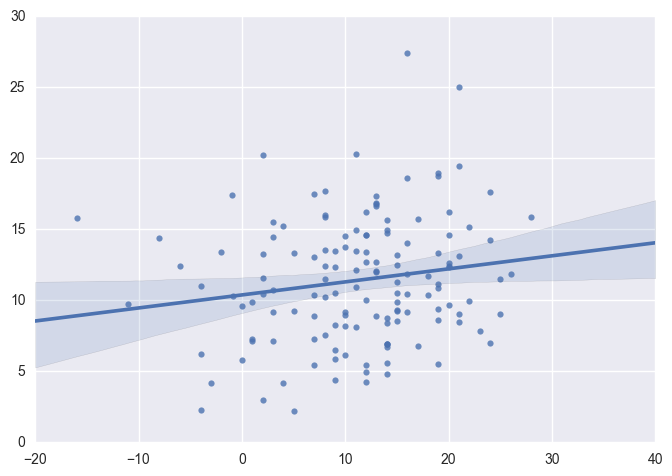

In [313]:
plt.close()
sns.regplot(y[tpso_train.index].values,np.array(predicted))
plt.show()

In [310]:
final_weights = feature_matrix.mean(axis=0)

In [269]:
len([x for x in final_weights if x > 0])

371

In [285]:
tpso_test.shape

(69, 36859)

In [286]:
final_weights.shape

(36859,)

In [311]:
t_predicted = (tpso_test * np.array(final_weights)).sum(axis=1)

In [299]:
t_y = pad.loc[tpso_test.index].tEAO

In [312]:
r,p = stats.pearsonr(t_y[tpso_test.index],t_predicted)
print('final prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))

final prediction accuracy is 5.03258086768 percent 
 p = 0.0638663598874 
 r = 0.224334145142


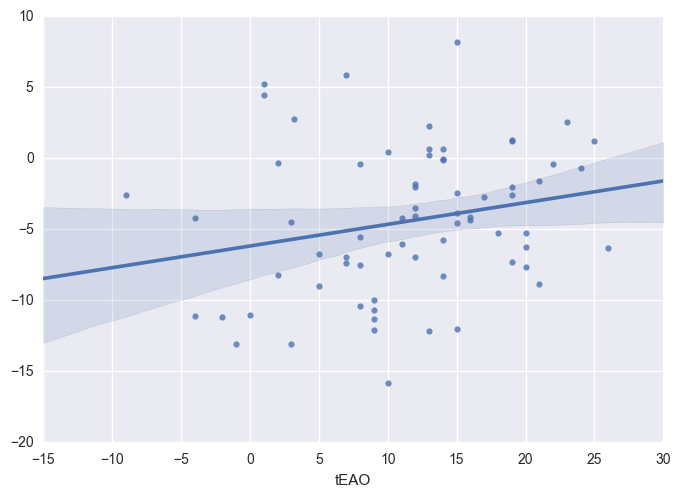

In [314]:
plt.close()
sns.regplot(t_y,np.array(t_predicted))
plt.show()

In [ ]:
jnk = preprocessing.StandardScaler().fit(tpso_train.dropna())
s_tpso_test = jnk.transform(tpso_test.dropna())


In [315]:
final_weights.shape

(36859,)

In [364]:
weight_regs = np.zeros_like(tst_vals)

In [317]:
weight_regs.shape

(272, 272)

In [321]:
(272*271)/2

36856.0

In [365]:
weight_regs[[x[0] for x in itertools.combinations(range(272),2)],
                  [y[1] for y in itertools.combinations(range(272),2)]] = final_weights[:-3]

In [360]:
#weight_regs[[x[1] for x in itertools.combinations(range(272),2)],
#                  [y[0] for y in itertools.combinations(range(272),2)]] = final_weights[:-3]

In [327]:
sns.heatmap?

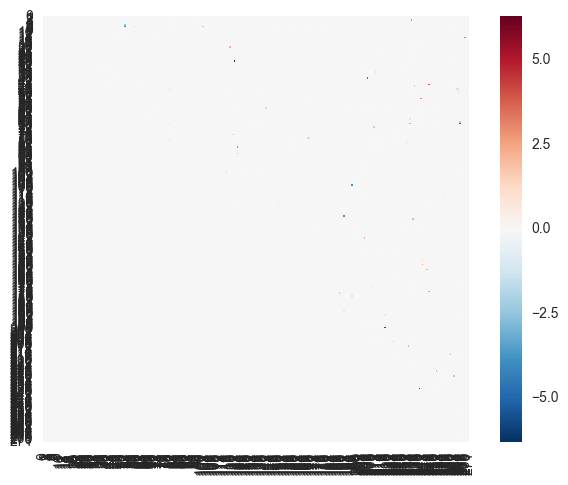

In [366]:
plt.close()
sns.heatmap(weight_regs,square=True)
plt.show()

In [43]:
pp_pth = '/Users/jakevogel/Science/Prevent_AD/rsfmri_bl_avg/Consensus264_Power_Peterson.xls'
pp_regs = pandas.ExcelFile(pp_pth)
pp_regs = pandas.ExcelFile(pp_pth).parse(pp_regs.sheet_names[-1])
pp_regs.columns = ['ROI','Cluster','Network']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jakevogel/Science/Prevent_AD/rsfmri_bl_avg/Consensus264_Power_Peterson.xls'

In [386]:
len(pp_regs)

264

In [393]:
res_regs = [(pp_regs.loc[x]['Network'],
  pp_regs.loc[y]['Network']) for x,y in itertools.combinations(range(272),2) if weight_regs[
                                                                                    x,y] > 0]

In [390]:
active_coords = [(x,y)for x,y in itertools.combinations(range(272),2) if weight_regs[
                                                                                    x,y] > 0]

In [391]:
results = pandas.DataFrame(index=range(len(active_coords)),
                           columns=['X','Y','X_net','Y_net','Value'])

In [394]:
results.X = [x[0] for x in active_coords]
results.Y = [x[1] for x in active_coords]
results.X_net = [x[0] for x in res_regs]
results.Y_net = [x[1] for x in res_regs]
results.Value = [weight_regs[x,y] for x,y in active_coords]

In [397]:
results.sort_values('Value',ascending=False)

X    Y                           X_net                           Y_net  \
211  237  240               Ventral attention               Ventral attention   
96    68  266                        Auditory                          Limbic   
42    39  207        Sensory/somatomotor Hand                        Salience   
55    43  246       Sensory/somatomotor Mouth                       Uncertain   
15    13  269        Sensory/somatomotor Hand                          Limbic   
126   83  124                       Uncertain                    Default mode   
69    52  241  Cingulo-opercular Task Control               Ventral attention   
1      2  235                       Uncertain               Ventral attention   
94    68  234                        Auditory               Ventral attention   
181  175  246    Fronto-parietal Task Control                       Uncertain   
173  158  242                          Visual                      Cerebellar   
175  161  245                          Visual                      Cerebellar   
22    19  119        Sensory/somatomotor Hand                    Default mode   
154  129  236                    Default mode               Ventral attention   
163  141  205                       Uncertain                        Salience   
87    67  266                        Auditory                          Limbic   
130   87  124                    Default mode                    Default mode   
183  176  189    Fronto-parietal Task Control    Fronto-parietal Task Control   
99    70  211                        Auditory                        Salience   
111   77  169                    Default mode                          Visual   
105   75  121                    Default mode                    Default mode   
170  155  242                          Visual                      Cerebellar   
112   77  170                    Default mode                          Visual   
88    68   80                        Auditory                    Default mode   
190  187  192    Fronto-parietal Task Control    Fronto-parietal Task Control   
156  132  141               Memory retrieval?                       Uncertain   
79    65  234                        Auditory               Ventral attention   
67    52   78  Cingulo-opercular Task Control                    Default mode   
33    30   48        Sensory/somatomotor Hand  Cingulo-opercular Task Control   
39    34  173        Sensory/somatomotor Hand    Fronto-parietal Task Control   
..   ...  ...                             ...                             ...   
213  241  266               Ventral attention                          Limbic   
149  120  220                    Default mode               Memory retrieval?   
192  193  219    Fronto-parietal Task Control                        Salience   
207  224  247                     Subcortical                       Uncertain   
92    68  172                        Auditory                          Visual   
8      7  200                       Uncertain    Fronto-parietal Task Control   
77    65   69                        Auditory                        Auditory   
197  207  246                        Salience                       Uncertain   
113   78   80                    Default mode                    Default mode   
123   80  175                    Default mode    Fronto-parietal Task Control   
119   79  132                    Default mode               Memory retrieval?   
162  140  170                       Uncertain                          Visual   
84    66  268                        Auditory                          Limbic   
43    40   66        Sensory/somatomotor Hand                        Auditory   
144  114  201                    Default mode    Fronto-parietal Task Control   
180  173  254    Fronto-parietal Task Control        Sensory/somatomotor Hand   
136   92  242                    Default mode                      Cerebellar   
117   79   85                    Defau

In [411]:
sum(results[results['X']==4]['Value']) + sum(results[results['Y']==4])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [415]:
len(results[results['Y']==4]['Value'])

0

In [416]:
len(results[results['X']==4]['Value'])

2

In [418]:
for i in pp_regs.index:
    xval = results[results['X']==i]['Value']
    yval = results[results['Y']==i]['Value']
    if len(xval) > 0 and len(yval) > 1:
        pp_regs.ix[i,'weight_sum'] = sum(xval) + sum(yval)
    elif len(xval) > 0:
        pp_regs.ix[i,'weight_sum'] = sum(xval)
    elif len(yval) > 0:
        pp_regs.ix[i,'weight_sum'] = sum(xval)
    else:
        pp_regs.ix[i,'weight_sum'] = 0

In [420]:
pp_regs.head()

ROI  Cluster    Network  weight_sum
0    1       -1  Uncertain    0.031565
1    2       -1  Uncertain    0.000000
2    3       -1  Uncertain    2.996628
3    4       -1  Uncertain    0.000000
4    5       -1  Uncertain    0.347487

In [458]:
jnk = ni.load(
    '/Users/jakevogel/Science/Prevent_AD/rsfmri_bl_avg/power_peterson/power_peterson_atlas.nii')
pp_atl = jnk.get_data().astype(int)
aff = jnk.affine

In [444]:
np.unique(pp_atl)[-10:]

memmap([529, 530, 531, 532, 533, 534, 535, 536, 659, 661])

In [459]:
to_change = np.unique(pp_atl)[-10:]
to_change_to = list(set(range(274)) - set(np.unique(pp_atl)))
for i in range(len(to_change_to)):
    pp_atl[pp_atl==to_change[i]] = to_change_to[i]

In [461]:
pp_atl = pp_atl.astype(float)

In [462]:
for i in np.unique(pp_atl)[1:273]:
    pp_atl[pp_atl==i] = pp_regs[pp_regs['ROI']==i]['weight_sum'].values[0]

In [463]:
pp_regs[pp_regs['ROI']==1.0]['weight_sum'].values[0]

0.031564624134804167

In [464]:
nimg = ni.Nifti1Image(pp_atl,aff)
nimg.to_filename(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/feature_weight_sums')

In [ ]:
###USING A SMALLER GRAPH THEORY MATRIX WITH HIGHER RESOLUTION... (SAME AS PAPER)

In [44]:
ld_05 = pandas.read_csv(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/fmri/LD_analyses/sc444_link_densities.dat')
ld_05.head()

Column 1  Unnamed: 0 Unnamed: 0.1  Gender  Age     FD  ApoE4_status  tPSO  \
0         0  s108583NAP   s108583NAP       0   67  0.256             0   -11   
1         1  s113451NAP   s113451NAP       0   63  0.240             0   -22   
2         2  s115095PRE   s115095PRE       1   64  0.183             1     4   
3         3  s122650PRE   s122650PRE       0   72  0.289             0    -8   
4         4  s139940PRE   s139940PRE       0   56  0.248             0   -16   

   p0_dens  p1_dens          ...           network6_density  network7_density  \
0       11       10          ...                   0.099394          0.083539   
1       13       24          ...                   0.115960          0.105935   
2       11       20          ...                   0.084242          0.088914   
3       17       19          ...                   0.082222          0.090705   
4       40       54          ...                   0.064040          0.114670   

   participation_coefficient_hippocampus  Predicted p220_dens  \
0                               0.660494            22.955600   
1                               0.718226            19.801915   
2                               0.666667            30.860591   
3                               0.197531            22.216377   
4                               0.627219            24.205445   

   Residual p220_dens  Predicted tPSO  Residual tPSO  \
0           -5.537332       -9.601491      -1.398509   
1           18.906619      -11.683144     -10.316856   
2           13.842439       -9.710314      13.710314   
3          -13.674899       -6.897696      -1.102304   
4          -11.602974      -15.044325      -0.955675   

   Residual network5_density  Residual participation_coefficient_hippocampus  \
0                  -0.029140                                        0.107467   
1                   0.096039                                        0.151842   
2                  -0.035617                                        0.074754   
3                  -0.010514                                       -0.336075   
4                  -0.000218                                        0.045005   

   Residual p220_dens 2  
0             -4.955600  
1             23.198085  
2              8.139409  
3            -13.216377  
4            -11.205445  

[5 rows x 467 columns]

In [45]:
ld_05.index = ld_05[ld_05.columns[1]]

In [46]:
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx')
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx').parse(jnk.sheet_names[0])
jnk.index = jnk.CandID

In [47]:
nids = []
for sid in ld_05.index:
    nids.append(jnk.loc[int(sid[1:7])][jnk.columns[0]])
ld_05.index = nids

In [33]:
ld_05.head()

Column 1  Unnamed: 0 Unnamed: 0.1  Gender  Age     FD  ApoE4_status  \
MTL0392         0  s108583NAP   s108583NAP       0   67  0.256             0   
MTL0415         1  s113451NAP   s113451NAP       0   63  0.240             0   
MTL0380         2  s115095PRE   s115095PRE       1   64  0.183             1   
MTL0008         3  s122650PRE   s122650PRE       0   72  0.289             0   
MTL0449         4  s139940PRE   s139940PRE       0   56  0.248             0   

         tPSO  p0_dens  p1_dens          ...           network6_density  \
MTL0392   -11       11       10          ...                   0.099394   
MTL0415   -22       13       24          ...                   0.115960   
MTL0380     4       11       20          ...                   0.084242   
MTL0008    -8       17       19          ...                   0.082222   
MTL0449   -16       40       54          ...                   0.064040   

         network7_density  participation_coefficient_hippocampus  \
MTL0392          0.083539                               0.660494   
MTL0415          0.105935                               0.718226   
MTL0380          0.088914                               0.666667   
MTL0008          0.090705                               0.197531   
MTL0449          0.114670                               0.627219   

         Predicted p220_dens  Residual p220_dens  Predicted tPSO  \
MTL0392            22.955600           -5.537332       -9.601491   
MTL0415            19.801915           18.906619      -11.683144   
MTL0380            30.860591           13.842439       -9.710314   
MTL0008            22.216377          -13.674899       -6.897696   
MTL0449            24.205445          -11.602974      -15.044325   

         Residual tPSO  Residual network5_density  \
MTL0392      -1.398509                  -0.029140   
MTL0415     -10.316856                   0.096039   
MTL0380      13.710314                  -0.035617   
MTL0008      -1.102304                  -0.010514   
MTL0449      -0.955675                  -0.000218   

         Residual participation_coefficient_hippocampus  Residual p220_dens 2  
MTL0392                                        0.107467             -4.955600  
MTL0415                                        0.151842             23.198085  
MTL0380                                        0.074754              8.139409  
MTL0008                                       -0.336075            -13.216377  
MTL0449                                        0.045005            -11.205445  

[5 rows x 467 columns]

In [48]:
ld_subs = ld_05[ld_05.columns[8:459].tolist() + ld_05.columns[3:6].tolist()]

In [49]:
ld_train_ids,ld_test_ids = balance_cohorts(ld_05,'tPSO',2)

In [50]:
ld_train = ld_subs.loc[ld_train_ids]
ld_train.columns = range(len(ld_train.columns))
ld_test = ld_subs.loc[ld_test_ids]
ld_train.columns = range(len(ld_train.columns))

In [37]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/ld_0p05/'
ld_weights, ld_predicted, ldtest_predicted, ld_wmtx = loo_feature_learning(
                                                    ld_train,ld_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

KeyboardInterrupt: 

In [666]:
print('length is ', len(ld_weights))
print('# features: ',len([i for i in ld_weights.index if abs(ld_weights[i]) > 0 ]))
[i for i in ld_weights.index if abs(ld_weights[i]) > 0 ]

454
57


[25,
 33,
 43,
 52,
 68,
 71,
 77,
 82,
 85,
 87,
 94,
 105,
 108,
 127,
 130,
 138,
 145,
 149,
 158,
 160,
 161,
 179,
 186,
 201,
 204,
 210,
 220,
 221,
 224,
 247,
 249,
 255,
 257,
 273,
 279,
 281,
 282,
 284,
 294,
 316,
 319,
 324,
 333,
 351,
 358,
 370,
 373,
 387,
 392,
 394,
 398,
 399,
 404,
 409,
 418,
 435,
 452]

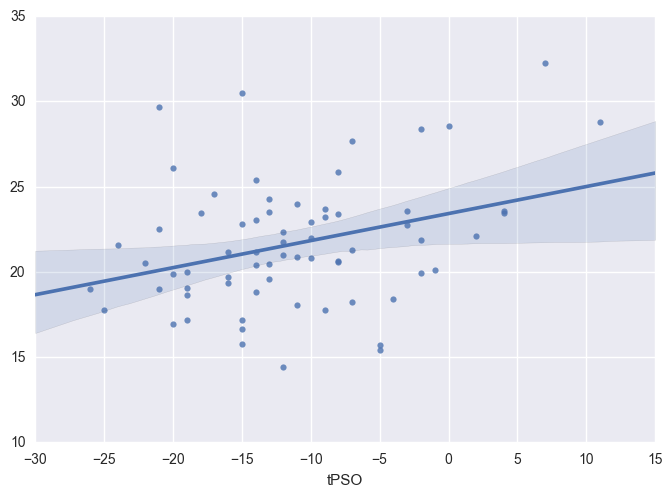

In [521]:
plt.close()
sns.regplot(ldt_y,np.array(ldtest_predicted))
plt.show()

In [51]:
hits = [i for i in ld_weights.index[0:443] if ld_weights[i] > 0 ]

NameError: name 'ld_weights' is not defined

In [546]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)

In [547]:
for i in ld_weights.index[0:443]:
    if i in hits:
        sc444[sc444==i+1] = ld_weights[i]
    else:
        sc444[sc444==i+1] = 0

In [554]:
sc444[sc444==444]=0

In [555]:
sc444[sc444==444]=0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_0p05_sig')

In [715]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.005
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/ld_0p005_cov/'
ld3_weights, ld3_predicted, ld3test_predicted, ld3_wmtx = loo_feature_learning(
                                                    ld_train,ld_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [716]:
print('length is ', len(ld3_weights))
print('# features: ',len([i for i in ld3_weights.index if abs(ld3_weights[i]) > 0 ]))
[i for i in ld3_weights.index if abs(ld3_weights[i]) > 0 ]

length is  454
# features:  12


[25, 33, 43, 105, 138, 186, 247, 279, 282, 351, 404, 452]

In [719]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.005
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/ld_0p005_nocov/'
ld4_weights, ld4_predicted, ld4test_predicted, ld4_wmtx = loo_feature_learning(
                                                    ld2_train,ld2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [52]:
### Cool!! Now lets put GM into the picture as well! (We'll do alone after, maybe?)
gm_df = pandas.read_csv(
    '/Users/jakevogel/Science/Prevent_AD/prevent_ad_gm/gm_sc444_regs_allsubs.csv')
gm_df.index = gm_df[gm_df.columns[0]]
gm_df.drop(gm_df.columns[0],axis=1,inplace=True)
gm_df.columns = ['gm_'+str(x) for x in gm_df.columns]

In [39]:
gm_df.head()

gm_1      gm_2      gm_3      gm_4      gm_5      gm_6  \
Unnamed: 0                                                               
108583      0.270810  0.517696  0.284254  0.429454  0.230133  0.236168   
108647      0.372945  0.462944  0.388638  0.388192  0.214446  0.295370   
113451      0.335714  0.491541  0.298433  0.388793  0.262634  0.283949   
115095      0.242070  0.362949  0.253745  0.323204  0.182319  0.199822   
117603      0.297635  0.445276  0.334450  0.367517  0.248444  0.208789   

                gm_7      gm_8      gm_9     gm_10    ...       gm_435  \
Unnamed: 0                                            ...                
108583      0.366993  0.318232  0.372038  0.370605    ...     0.325910   
108647      0.422144  0.324361  0.386622  0.411557    ...     0.384267   
113451      0.363120  0.285286  0.436677  0.336310    ...     0.377305   
115095      0.340984  0.321841  0.326153  0.387503    ...     0.331565   
117603      0.348473  0.306757  0.452382  0.356338    ...     0.382931   

              gm_436    gm_437    gm_438    gm_439    gm_440    gm_441  \
Unnamed: 0                                                               
108583      0.270781  0.244879  0.465207  0.365950  0.304884  0.497788   
108647      0.308715  0.379058  0.498751  0.454936  0.348185  0.379265   
113451      0.273988  0.357982  0.527663  0.383917  0.306147  0.359034   
115095      0.233493  0.280626  0.472643  0.288025  0.301921  0.311577   
117603      0.269660  0.315674  0.542407  0.346028  0.315855  0.312712   

              gm_442    gm_443    gm_444  
Unnamed: 0                                
108583      0.343778  0.220914  0.300537  
108647      0.405114  0.302668  0.314080  
113451      0.353903  0.272264  0.287944  
115095      0.271545  0.240689  0.245791  
117603      0.356590  0.277170  0.288631  

[5 rows x 444 columns]

In [53]:
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx')
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx').parse(jnk.sheet_names[0])
jnk.index = jnk.CandID

nids = []
for sid in gm_df.index:
    nids.append(jnk.loc[int(sid)][jnk.columns[0]])
gm_df.index = nids

In [54]:
mm_train = pandas.concat([ld_train,gm_df.loc[ld_train.index]],axis=1)
mm_test = pandas.concat([ld_test,gm_df.loc[ld_test.index]],axis=1)

mm_train.columns = range(len(mm_train.columns))
mm_test.columns = range(len(mm_test.columns))

In [576]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p05/'
mm_weights, mm_predicted, mmtest_predicted, mm_wmtx = loo_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [577]:
#mm_train

In [580]:
[i for i in mm_weights.index if mm_weights[i] > 0 ]

[25,
 43,
 71,
 85,
 87,
 94,
 105,
 130,
 160,
 161,
 179,
 201,
 220,
 221,
 247,
 255,
 281,
 324,
 351,
 370,
 373,
 399,
 404,
 409,
 418,
 452]

In [55]:
# JUST GM
gm_train = gm_df.loc[ld_train.index]
gm_test = gm_df.loc[ld_test.index]

gm_train.columns = range(len(gm_train.columns))
gm_test.columns = range(len(gm_test.columns))

In [584]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p05/'
gm_weights, gm_predicted, gmtest_predicted, gm_wmtx = loo_feature_learning(
                                                    gm_train,gm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  0
running correlation for  1
running lasso for  1


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  1
running correlation for  2
running lasso for  2


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  2
running correlation for  3
running lasso for  3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  3
running correlation for  4
running lasso for  4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  4
running correlation for  5
running lasso for  5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  5
running correlation for  6
running lasso for  6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  6
running correlation for  7
running lasso for  7


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  7
running correlation for  8
running lasso for  8


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  8
running correlation for  9
running lasso for  9


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  9
running correlation for  10
running lasso for  10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  10
running correlation for  11
running lasso for  11


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  11
running correlation for  12
running lasso for  12


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  12
running correlation for  13
running lasso for  13


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  13
running correlation for  14
running lasso for  14


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  14
running correlation for  15
running lasso for  15


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  15
running correlation for  16
running lasso for  16


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  16
running correlation for  17
running lasso for  17


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  17
running correlation for  18
running lasso for  18


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  18
running correlation for  19
running lasso for  19


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  19
running correlation for  20
running lasso for  20


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  20
running correlation for  21
running lasso for  21


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  21
running correlation for  22
running lasso for  22


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  22
running correlation for  23
running lasso for  23


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  23
running correlation for  24
running lasso for  24


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  24
running correlation for  25
running lasso for  25


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  25
running correlation for  26
running lasso for  26


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  26
running correlation for  27
running lasso for  27


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  27
running correlation for  28
running lasso for  28


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  28
running correlation for  29
running lasso for  29


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  29
running correlation for  30
running lasso for  30


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  30
running correlation for  31
running lasso for  31


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  31
running correlation for  32
running lasso for  32


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  32
running correlation for  33
running lasso for  33


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  33
running correlation for  34
running lasso for  34


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  34
running correlation for  35
running lasso for  35


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  35
running correlation for  36
running lasso for  36


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  36
running correlation for  37
running lasso for  37


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  37
running correlation for  38
running lasso for  38


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  38
running correlation for  39
running lasso for  39


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  39
running correlation for  40
running lasso for  40


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  40
running correlation for  41
running lasso for  41


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  41
running correlation for  42
running lasso for  42


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  42
running correlation for  43
running lasso for  43


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  43
running correlation for  44
running lasso for  44


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  44
running correlation for  45
running lasso for  45


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  45
running correlation for  46
running lasso for  46


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  46
running correlation for  47
running lasso for  47


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  47
running correlation for  48
running lasso for  48


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  48
running correlation for  49
running lasso for  49


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  49
running correlation for  50
running lasso for  50


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  50
running correlation for  51
running lasso for  51


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  51
running correlation for  52
running lasso for  52


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  52
running correlation for  53
running lasso for  53


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  53
running correlation for  54
running lasso for  54


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  54
running correlation for  55
running lasso for  55


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  55
running correlation for  56
running lasso for  56


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  56
running correlation for  57
running lasso for  57


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  57
running correlation for  58
running lasso for  58


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  58
running correlation for  59
running lasso for  59


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  59
running correlation for  60
running lasso for  60


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  60
running correlation for  61
running lasso for  61


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  61
running correlation for  62
running lasso for  62


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  62
running correlation for  63
running lasso for  63


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  63
running correlation for  64
running lasso for  64


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  64
running correlation for  65
running lasso for  65


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  65
running correlation for  66
running lasso for  66


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  66
running correlation for  67
running lasso for  67


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  67
running correlation for  68
running lasso for  68


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  68
running correlation for  69
running lasso for  69


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  69
running correlation for  70
running lasso for  70


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  70
running correlation for  71
running lasso for  71


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  71
running correlation for  72
running lasso for  72


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  72
running correlation for  73
running lasso for  73


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  73
running correlation for  74
running lasso for  74


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  74
running correlation for  75
running lasso for  75


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  75
running correlation for  76
running lasso for  76


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  76
running correlation for  77
running lasso for  77


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  77
running correlation for  78
running lasso for  78


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  78
running correlation for  79
running lasso for  79


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  79
running correlation for  80
running lasso for  80


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  80
running correlation for  81
running lasso for  81


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  81
running correlation for  82
running lasso for  82


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  82
running correlation for  83
running lasso for  83


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  83
running correlation for  84
running lasso for  84


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  84
running correlation for  85
running lasso for  85


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  85
running correlation for  86
running lasso for  86


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  86
running correlation for  87
running lasso for  87


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  87
running correlation for  88
running lasso for  88


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  88
running correlation for  89
running lasso for  89


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  89
running correlation for  90
running lasso for  90


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  90
running correlation for  91
running lasso for  91


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  91
running correlation for  92
running lasso for  92


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  92
running correlation for  93
running lasso for  93


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  93
running correlation for  94
running lasso for  94


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  94
running correlation for  95
running lasso for  95


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  95
running correlation for  96
running lasso for  96


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  96
running correlation for  97
running lasso for  97


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  97
running correlation for  98
running lasso for  98


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  98
running correlation for  99
running lasso for  99


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  99
running correlation for  100
running lasso for  100


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  100
running correlation for  101
running lasso for  101


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  101
running correlation for  102
running lasso for  102


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  102
running correlation for  103
running lasso for  103


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  103
running correlation for  104
running lasso for  104


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  104
running correlation for  105
running lasso for  105


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  105
running correlation for  106
running lasso for  106


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  106
running correlation for  107
running lasso for  107


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  107
running correlation for  108
running lasso for  108


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  108
running correlation for  109
running lasso for  109


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  109
running correlation for  110
running lasso for  110


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  110
running correlation for  111
running lasso for  111


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  111
running correlation for  112
running lasso for  112


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  112
running correlation for  113
running lasso for  113


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  113
running correlation for  114
running lasso for  114


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  114
running correlation for  115
running lasso for  115


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  115
running correlation for  116
running lasso for  116


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  116
running correlation for  117
running lasso for  117


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  117
running correlation for  118
running lasso for  118


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  118
running correlation for  119
running lasso for  119


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  119
running correlation for  120
running lasso for  120


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  120
running correlation for  121
running lasso for  121


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  121
running correlation for  122
running lasso for  122


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  122
running correlation for  123
running lasso for  123


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  123
running correlation for  124
running lasso for  124


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  124
running correlation for  125
running lasso for  125


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  125
running correlation for  126
running lasso for  126


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  126
running correlation for  127
running lasso for  127


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  127
running correlation for  128
running lasso for  128


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  128
running correlation for  129
running lasso for  129


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  129
running correlation for  130
running lasso for  130


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  130
running correlation for  131
running lasso for  131


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  131
running correlation for  132
running lasso for  132


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  132
running correlation for  133
running lasso for  133


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  133
running correlation for  134
running lasso for  134


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  134
running correlation for  135
running lasso for  135


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  135
running correlation for  136
running lasso for  136


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  136
running correlation for  137
running lasso for  137


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


saving matrix  137
0 feature_selected
validation prediction accuracy is 2.34940417531 percent 
 p = 0.0726778762164 
 r = 0.153277662277
testing prediction accuracy is 8.5309140195 percent 
 p = 0.0156562200049 
 r = 0.292077284627


In [667]:
print('length is ', len(gm_weights))
print('# features: ',len([i for i in gm_weights.index if abs(gm_weights[i]) > 0 ]))
[i for i in gm_weights.index if abs(gm_weights[i]) > 0 ]

length is  444
# features:  10


[10, 18, 96, 131, 137, 232, 239, 249, 294, 330]

In [660]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.005
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/gm_0p005/'
gm3_weights, gm3_predicted, gm3test_predicted, gm3_wmtx = loo_feature_learning(
                                                    gm_train,gm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [720]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.001
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/gm_0p001/'
gm4_weights, gm4_predicted, gm4test_predicted, gm4_wmtx = loo_feature_learning(
                                                    gm2_train,gm2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [724]:
print('length is ', len(gm3_weights))
print('# features: ',len([i for i in gm3_weights.index if abs(gm3_weights[i]) > 0 ]))
hits = [i for i in gm3_weights.index if abs(gm3_weights[i]) > 0 ]
hits

length is  444
# features:  13


[10, 18, 96, 131, 137, 143, 201, 232, 239, 242, 249, 294, 330]

In [723]:
print('length is ', len(gm4_weights))
print('# features: ',len([i for i in gm4_weights.index if abs(gm4_weights[i]) > 0 ]))
[i+1 for i in gm4_weights.index if abs(gm4_weights[i]) > 0 ]

length is  446
# features:  12


[19, 24, 132, 138, 143, 202, 243, 250, 295, 331, 385, 445]

In [726]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)

In [727]:
for i in gm3_weights.index[0:444]:
    if i in hits:
        sc444[sc444==i+1] = gm3_weights[i]
    else:
        sc444[sc444==i+1] = 0

In [728]:
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_0p001_cov_sig')

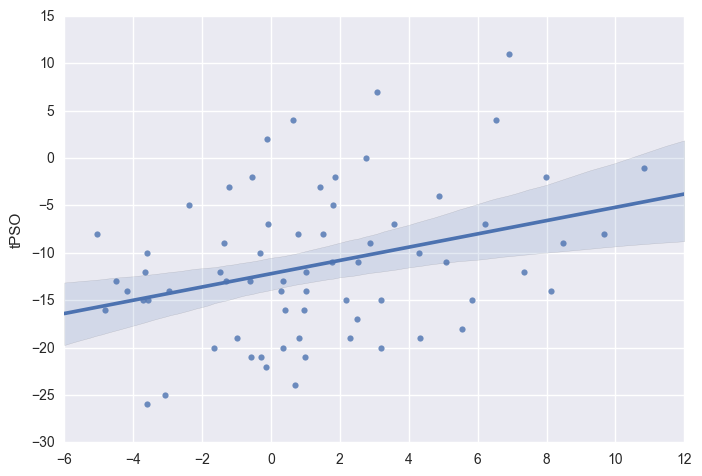

In [736]:
plt.close()
sns.regplot(np.array(gm4test_predicted),ldt_y,)
plt.show()

In [ ]:
jnk = preprocessing.StandardScaler().fit(gm2_train)
s_gm2_test = jnk.transform(gm2_test)

In [734]:
s_gm4test_predicted = (s_gm2_test * np.array(gm4_weights)).sum(axis=1)

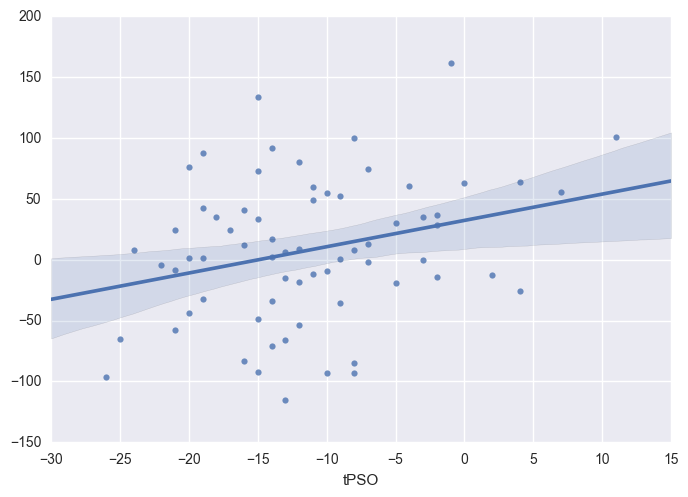

In [735]:
plt.close()
sns.regplot(ldt_y,np.array(s_gm4test_predicted))
plt.show()

In [669]:
set(
    [i for i in gm3_weights.index if abs(gm3_weights[i]) > 0 ]
    ) - set(
        [i for i in gm_weights.index if abs(gm_weights[i]) > 0 ])

{143, 201, 242}

In [56]:
gm2_train = deepcopy(gm_train)
gm2_test = deepcopy(gm_test)

In [57]:
gm2_train.ix[:,'Age'] = ld_05.loc[gm2_train.index].Age
gm2_train.ix[:,"Gender"] = ld_05.loc[gm2_train.index].Gender
gm2_test.ix[:,'Age'] = ld_05.loc[gm2_test.index].Age
gm2_test.ix[:,"Gender"] = ld_05.loc[gm2_test.index].Gender
gm2_train.columns = range(len(gm2_train.columns))
gm2_test.columns = range(len(gm2_test.columns))

In [596]:
ldy = ld_05.loc[gm2_train.index].tPSO
ldt_y = ld_05.loc[gm2_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/gm_0p05_cov//'
gm2_weights, gm2_predicted, gm2test_predicted, gm2_wmtx = loo_feature_learning(
                                                    gm2_train,gm2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [630]:
[i for i in range(len(gm2_weights)) if gm2_weights[i]>0]

[444]

In [58]:
ld2_train = ld_train[ld_train.columns[:-9]]
ld2_test = ld_test[ld_test.columns[:-9]]

In [601]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/ld_0p05_no_cov/'
ld2_weights, ld2_predicted, ld2test_predicted, ld2_wmtx = loo_feature_learning(
                                                    ld2_train,ld2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [670]:
print('length is ', len(gm2_weights))
print('# features: ',len([i for i in gm2_weights.index if abs(gm2_weights[i]) > 0 ]))
[i for i in gm2_weights.index if abs(gm2_weights[i]) > 0 ]

length is  446
# features:  6


[18, 131, 239, 294, 330, 444]

In [59]:
jnk = deepcopy(gm2_train)
jnk.columns = ['gm_'+str(x) for x in jnk.columns]
jnk2 = deepcopy(ld2_train)
jnk2.columns = ['ld_'+str(x) for x in jnk2.columns]
mm_train = pandas.concat([jnk,jnk2],axis=1)
mm_train.columns = range(len(mm_train.columns))
jnk = deepcopy(gm2_test)
jnk.columns = ['gm_'+str(x) for x in jnk.columns]
jnk2 = deepcopy(ld2_test)
jnk2.columns = ['ld_'+str(x) for x in jnk2.columns]
mm_test = pandas.concat([jnk,ld2_test],axis=1)
mm_test.columns = range(len(mm_test.columns))

In [639]:
#ld2_train

In [617]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p05/'
mm_weights, mm_predicted, mmtest_predicted, mm_wmtx = loo_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [672]:
print('length is ', len(mm_weights))
print('# features: ',len([i for i in mm_weights.index if abs(mm_weights[i]) > 0 ]))
[i for i in mm_weights.index if abs(mm_weights[i]) > 0 ]

length is  891
# features:  57


[444,
 471,
 479,
 489,
 498,
 514,
 517,
 523,
 528,
 531,
 533,
 540,
 551,
 554,
 573,
 576,
 584,
 591,
 595,
 604,
 606,
 607,
 625,
 632,
 647,
 650,
 656,
 666,
 667,
 670,
 693,
 695,
 701,
 703,
 719,
 725,
 727,
 728,
 730,
 740,
 762,
 765,
 770,
 779,
 797,
 804,
 816,
 819,
 833,
 838,
 840,
 844,
 845,
 850,
 855,
 864,
 881]

In [60]:
mm2_train = deepcopy(mm_train)
mm2_test = deepcopy(mm_test)
mm2_train.ix[:,'Age'] = ld_05.loc[mm2_train.index].Age
mm2_train.ix[:,"Gender"] = ld_05.loc[mm2_train.index].Gender
mm2_test.ix[:,'Age'] = ld_05.loc[mm2_test.index].Age
mm2_test.ix[:,"Gender"] = ld_05.loc[mm2_test.index].Gender
mm2_train.columns = range(len(mm2_train.columns))
mm2_test.columns = range(len(mm2_test.columns))

In [621]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p05_cov/'
mm2_weights, mm2_predicted, mm2test_predicted, mm2_wmtx = loo_feature_learning(
                                                    mm2_train,mm2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [622]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.005
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p005_cov/'
mm2_weights, mm2_predicted, mm2test_predicted, mm2_wmtx = loo_feature_learning(
                                                    mm2_train,mm2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [674]:
print('length is ', len(mm2_weights))
print('# features: ',len([i for i in mm2_weights.index if abs(mm2_weights[i]) > 0 ]))
[i for i in mm2_weights.index if abs(mm2_weights[i]) > 0 ]

length is  893
# features:  24


[18,
 58,
 131,
 137,
 173,
 239,
 242,
 249,
 294,
 330,
 403,
 444,
 471,
 479,
 489,
 551,
 584,
 632,
 693,
 725,
 728,
 797,
 850,
 891]

In [624]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.001
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p001_cov/'
mm4_weights, mm4_predicted, mm4test_predicted, mm4_wmtx = loo_feature_learning(
                                                    mm2_train,mm2_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [675]:
print('length is ', len(mm4_weights))
print('# features: ',len([i for i in mm4_weights.index if abs(mm4_weights[i]) > 0 ]))
[i for i in mm4_weights.index if abs(mm4_weights[i]) > 0 ]

length is  893
# features:  15


[18, 23, 131, 137, 142, 201, 242, 249, 294, 330, 384, 444, 584, 693, 891]

In [677]:
693-443

250

In [643]:
len(mm4_weights)
[i for i in mm4_weights.index if mm4_weights[i] > 0 ]

[444, 693, 891]

In [629]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.005
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p005_nocov//'
mm5_weights, mm5_predicted, mm5test_predicted, mm5_wmtx = loo_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [680]:
for x in [i for i in mm5_weights.index if abs(mm5_weights[i]) > 0 ]:
    if x > 443:
        print(x-443)
    else:
        print(x+1)

19
59
132
138
174
240
243
250
295
331
404
1
28
36
46
108
141
189
250
282
285
354
407


In [48]:
cog_cols = pad.columns.tolist()[100:105]

In [49]:
pad.loc[mm_test.index][cog_cols[col]]

NameError: name 'col' is not defined

In [51]:
mm4_full_predict = (pandas.concat([mm2_train,mm2_test]) * np.array(mm4_weights)).sum(axis=1)

NameError: name 'mm4_weights' is not defined

In [50]:
for col in cog_cols:
    cy = pad.loc[mm4_full_predict.index][col]
    x = mm4_full_predict
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(x.drop(nan_subs).values,cy.drop(nan_subs).values))

NameError: name 'mm4_full_predict' is not defined

In [708]:
gm3_full_predict = (pandas.concat([gm_train,gm_test]) * np.array(gm3_weights)).sum(axis=1)
for col in cog_cols:
    cy = pad.loc[gm3_full_predict.index][col]
    x = gm4_full_predict
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(x.drop(nan_subs).values,cy.drop(nan_subs).values))

immediate_memory_index_score (0.049602622394397611, 0.49904240575525105)
visuospatial_constructional_index_score (-0.036899083018321302, 0.6151528974683329)
lang (0.14306727129151453, 0.050154470551911995)
attention_index_score (-0.13001875293495394, 0.07533911798419568)
delayed_memory_index_score (-0.069866393249683745, 0.34072407557145201)


In [714]:
for col in cog_cols:
    cy = pad.loc[mm4_full_predict.index][col]
    x = pad.loc[mm4_full_predict.index]['tEAO']
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(x.drop(nan_subs).values,cy.drop(nan_subs).values))

immediate_memory_index_score (0.053293929343756159, 0.46761047204170103)
visuospatial_constructional_index_score (-0.023897607313357182, 0.7447810041067171)
lang (-0.045292878990878395, 0.53710302289675194)
attention_index_score (0.12600095793356023, 0.084890426749990242)
delayed_memory_index_score (0.089594760535599963, 0.22143205620328074)


In [709]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.001
out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/mm_0p001_nocov//'
mm5_weights, mm5_predicted, mm5test_predicted, mm5_wmtx = loo_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y,p_cutoff,
                                                    out_dir,output='heavy')

running correlation for  0
running lasso for  0
saving matrix  0
running correlation for  1
running lasso for  1
saving matrix  1
running correlation for  2
running lasso for  2
saving matrix  2
running correlation for  3
running lasso for  3
saving matrix  3
running correlation for  4
running lasso for  4
saving matrix  4
running correlation for  5
running lasso for  5
saving matrix  5
running correlation for  6
running lasso for  6
saving matrix  6
running correlation for  7
running lasso for  7
saving matrix  7
running correlation for  8
running lasso for  8
saving matrix  8
running correlation for  9
running lasso for  9
saving matrix  9
running correlation for  10
running lasso for  10
saving matrix  10
running correlation for  11
running lasso for  11
saving matrix  11
running correlation for  12
running lasso for  12
saving matrix  12
running correlation for  13
running lasso for  13
saving matrix  13
running correlation for  14
running lasso for  14
saving matrix  14
running co

In [710]:
print('length is ', len(mm5_weights))
print('# features: ',len([i for i in mm5_weights.index if abs(mm5_weights[i]) > 0 ]))
[i for i in mm5_weights.index if abs(mm5_weights[i]) > 0 ]

length is  891
# features:  14


[18, 23, 131, 137, 142, 201, 242, 249, 294, 330, 384, 444, 584, 693]

tEAO (-0.38971649414472737, 7.0383769318361958e-09)


In [739]:
#OKAY NOW IM GOING TO TRY TO SEE IF I CAN IMPROVE THE MODEL WITH KFOLD

a: [1, 2, 3, 4, 5]
b: [1, 2, 3, 4, 5]
a: [1, 2, 3, 4, 5]
b: [1, 2, 3, 'poop', 5]


In [840]:
gm_train

444

In [865]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kgm_weights, kgm_predicted, kgmtest_predicted = kfold_feature_learning(
                                                    gm_train,gm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)


running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running lasso for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running lasso for fold 3 of 3
9 features selected
validation prediction accuracy is 64.3333575634 percent 
 p = 3.03569285339e-32 
 r = -0.802080778746
testing prediction accuracy is 7.43522086594 percent 
 p = 0.0244697971245 
 r = 0.272676014089


In [843]:
print('length is ', len(kgm_weights))
print('# features: ',len([i for i in kgm_weights.index if abs(kgm_weights[i]) > 0 ]))
[i for i in kgm_weights.index if abs(kgm_weights[i]) > 0 ]

length is  444
# features:  9


[75, 96, 137, 142, 242, 294, 330, 351, 390]

In [852]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kld_weights, kld_predicted, kldtest_predicted = kfold_feature_learning(
                                                    ld_train,ld_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)



running correlation for fold 1 of 3
running lasso for fold 1 of 3
running correlation for fold 2 of 3
running lasso for fold 2 of 3
running correlation for fold 3 of 3
running lasso for fold 3 of 3
43 features selected
validation prediction accuracy is 28.0893359121 percent 
 p = 2.31380875844e-11 
 r = -0.529993734983
testing prediction accuracy is 16.0248956368 percent 
 p = 0.000718347015395 
 r = 0.4003110745


In [850]:
print('length is ', len(kld_weights))
print('# features: ',len([i for i in kld_weights.index if abs(kld_weights[i]) > 0 ]))
[i for i in kld_weights.index if abs(kld_weights[i]) > 0 ]

length is  454
# features:  43


In [862]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kld_weights2, kld_predicted2, kldtest_predicted2 = kfold_feature_learning(
                                                    ld2_train,ld2_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=False)


running correlation for fold 1 of 3
running lasso for fold 1 of 3
running correlation for fold 2 of 3
running lasso for fold 2 of 3
running correlation for fold 3 of 3
running lasso for fold 3 of 3
40 features selected
validation prediction accuracy is 34.1879170593 percent 
 p = 5.08576263143e-14 
 r = -0.584704344599
testing prediction accuracy is 9.25964593278 percent 
 p = 0.0116387628363 
 r = 0.304296663353


In [447]:
jnk = np.arange(10)
print(jnk)
jnk += 2
print(jnk)

[0 1 2 3 4 5 6 7 8 9]
[ 2  3  4  5  6  7  8  9 10 11]


In [61]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmm_weights, kmm_predicted, kmmtest_predicted, allint = kfold_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)



running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


intercept: -7.43852050159
running correlation for fold 2 of 3
running lasso for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


intercept: -10.9884260747
running correlation for fold 3 of 3
running lasso for fold 3 of 3
intercept: -15.652833418
53 features selected
validation prediction accuracy is 30.7951582585 percent 
 p = 1.63155802435e-12 
 r = -0.554933854243
testing prediction accuracy is 20.8732967161 percent 
 p = 8.99103171172e-05 
 r = 0.456873031773


In [85]:
mm_test

0         1         2         3         4         5         6    \
MTL0064  0.378133  0.492304  0.381431  0.414518  0.270905  0.292067  0.391375   
MTL0404  0.340470  0.449991  0.282091  0.403205  0.280466  0.244894  0.436069   
MTL0032  0.289263  0.476600  0.302455  0.454330  0.220210  0.271170  0.352199   
MTL0246  0.318055  0.408140  0.313574  0.356123  0.195134  0.221391  0.332674   
MTL0349  0.225019  0.386179  0.266961  0.332722  0.236564  0.238810  0.348866   
MTL0343  0.280443  0.425485  0.271096  0.333365  0.236316  0.243857  0.330831   
MTL0394  0.398932  0.517833  0.346472  0.413354  0.223583  0.267316  0.400843   
MTL0135  0.301313  0.420820  0.346520  0.382605  0.240792  0.222520  0.334086   
MTL0124  0.279470  0.415254  0.258325  0.342387  0.276298  0.197035  0.344219   
MTL0350  0.365851  0.463397  0.331259  0.405594  0.208154  0.223224  0.398179   
MTL0276  0.261611  0.373682  0.251301  0.306408  0.211302  0.163676  0.323764   
MTL0308  0.270703  0.392119  0.241978  0.378732  0.179287  0.171127  0.325751   
MTL0204  0.308493  0.464275  0.281033  0.369726  0.192172  0.282914  0.399230   
MTL0360  0.332297  0.468332  0.278289  0.369494  0.233038  0.246883  0.369528   
MTL0328  0.240724  0.368242  0.276245  0.339145  0.184687  0.219465  0.342336   
MTL0094  0.353080  0.421783  0.325498  0.348599  0.200095  0.258583  0.343872   
MTL0296  0.266342  0.380489  0.288163  0.317383  0.220164  0.248890  0.386350   
MTL0436  0.257717  0.398485  0.322730  0.380718  0.173965  0.170836  0.314328   
MTL0449  0.316964  0.500695  0.350648  0.428961  0.241867  0.266993  0.398676   
MTL0293  0.320065  0.399659  0.314373  0.342708  0.187695  0.248952  0.382600   
MTL0041  0.307496  0.418138  0.267250  0.360995  0.211411  0.199507  0.336431   
MTL0358  0.303875  0.368118  0.257982  0.346521  0.269526  0.186281  0.307499   
MTL0133  0.225563  0.384389  0.274520  0.311951  0.208648  0.189930  0.295159   
MTL0385  0.327779  0.527624  0.312186  0.404314  0.217742  0.281967  0.421091   
MTL0128  0.318027  0.387150  0.339329  0.346932  0.277043  0.268265  0.462944   
MTL0219  0.270446  0.492912  0.314354  0.394179  0.233435  0.268012  0.507097   
MTL0097  0.303586  0.359580  0.257179  0.344674  0.216375  0.170950  0.296543   
MTL0250  0.323305  0.439983  0.289015  0.366617  0.263493  0.218319  0.365580   
MTL0304  0.289854  0.446823  0.361912  0.361902  0.231471  0.309915  0.399784   
MTL0062  0.326068  0.467466  0.385733  0.392628  0.189370  0.266659  0.388912   
...           ...       ...       ...       ...       ...       ...       ...   
MTL0199  0.301293  0.378960  0.270714  0.316041  0.226323  0.221504  0.321102   
MTL0392  0.270810  0.517696  0.284254  0.429454  0.230133  0.236168  0.366993   
MTL0165  0.395410  0.516536  0.359501  0.448996  0.193142  0.256221  0.373210   
MTL0102  0.324513  0.395244  0.303510  0.323948  0.231188  0.274203  0.383891   
MTL0397  0.318462  0.446080  0.352987  0.341893  0.209847  0.213320  0.319498   
MTL0023  0.287053  0.415556  0.298711  0.343018  0.210941  0.246417  0.376322   
MTL0254  0.336928  0.426078  0.280596  0.338405  0.188834  0.237372  0.307331   
MTL0234  0.281135  0.466223  0.283183  0.416528  0.215216  0.222438  0.370095   
MTL0026  0.312557  0.443917  0.309581  0.397535  0.239390  0.247116  0.300291   
MTL0010  0.397115  0.470175  0.366096  0.383086  0.244254  0.250415  0.410923   
MTL0450  0.255027  0.360353  0.239719  0.312971  0.206942  0.186927  0.284627   
MTL0263  0.353439  0.457058  0.296218  0.415296  0.234143  0.306390  0.460699   
MTL0327  0.244378  0.410998  0.234873  0.349621  0.195360  0.196271  0.319932   
MTL0448  0.321271  0.365506  0.286944  0.338647  0.214240  0.293617  0.331669   
MTL0018  0.269470  0.377675  0.244422  0.341741  0.211067  0.214829  0.301220   
MTL0287  0.294717  0.408014  0.273405  0.336700  0.180142  0.202758  0.344063   
MTL0398  0.317210  0.439834  0.355793  0.358465  0.198696  0.299990  0.416397   
MTL0207  0.285492  0.405209  0.250505  0.3530

In [460]:
allint

-11.359926664747983

In [434]:
rnd1 = np.random.permutation(mm_train.index)
rnd2 = np.random.permutation(mm_test.index)
rmm_train = mm_train.loc[rnd1]
rmm_test = mm_test.loc[rnd2]

In [435]:
ldy = ld_05.loc[rmm_train.index].tPSO
ldt_y = ld_05.loc[rmm_test.index].tPSO
p_cutoff = 0.05
folds = 10
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmm10_weights, kmm10_predicted, kmmtest10_predicted = kfold_feature_learning(
                                                    rmm_train,rmm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)




running correlation for fold 1 of 10
running lasso for fold 1 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 10
running lasso for fold 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 10
running lasso for fold 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 4 of 10
running lasso for fold 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 5 of 10
running lasso for fold 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 6 of 10
running lasso for fold 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 7 of 10
running lasso for fold 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 8 of 10
running lasso for fold 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 9 of 10
running lasso for fold 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 10 of 10
running lasso for fold 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


67 features selected
validation prediction accuracy is 2.43613131865 percent 
 p = 0.067537441067 
 r = 0.156081110922
testing prediction accuracy is 17.8008854662 percent 
 p = 0.000338987718264 
 r = 0.421910955845


In [ ]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 10
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
loomm_weights, loomm_predicted, loommtest_predicted, fm = kfold_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='heavy',scale=True,
                                                    clf = linear_model.LassoCV(cv=10,max_iter=10000))





In [ ]:
loo_feature_learning(train, test, y, t_y, p_cutoff = None, out_dir = None, recover = None,
                        clf = linear_model.LassoCV(cv=10), output='light', scale=False)

In [867]:
print('length is ', len(kmm_weights))
print('# features: ',len([i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]))
#[i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]

length is  891
# features:  53


In [ ]:
# AS A SUPPLEMENTARY ANALYSIS, LOOK AT CV10 and LOO. COMPARE VALIDATION RSQUARE


In [870]:
master_scl = preprocessing.StandardScaler().fit(mm_train)
jtrain = pandas.DataFrame(master_scl.transform(mm_train),
                         index=mm_train.index,columns=mm_train.columns)
jtest = pandas.DataFrame(master_scl.transform(mm_test),
                         index=mm_test.index,columns=mm_test.columns)

In [881]:
(1000 * 999) / 2

499500.0

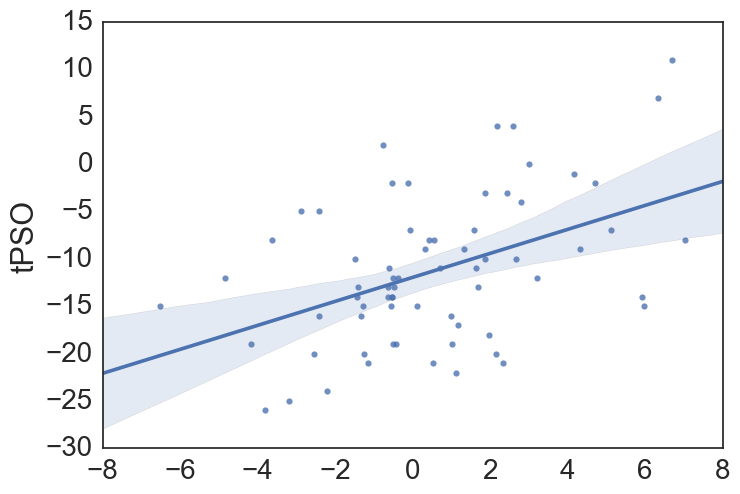

In [237]:
plt.close()
sns.regplot(np.array(kmmtest_predicted),ldt_y)
plt.show()

In [472]:
resdf = pandas.concat([kmmtest_predicted,ldt_y],axis=1)
resdf.columns = ['Predicted spEYO','Observed spEYO']

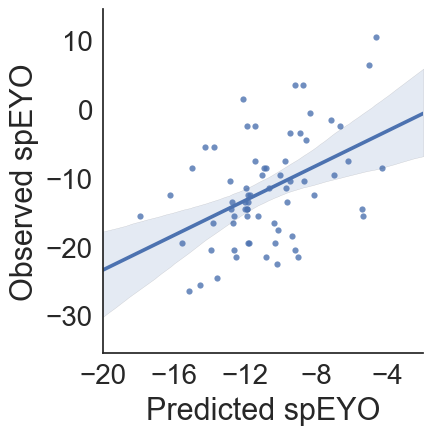

In [513]:
plt.close()
sns.set(font='Arial')
sns.set(font_scale=2)
sns.set_style('white')
fig = sns.lmplot('Predicted spEYO','Observed spEYO',data=resdf)
sns.plt.ylim(-35,15)
sns.plt.xticks([-20, -16, -12, -8, -4])
#sns.plt.xlabel('Predicted spEYO')
#sns.plt.ylabel('Year to Clinical Conversion')
fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/PAD_predicted_test_intercept.pdf')
plt.show()

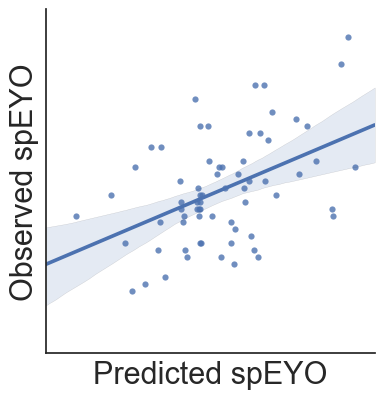

In [285]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('Predicted spEYO','Observed spEYO',data=resdf)
sns.plt.ylim(-35,15)
sns.plt.xticks([])
sns.plt.yticks([])
#sns.plt.xlabel('Predicted spEYO')
#sns.plt.ylabel('Year to Clinical Conversion')
fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/fake_test.pdf')
plt.show()

In [225]:
scl_train = pandas.DataFrame(master_scl.transform(mm_train[mm_train.columns[:888]]),index=mm_train.index,
                                                                                   columns = mm_train.columns[:888])

In [245]:
vresdf = pandas.concat([(pandas.Series(kmm_predicted,index=mm_train.index)*-1),ldy],axis=1)
vresdf.columns = ['Predicted spEYO','Observed spEYO']
vresdf['fold'] = np.random.permutation(list('1'*46) + list('2'*46) + list('3'*46))

In [207]:
((3 + 100) + (4 + 1000) + (5 + 1000)) / (3 + 2200)

0.958692691783931

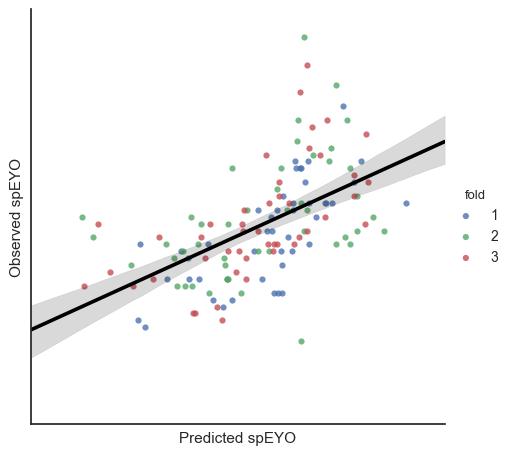

In [430]:
plt.close()
sns.set_style('white')
sns.lmplot('Predicted spEYO','Observed spEYO',data=vresdf,hue='fold',fit_reg=False)
sns.regplot(vresdf['Predicted spEYO'],vresdf['Observed spEYO'],marker=None,color='K')
#sns.plt.ylim(-35,15)
sns.plt.xticks([])
sns.plt.yticks([])
#sns.plt.xlabel('Predicted spEYO')
#sns.plt.ylabel('Year to Clinical Conversion')
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/PAD_predicted_test_inverted.pdf')
plt.show()

In [48]:
sns.heatmap?

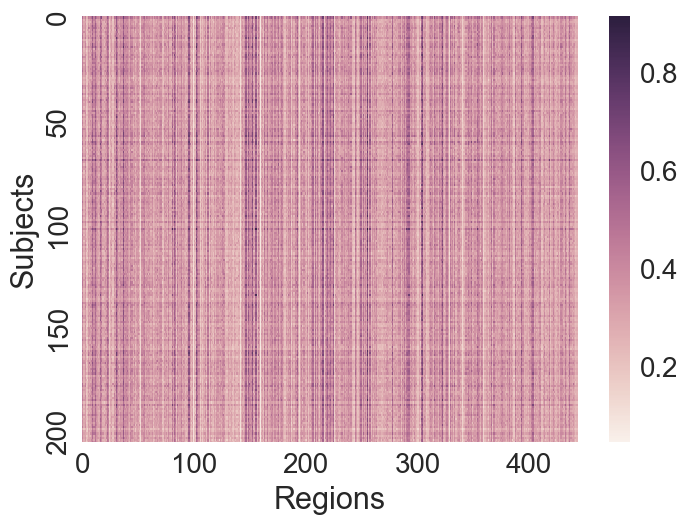

In [64]:
sns.set(font_scale=2)
jnk = deepcopy(pandas.concat([gm_train,gm_test]))
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk,xticklabels=100,yticklabels=50)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Regions')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_matrix.pdf')
plt.show()


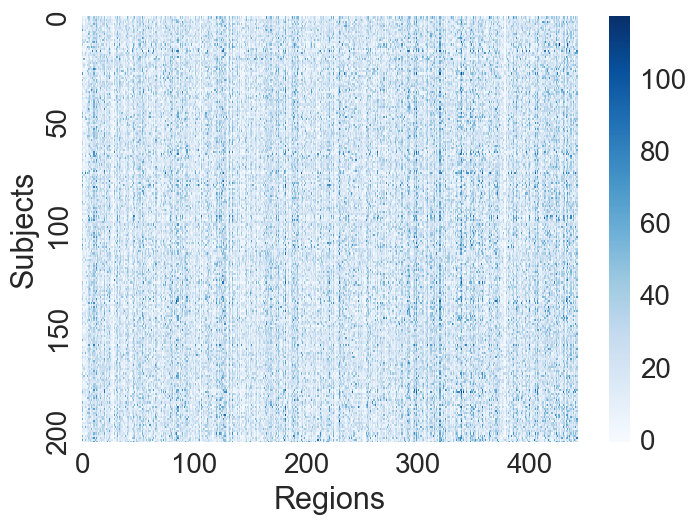

In [72]:
sns.set(font_scale=2)
tmp = deepcopy(ld_test)
tmp.columns = range(len(tmp.columns))
jnk = deepcopy(pandas.concat([ld_train,tmp]))
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk[jnk.columns[:443]],xticklabels=100,yticklabels=50,cmap = "Blues")
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Regions')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_matrix.pdf')
plt.show()



In [60]:
master_scl = preprocessing.StandardScaler().fit(mm_train[mm_train.columns[:888]])
train = pandas.DataFrame(master_scl.transform(mm_train[mm_train.columns[:888]]),
                         index=mm_train.index,columns=mm_train.columns[:888])
test = pandas.DataFrame(master_scl.transform(mm_test[mm_test.columns[:888]]),
                         index=mm_test.index,columns=mm_test.columns[:888])

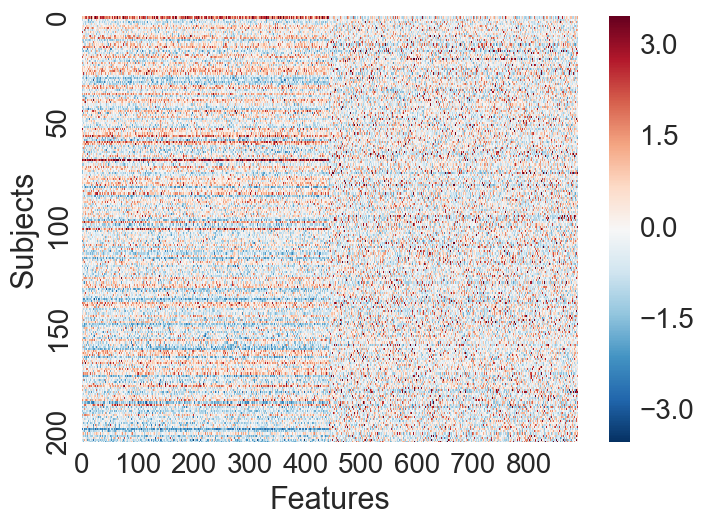

In [85]:
sns.set(font_scale=2)
jnk = deepcopy(pandas.concat([train,test]))
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk,xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_full_matrix.pdf')
plt.show()


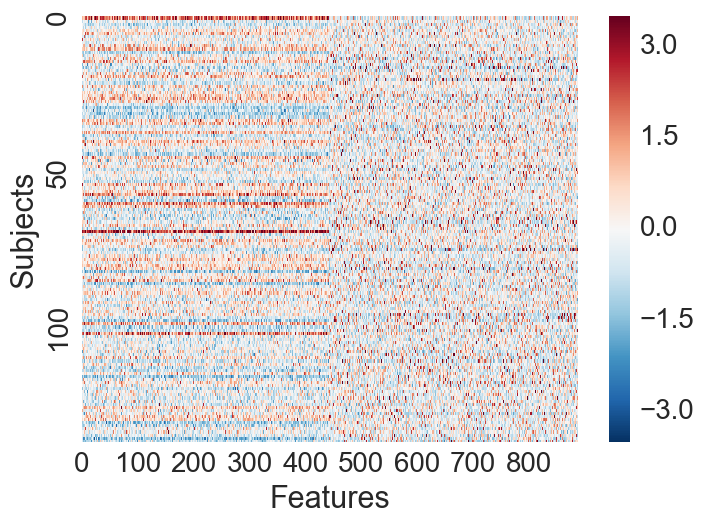

In [86]:
sns.set(font_scale=2)
jnk = deepcopy(train)
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk,xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_train_matrix.pdf')
plt.show()



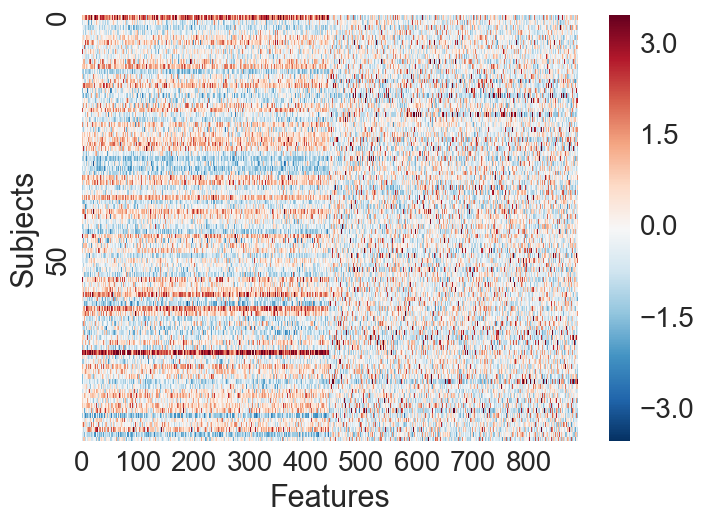

In [210]:
sns.set(font_scale=2)
jnk = deepcopy(train)
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk.loc[jnk.index[:88]],xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_inner_matrix.pdf')
plt.show()




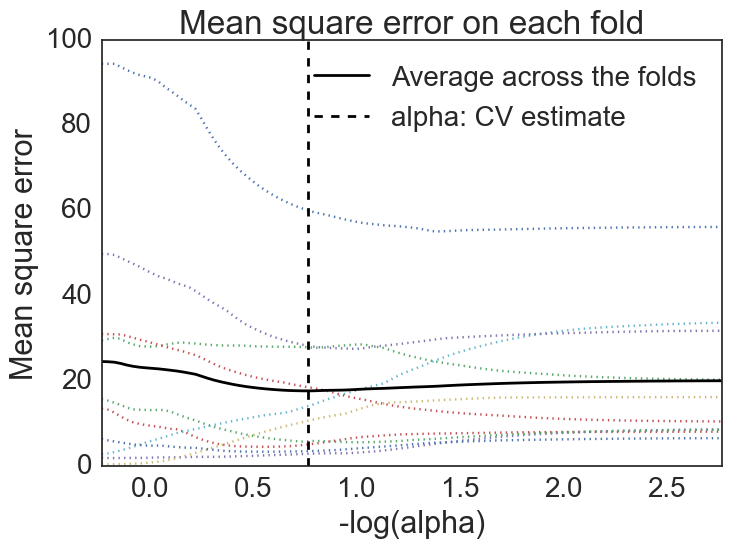

In [91]:
sns.set_style('white')
plt_min, plt_max = 0,100
model = kmm_lasso
m_log_alphas = -np.log10(model.alphas_)
plt.close()
fig = plt.figure()
ymin, ymax = plt_min, plt_max
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            linewidth=2, label='alpha: CV estimate')
#plt.axvline(model.alpha_, linestyle='--', color='k',
#            linewidth=2, label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
#plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.ylim(ymin, ymax)
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/lasso_cv.pdf')
plt.show()

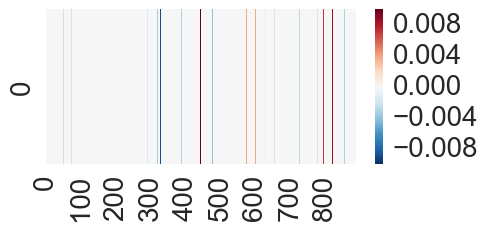

In [200]:
plt.close()
fig,ax = plt.subplots(figsize=(5,2))
sns.heatmap(kmm_weights.values[:888].reshape(-1,1).transpose(),xticklabels=100,
            vmin=-0.01,vmax=0.01)
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_vector.pdf',
#        bbox_inches='tight')
plt.show()

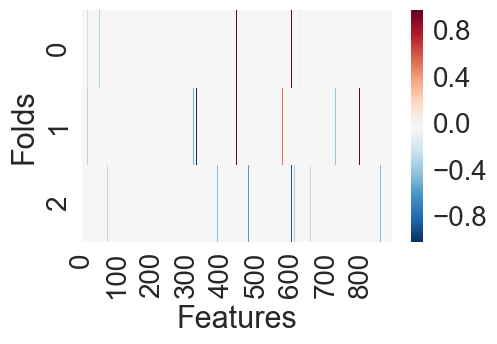

In [264]:
plt.close()
fig,ax = plt.subplots(figsize=(5,3))
sns.heatmap(fm[fm.columns[:888]],xticklabels=100,vmin = -1, vmax = 1)
sns.plt.xlabel('Features')
sns.plt.ylabel('Folds')
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_matrix.pdf',
        bbox_inches='tight')
plt.show()

In [277]:
fm2 = deepcopy(fm)
fm2.loc['mean'] = fm.sum(axis=0)

In [278]:
fm2

0    1    2    3    4    5    6    7    8    9   ...   881  882  883  \
0     0.0  0.0  0.0  0.0 -0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
1     0.0  0.0 -0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...  -0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
mean  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   

      884  885  886  887  888  889  890  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
mean  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4 rows x 891 columns]

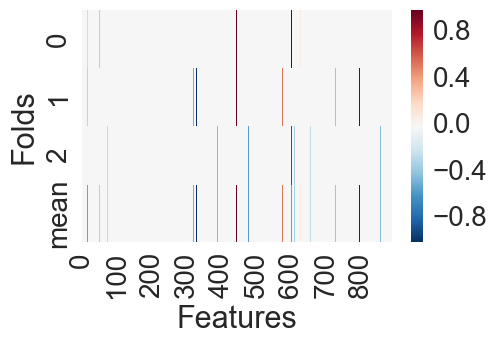

In [280]:
plt.close()
fig,ax = plt.subplots(figsize=(5,3))
sns.heatmap(fm2[fm.columns[:888]],xticklabels=100,vmin = -1, vmax = 1)
sns.plt.xlabel('Features')
sns.plt.ylabel('Folds')
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_matrix.pdf',
        bbox_inches='tight')
plt.show()

In [120]:
sns.heatmap?

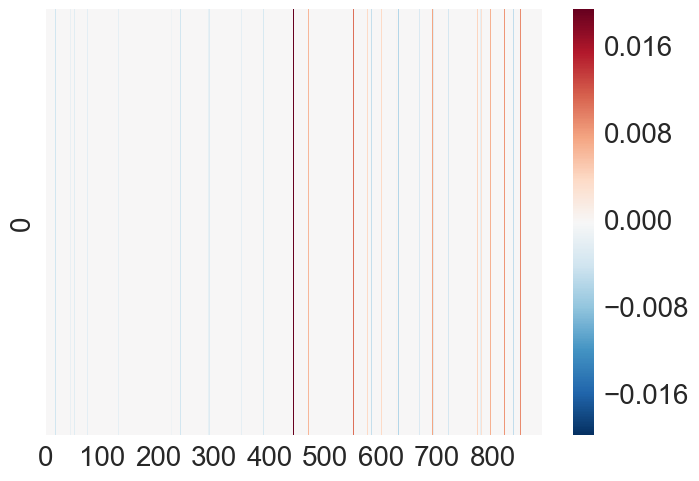

In [111]:
plt.close()
#fig,ax = plt.subplots(figsize=(5,2))
#plt.pcolor(kmm_weights.values[:888][None, :], cmap=plt.cm.jet, interpolation='nearest')
#fig,ax = plt.subplots(figsize=(5,2))
sns.heatmap(kmm_weights.values[:888][None, :],xticklabels=100)
plt.show()

In [1392]:
r,p = stats.pearsonr(np.array(kmmtest_predicted),ld_05.loc[mm_test.index].Age)
print(r,p)
print('r-square is ',r**2)



0.603976837597 4.95810107634e-08
r-square is  0.364788020354


In [1463]:
jnk = [pandas.Series(np.array(kmmtest_predicted),index=ldt_y.index),
      ld_05.loc[mm_test.index].Age,
      ldt_y]
agecon = pandas.concat(jnk,axis=1)
agecon.columns = ['predicted','age','observed']
smf.ols('observed ~ age + predicted',data=agecon).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               observed   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     8.574
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           0.000496
Time:                        17:11:26   Log-Likelihood:                -227.48
No. Observations:                  68   AIC:                             461.0
Df Residuals:                      65   BIC:                             467.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.4770     12.545     -0.915      0.364     -36.532      13.578
age           -0.0078      0.203     -0.038      0.970      -0.414       0.398
predicted     58.6667     17.652      3.323      0.001      23.413      93.920
==============================================================================
Omnibus:                        2.694   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.075
Skew:                           0.273   Prob(JB):                        0.354
Kurtosis:                       2.341   Cond. No.                     1.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1471]:
jnk = [pandas.Series(np.array(kmm_predicted),index=ldy.index),
      ld_05.loc[mm_train.index].Age,
      ldy]
agecon = pandas.concat(jnk,axis=1)
agecon.columns = ['predicted','age','observed']
smf.ols('observed ~ age + predicted',data=agecon).fit().pvalues

Intercept    3.489933e-12
age          5.496561e-06
predicted    3.026967e-14
dtype: float64

In [1390]:
len(ld_test) + len(ld_train) + 49

255

In [1090]:
kmm_full_predict = (pandas.concat([mm_train,mm_test]) * np.array(mm_weights)).sum(axis=1)
#cog_cols += ['ptau_amyloid_ratio']
for col in cog_cols:
    cy = pad.loc[kmm_full_predict.index][col]
    X = kmm_full_predict
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(X.drop(nan_subs).values,cy.drop(nan_subs).values))

immediate_memory_index_score (-0.038759395185650546, 0.59743258543969968)
visuospatial_constructional_index_score (-0.12369598980940631, 0.09079408365505813)
lang (-0.0097501339851082582, 0.89435262300791518)
attention_index_score (-0.13883826434010577, 0.057410646163110195)
delayed_memory_index_score (-0.12996119773591283, 0.075469522117825052)
ttau_amyloid_ratio (0.061834047243202295, 0.59071396894027595)
ttau_amyloid_ratio (0.061834047243202295, 0.59071396894027595)
ELISA_tau (0.0091269231419104854, 0.93433027662373369)
ELISA_b_amyloid (-0.099300631681788987, 0.36881657007839208)
ELISA_ptau (-0.03449520174206485, 0.75541349968083316)
atrophy_rate_2 (-0.16640534120945311, 0.29841672551845488)
atrophy_rate_5 (-0.10281759285554605, 0.52237233265810057)
ptau_amyloid_ratio (-0.034572758853743106, 0.76379696734453761)


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Ttest_indResult(statistic=-0.10344183543223995, pvalue=0.91792599005692455)

In [875]:
len(kmm_weights) 

891

In [293]:
hits = [i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmm_weights.index[444:889]:
    if i in hits:
        sc444[sc444==(i-443)] = kmm_weights[i]
    else:
        sc444[sc444==(i-443)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmLD_k3_0p05_nocov')

In [294]:
hits = [i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmm_weights.index[:444]:
    if i in hits:
        sc444[sc444==(i+1)] = kmm_weights[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmGM_k3_0p05_nocov')

In [880]:
len(kmm_weights2)

893

In [157]:
# What happens if I permute the sample?
prm = np.random.permutation(mm_train.index)
mm_ptrain = mm_train.loc[prm]

In [158]:
# What happens if I permute the sample?

ldy = ld_05.loc[mm_ptrain.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmmp_weights, kmmp_predicted, kmmptest_predicted = kfold_feature_learning(
                                                    mm_ptrain,mm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)




running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running lasso for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running lasso for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


52 features selected
validation prediction accuracy is 3.16288524703 percent 
 p = 0.0368999797208 
 r = 0.177845023743
testing prediction accuracy is 19.6066519599 percent 
 p = 0.00015611036116 
 r = 0.44279399228


In [161]:
hits = [i for i in kmmp_weights.index if abs(kmmp_weights[i]) > 0 ]
hitsb = [i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]
print(len(set(hits) & set(hitsb)),'features shared')
print('in kmmp but not kmm',set(hits)-set(hitsb))
print('in kmm but not kmmp',set(hitsb)-set(hits))

22 features shared
in kmmp but not kmm {384, 514, 399, 784, 143, 274, 27, 807, 823, 311, 701, 449, 836, 714, 845, 591, 719, 595, 341, 598, 725, 607, 740, 613, 748, 750, 112, 498, 249, 890}
in kmm but not kmmp {131, 773, 390, 647, 781, 654, 656, 31, 673, 292, 45, 52, 822, 695, 321, 838, 586, 75, 721, 597, 857, 602, 351, 96, 481, 226, 479, 611, 747, 628, 511}


In [833]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmm_weights2, kmm_predicted2, kmmtest_predicted2 = kfold_feature_learning(
                                                    mm2_train,mm2_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)




running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running lasso for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running lasso for fold 3 of 3
54 features selected
validation prediction accuracy is 30.7951610063 percent 
 p = 1.63155354965e-12 
 r = -0.554933879001
testing prediction accuracy is 20.8733650159 percent 
 p = 8.99076256277e-05 
 r = 0.456873779242


In [869]:
print('length is ', len(kmm_weights2))
print('# features: ',len([i for i in kmm_weights2.index if abs(kmm_weights2[i]) > 0 ]))
#[i for i in kmm_weights2.index if abs(kmm_weights2[i]) > 0 ]

length is  893
# features:  54


In [832]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.001
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmm_weights2, kmm_predicted2, kmmtest_predicted2 = kfold_feature_learning(
                                                    mm2_train,mm2_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)





running correlation for fold 1 of 3
running lasso for fold 1 of 3
running correlation for fold 2 of 3
running lasso for fold 2 of 3
running correlation for fold 3 of 3
running lasso for fold 3 of 3
11 features selected
validation prediction accuracy is 31.6550346358 percent 
 p = 6.88087403312e-13 
 r = -0.562628071072
testing prediction accuracy is 16.7486410086 percent 
 p = 0.000529648693076 
 r = 0.409251035535


In [ ]:
# TO DO -- Get sig maps for the training sample only
# Evaluate everything with demo-corrected features

In [ ]:
# CORRECTING FEATURES FOR AGE AND GENDER (AND FD FOR FMRI)

In [916]:
gm_tmp = deepcopy(gm2_train)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']

In [918]:
gm_adj_train = pandas.DataFrame(index=gm_tmp.index,columns = range(len(gm_tmp.columns) - 2))
for i in range(gm_tmp.shape[1] - 2):
    mod = smf.ols('gm_%s ~ Age + Gender'%i,data=gm_tmp).fit()
    gm_adj_train[gm_adj_train.columns[i]] = mod.resid

In [919]:
gm_tmp = deepcopy(gm2_test)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']

In [920]:
gm_adj_test = pandas.DataFrame(index=gm_tmp.index,columns = range(len(gm_tmp.columns) - 2))
for i in range(gm_tmp.shape[1] - 2):
    mod = smf.ols('gm_%s ~ Age + Gender'%i,data=gm_tmp).fit()
    gm_adj_test[gm_adj_test.columns[i]] = mod.resid

In [952]:
ld_tmp = deepcopy(ld_train)
ld_tmp.columns = ['ld_%s'%(x) for x in ld_tmp.columns[:-2]] + ['Age','Gender']
ld_tmp['FD'] = ld_05.loc[ld_tmp.index]['FD']

In [953]:
ld_adj_train = pandas.DataFrame(index=ld_tmp.index,columns = range(len(ld_tmp.columns) - 3))
for i in range(ld_tmp.shape[1] - 3):
    mod = smf.ols('ld_%s ~ Age + Gender + FD'%i,data=ld_tmp).fit()
    ld_adj_train[ld_adj_train.columns[i]] = mod.resid

In [950]:
ld_tmp = deepcopy(ld_test)
ld_tmp.columns = ['ld_%s'%(x) for x in range(len(ld_tmp.columns[:-2]))] + ['Age','Gender']
ld_tmp['FD'] = ld_05.loc[ld_tmp.index]['FD']

In [951]:
ld_adj_test = pandas.DataFrame(index=ld_tmp.index,columns = range(len(ld_tmp.columns) - 3))
for i in range(ld_tmp.shape[1] - 3):
    mod = smf.ols('ld_%s ~ Age + Gender + FD'%i,data=ld_tmp).fit()
    ld_adj_test[ld_adj_test.columns[i]] = mod.resid

In [996]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[gm_adj_train.index].tPSO
ldt_y = ld_05.loc[gm_adj_test.index].tPSO
p_cutoff = 0.05
folds = 10
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kagm_weights, kagm_predicted, kagmtest_predicted = kfold_feature_learning(
                                                    gm_adj_train,gm_adj_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)



running correlation for fold 1 of 10
running lasso for fold 1 of 10
running correlation for fold 2 of 10
running lasso for fold 2 of 10
running correlation for fold 3 of 10
running lasso for fold 3 of 10
running correlation for fold 4 of 10
running lasso for fold 4 of 10
running correlation for fold 5 of 10
running lasso for fold 5 of 10
running correlation for fold 6 of 10
running lasso for fold 6 of 10
running correlation for fold 7 of 10
running lasso for fold 7 of 10
running correlation for fold 8 of 10
running lasso for fold 8 of 10
running correlation for fold 9 of 10
running lasso for fold 9 of 10
running correlation for fold 10 of 10
running lasso for fold 10 of 10
20 features selected
validation prediction accuracy is 39.0393075712 percent 
 p = 2.61354148664e-16 
 r = -0.624814433022
testing prediction accuracy is 6.11592747282 percent 
 p = 0.0420310260468 
 r = 0.247304012762


In [995]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[ld_adj_train.index].tPSO
ldt_y = ld_05.loc[ld_adj_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kald_weights, kald_predicted, kaldtest_predicted = kfold_feature_learning(
                                                    ld_adj_train,ld_adj_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)




running correlation for fold 1 of 3
running lasso for fold 1 of 3
running correlation for fold 2 of 3
running lasso for fold 2 of 3
running correlation for fold 3 of 3
running lasso for fold 3 of 3
34 features selected
validation prediction accuracy is 35.0172306618 percent 
 p = 2.1225186089e-14 
 r = -0.591753586063
testing prediction accuracy is 11.0039411079 percent 
 p = 0.00571939132496 
 r = 0.331721888152


In [988]:
tmp = deepcopy(ld_adj_train)
tmp.columns = ['ld_%s'%x for x in tmp.columns]
mm_adj_train = pandas.concat([gm_adj_train,tmp],axis=1)
mm_adj_train.columns = range(mm_adj_train.shape[-1])

tmp = deepcopy(ld_adj_test)
tmp.columns = ['ld_%s'%x for x in tmp.columns]
mm_adj_test = pandas.concat([gm_adj_test,tmp],axis=1)
mm_adj_test.columns = range(mm_adj_test.shape[-1])

In [993]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[mm_adj_train.index].tPSO
ldt_y = ld_05.loc[mm_adj_test.index].tPSO
p_cutoff = 0.05
folds = 10
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kamm_weights, kamm_predicted, kammtest_predicted = kfold_feature_learning(
                                                    mm_adj_train,mm_adj_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)





running correlation for fold 1 of 10
running lasso for fold 1 of 10
running correlation for fold 2 of 10
running lasso for fold 2 of 10
running correlation for fold 3 of 10
running lasso for fold 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 4 of 10
running lasso for fold 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 5 of 10
running lasso for fold 5 of 10
running correlation for fold 6 of 10
running lasso for fold 6 of 10
running correlation for fold 7 of 10
running lasso for fold 7 of 10
running correlation for fold 8 of 10
running lasso for fold 8 of 10
running correlation for fold 9 of 10
running lasso for fold 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 10 of 10
running lasso for fold 10 of 10
55 features selected
validation prediction accuracy is 10.0738016979 percent 
 p = 0.000148741230451 
 r = -0.317392528235
testing prediction accuracy is 14.1415296008 percent 
 p = 0.00157560211306 
 r = 0.376052251699


In [1465]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[mm_adj_train.index].tPSO
ldt_y = ld_05.loc[mm_adj_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kamm_weights, kamm_predicted, kammtest_predicted = kfold_feature_learning(
                                                    mm_adj_train,mm_adj_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)


running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running lasso for fold 2 of 3
running correlation for fold 3 of 3
running lasso for fold 3 of 3
40 features selected
validation prediction accuracy is 40.5031926258 percent 
 p = 4.91687289466e-17 
 r = -0.636421186211
testing prediction accuracy is 10.6271710824 percent 
 p = 0.00666947625145 
 r = 0.325993421443


In [1001]:
hits = [i for i in kamm_weights.index if abs(kamm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kamm_weights.index[444:889]:
    if i in hits:
        sc444[sc444==(i-443)] = kamm_weights[i]
    else:
        sc444[sc444==(i-443)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmLD_k10_0p05_adj')

In [1009]:
hits = [i for i in kamm_weights.index if abs(kamm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kamm_weights.index[:444]:
    if i in hits:
        sc444[sc444==(i+1)] = kamm_weights[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmGM_k10_0p05_adj')

In [163]:
hits = [i for i in kmmp_weights.index if abs(kmmp_weights[i]) > 0 ]
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmmp_weights.index[:444]:
    if i in hits:
        sc444[sc444==(i+1)] = kmmp_weights[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmGM_k3_0p05_perm')

In [164]:
hits = [i for i in kmmp_weights.index if abs(kmmp_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmmp_weights.index[444:889]:
    if i in hits:
        sc444[sc444==(i-443)] = kmmp_weights[i]
    else:
        sc444[sc444==(i-443)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mmLD_k10_0p05_perm')

In [355]:
nind = []
for i in kmm_weights[:888].index:
    if i < 444:
        nind.append('GMV_%s'%(i+1))
    else:
        nind.append('fMRI_%s'%(i-443))

annot_kmm_weights = deepcopy(kmm_weights[:888])
annot_kmm_weights.index = nind
annot_kmm_weights

GMV_1       0.000000
GMV_2       0.000000
GMV_3       0.000000
GMV_4       0.000000
GMV_5       0.000000
GMV_6       0.000000
GMV_7       0.000000
GMV_8       0.000000
GMV_9       0.000000
GMV_10      0.000000
GMV_11      0.000000
GMV_12      0.000000
GMV_13      0.000000
GMV_14      0.000000
GMV_15      0.000000
GMV_16      0.000000
GMV_17      0.000000
GMV_18      0.000000
GMV_19     -0.173679
GMV_20      0.000000
GMV_21      0.000000
GMV_22      0.000000
GMV_23      0.000000
GMV_24      0.000000
GMV_25      0.000000
GMV_26      0.000000
GMV_27      0.000000
GMV_28      0.000000
GMV_29      0.000000
GMV_30      0.000000
              ...   
fMRI_415    0.000000
fMRI_416    0.000000
fMRI_417    0.000000
fMRI_418    0.000000
fMRI_419    0.000000
fMRI_420    0.000000
fMRI_421    0.000000
fMRI_422    0.000000
fMRI_423    0.000000
fMRI_424    0.000000
fMRI_425    0.000000
fMRI_426    0.000000
fMRI_427    0.000000
fMRI_428    0.000000
fMRI_429    0.000000
fMRI_430    0.000000
fMRI_431    0

In [356]:
kmm_weights_abs = pandas.Series(abs(annot_kmm_weights.values))
kmm_weights_abs.index = annot_kmm_weights.index
kmm_weights_abs.sort_values(ascending=False)
[(i,j) for i,j in kmm_weights_abs.sort_values(ascending=False).items() if j > 0]
#list(zip(kmm_weights.sort_values()

[('fMRI_1', 0.9028497694847083),
 ('fMRI_260', 0.62198092289882734),
 ('fMRI_108', 0.49466763484199078),
 ('fMRI_154', 0.49189123024784465),
 ('fMRI_407', 0.42962824335435124),
 ('GMV_331', 0.4094544651043901),
 ('fMRI_379', 0.39630628839748727),
 ('fMRI_376', 0.37453420877621885),
 ('fMRI_250', 0.35881987632309637),
 ('fMRI_354', 0.32319476225718841),
 ('fMRI_88', 0.32031851523920912),
 ('fMRI_28', 0.30101518597395427),
 ('fMRI_189', 0.2679725824936377),
 ('fMRI_204', 0.26102537613339277),
 ('fMRI_395', 0.22544342413412435),
 ('fMRI_141', 0.21857477871552045),
 ('fMRI_330', 0.19906890665329302),
 ('fMRI_68', 0.19889242885803149),
 ('fMRI_36', 0.18666122058444265),
 ('fMRI_133', 0.1821399209464917),
 ('fMRI_159', 0.17830899706068878),
 ('GMV_19', 0.17367890888508611),
 ('GMV_243', 0.17289929094016651),
 ('GMV_322', 0.16104829986557082),
 ('fMRI_278', 0.15583467084297292),
 ('fMRI_414', 0.14724548405147134),
 ('fMRI_338', 0.14648623420850282),
 ('GMV_391', 0.1433268805678562),
 ('fMRI_2

In [357]:
jnk = pandas.DataFrame(annot_kmm_weights,columns=['weights'])
jnk = jnk.loc[kmm_weights_abs.sort_values(ascending=False).index]

In [358]:
for reg in jnk.index:
    if 'GMV' in reg:
        jnk.ix[reg,'modality'] = 'GM Volume'
    else:
        jnk.ix[reg,'modality'] = 'rsfMRI Connectivity'

In [332]:
sns.set(font_scale=1)

In [364]:
sns.set_style('white')

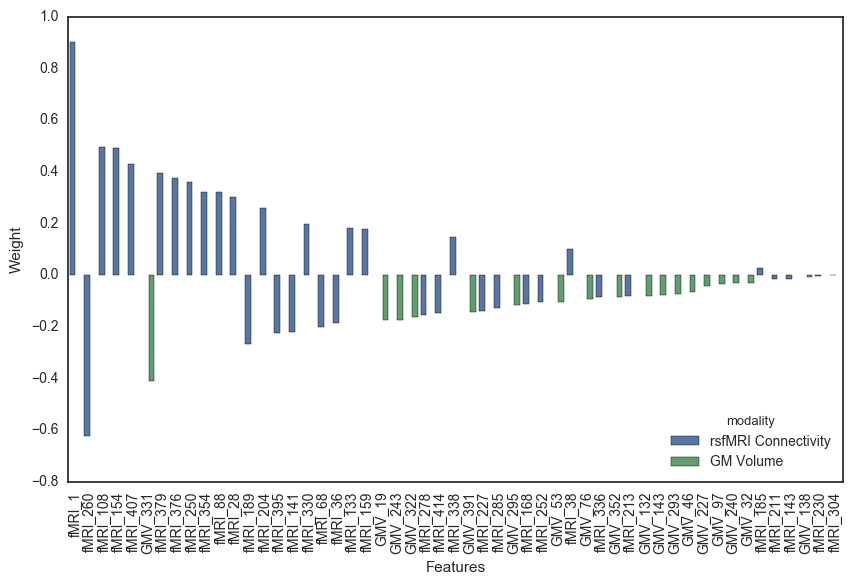

In [368]:
plt.close()
fig,ax = plt.subplots(figsize=(10,6))
fig = sns.barplot(x = jnk[abs(jnk.weights)>0].index,
            y='weights',
            data=jnk[abs(jnk.weights)>0],
            hue='modality')
for item in fig.get_xticklabels():
    item.set_rotation(90)
sns.plt.xlabel('Features')
sns.plt.ylabel('Weight')
fig = fig.get_figure() 
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weight_values.pdf',
        bbox_inches='tight')
plt.show()

In [395]:
sig_feats_test = mm_test[kmm_weights[abs(kmm_weights)>0].index]
sig_feats_test.ix[:,'Age'] = ld_05.loc[mm_test.index]['Age']
sig_feats_test.ix[:,'Gender'] = ld_05.loc[mm_test.index]['Gender']
sig_feats_test.ix[:,'FD'] = ld_05.loc[mm_test.index]['FD']
sig_feats_test.ix[:,'TIV'] = pad.loc[mm_test.index]['tiv']
sig_feats_test.ix[:,'tPSO'] = ld_05.loc[mm_test.index]['tPSO']
sig_feats_test.columns = ['roi_%s'%x for x in sig_feats_test.columns[:-5]] + [
                                                        'Age', 'Gender','FD','TIV','tPSO']
sf_df_test = pandas.DataFrame(index = sig_feats_test.columns[:-5],
                              columns=['r','p','reg_t','reg_p'])

for i in sig_feats_test.columns[:-5]:
    r,p = stats.pearsonr(sig_feats_test[i],ld_05.loc[mm_test.index].tPSO)
    sf_df_test.ix[i,'r'] = r
    sf_df_test.ix[i,'p'] = p
    stmt = 'tPSO ~ Age + Gender + TIV + FD + %s'%(i)
    mod = smf.ols(stmt,data=sig_feats_test).fit()
    t = mod.tvalues[-1]
    p = mod.pvalues[-1]
    sf_df_test.ix[i,'reg_t'] = t
    sf_df_test.ix[i,'reg_p'] = p
    print(i,p)

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


roi_18 0.259864548981
roi_31 0.125953797101
roi_45 0.0627265326312
roi_52 0.212244239633
roi_75 0.00639947067931
roi_96 0.131845738387
roi_131 0.472726945778
roi_137 0.108641775255
roi_142 0.00597323528363
roi_226 0.0831415642012
roi_239 0.0240628251589
roi_242 0.147948768999
roi_292 0.249734841176
roi_294 0.590337864642
roi_321 0.433086749251
roi_330 0.151230125485
roi_351 0.690721878956
roi_390 0.929416880693
roi_444 0.0256841212952
roi_471 0.489066109348
roi_479 0.615537952262
roi_481 0.706626972984
roi_511 0.143911946204
roi_531 0.0958225630107
roi_551 0.0994565300404
roi_576 0.847547070313
roi_584 0.343576954929
roi_586 0.124470156029
roi_597 0.249642266169
roi_602 0.531486719797
roi_611 0.354129221121
roi_628 0.574943771675
roi_632 0.91635084548
roi_647 0.727907659932
roi_654 0.353579728477
roi_656 0.153895989393
roi_670 0.0224632185441
roi_673 0.0529015062899
roi_693 0.302694420305
roi_695 0.0867285350145
roi_703 0.973222825722
roi_721 0.10874117888
roi_728 0.705255060312
roi_74

In [401]:
FDR(sf_df_test['p'],0.1)

(array([False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False], dtype=bool),
 array([0.18709274280881505, 0.19473985292929888, 0.17601771012563994,
        0.38930552966703941, 0.045249564105646685, 0.18709274280881505,
        0.35597640395824282, 0.17601771012563994, 0.045249564105646685,
        0.17590486382626142, 0.17601771012563994, 0.18709274280881505,
        0.36324349820266089, 0.76647279060183571, 0.36324349820266089,
        0.18709274280881505, 0.88725092062915789, 0.81446582294217063,
        0.17601771012563994, 0.62060058202834412, 0.73131707245370847,
        0.67118393419022426, 0.28819418064383429, 0.3632434982026608

In [407]:
sf_df_test[sf_df_test.p<0.05]

r           p    reg_t       reg_p
roi_18  -0.247525   0.0418416 -1.13712    0.259865
roi_45  -0.268957   0.0265687 -1.89523   0.0627265
roi_75  -0.373462  0.00170753 -2.82232  0.00639947
roi_96  -0.238879    0.049782   -1.527    0.131846
roi_137 -0.269659    0.026161 -1.62779    0.108642
roi_142 -0.389017  0.00104316 -2.84725  0.00597324
roi_226 -0.298935   0.0132758 -1.76116   0.0831416
roi_239  -0.28792   0.0172712 -2.31286   0.0240628
roi_242 -0.254716   0.0360634 -1.46509    0.147949
roi_330 -0.257834   0.0337735 -1.45313     0.15123
roi_444  0.272566     0.02453   2.2851   0.0256841
roi_670 -0.306004   0.0111556 -2.34099   0.0224632
roi_673 -0.243652   0.0452584 -1.97348   0.0529015

In [413]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in np.unique(sc444)[1:]:
    if 'roi_%s'%int(i) in sf_df_test[sf_df_test.p<0.05].index:
        if i == 137 or i == 142:
            sc444[sc444 == i+1] = 2000
        else:
            sc444[sc444 == i+1] = 1000
    else:
        sc444[sc444==i+1] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/sig_pred_weights_test')

In [412]:
sc444[sc444==1000]

array([ 1000.,  1000.,  1000., ...,  1000.,  1000.,  1000.], dtype=float32)

In [404]:
673-443

230

In [310]:
pandas.DataFrame(annot_kmm_weights,columns = ['weight']).to_excel(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/final_weights.xls')

In [1018]:
pad.loc[gm2_train.index]['tiv']

In [ ]:
# I will try now once more with all features plus Age, Gender, TIV and FD included as features

In [1484]:
jnk = deepcopy(mm_train)
mm_cov_train = jnk[jnk.columns[:888]]
jnk = deepcopy(mm_test)
mm_cov_test = jnk[jnk.columns[:888]]
cols = ['Age','Gender','FD']
for col in cols:
    mm_cov_train[col] = ld_05.loc[mm_cov_train.index][col]
    mm_cov_test[col] = ld_05.loc[mm_cov_test.index][col]
mm_cov_train['tiv'] = pad.loc[mm_cov_train.index]['tiv']
mm_cov_test['tiv'] = pad.loc[mm_cov_test.index]['tiv']

mm_cov_train.columns = range(len(mm_cov_train.columns))
mm_cov_test.columns = range(len(mm_cov_test.columns))

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1485]:
mm_cov_train.columns[-4:].tolist()

[888, 889, 890, 891]

In [1522]:
ldy = ld_05.loc[mm_cov_train.index].tPSO
ldt_y = ld_05.loc[mm_cov_test.index].tPSO
p_cutoff = 0.05
folds = 3
keep_cols = mm_cov_train.columns[-4:].tolist()
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kcmm_weights, kcmm_predicted, kcmmtest_predicted = kfold_feature_learning(
                                                    mm_cov_train,mm_cov_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True,
                                                    keep_cols=keep_cols)



running correlation for fold 1 of 3
running lasso for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running lasso for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running lasso for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


55 features selected
validation prediction accuracy is 31.2621589952 percent 
 p = 1.0221526429e-12 
 r = -0.559125737158
testing prediction accuracy is 21.7464061327 percent 
 p = 6.12183736497e-05 
 r = 0.466330420761


In [544]:
### NOW TO GENERATE REGULAR CORRELATION MAPS
gm_tmp = deepcopy(gm2_train)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']
gm_tmp['tiv'] = pad.loc[gm2_train.index]['tiv']
gm_tmp['tPSO'] = ld_05.loc[gm_tmp.index]['tPSO']
gm_tvals = []
gm_pvals = []
for i in range(gm_tmp.shape[1] - 4):
    mod = smf.ols('tPSO ~ Age + Gender + tiv + gm_%s'%i,data=gm_tmp).fit()
    gm_tvals.append(mod.tvalues[-1])
    gm_pvals.append(mod.pvalues[-1])

In [545]:
ld_tmp = deepcopy(ld_train)
ld_tmp.columns = ['ld_%s'%(x) for x in ld_tmp.columns[:-2]] + ['Age','Gender']
ld_tmp['FD'] = ld_05.loc[ld_tmp.index]['FD']
ld_tmp['tPSO'] = ld_05.loc[ld_tmp.index]['tPSO']
ld_tvals = []
ld_pvals = []
for i in range(ld_tmp.shape[1] - 4):
    mod = smf.ols('tPSO ~ Age + Gender + FD + ld_%s'%i,data=ld_tmp).fit()
    ld_tvals.append(mod.tvalues[-1])
    ld_pvals.append(mod.pvalues[-1])

In [1371]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(gm_pvals)):
    if gm_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = gm_pvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_pvals_tiv')

In [1037]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ld_pvals))[:444]:
    if ld_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = ld_pvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_glm_pvals')

In [1372]:
# Now rvalues
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(gm_pvals)):
    if gm_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = gm_tvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_tvals_tiv')

In [1041]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ld_pvals))[:444]:
    if ld_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = ld_tvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_glm_tvals')

In [ ]:
# OKAY, NOW IM GOING TO SEE IF I CORRECT THE MODELS IF I GRAB ONLY FEATURES WITH AN ADJUSTED
# (FOR DEMOGRAPHICS) P-VALUE BELOW A GIVEN THRESHOLD, RATHER THAN AN UNADJUSTED VALUE

In [1048]:
[i for i in range(len(ld_tvals)) if ld_pvals[i]>0.04 and ld_pvals[i]<0.05]

[110, 127, 151, 374, 399, 438]

In [1053]:
ld_tvals[438]

-1.9801361643260054

In [1054]:
len(ld_train)

138

In [ ]:
# EXPERIMENTAL CLUSTERING ANALYSIS

In [1065]:
rdf = pandas.concat([kmmtest_predicted,ldt_y],axis=1)
rdf.columns = ['predicted','observed']
rdf = (rdf - rdf.mean()) / rdf.std()
main_model_resids = smf.ols('observed ~ predicted',data=rdf).fit().resid
#plt.show()

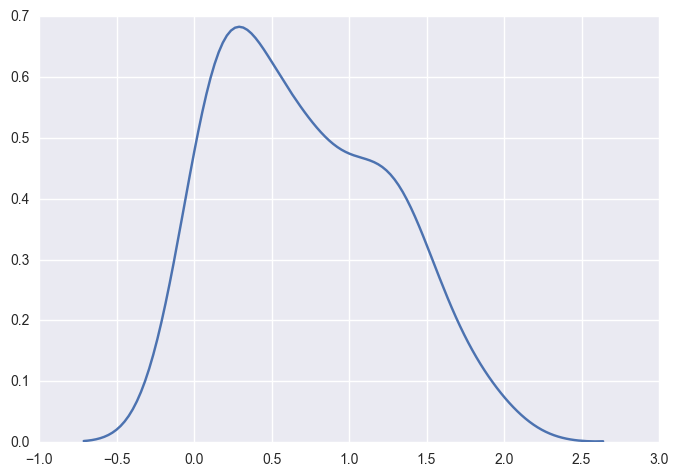

In [1075]:
plt.close()
sns.kdeplot(abs(main_model_resids))
plt.show()

In [1088]:
from sklearn.cluster import MeanShift, estimate_bandwidth
x = abs(main_model_resids)
#X = np.array(zip(x,np.zeros(len(x))))
X = np.array(x).reshape(-1,1)
bandwidth = estimate_bandwidth(X, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

for k in range(n_clusters_):
    my_members = labels == k
    print("cluster {0}: {1}".format(k, X[my_members, 0]))

cluster 0: [ 0.22680078  0.30453957  0.12440874  0.18449206  0.30084844  0.17392311
  0.17723712  0.15762779  0.02982626  0.09541663  0.03022302  0.05582091
  0.07551386  0.05720444  0.00718838  0.22397173  0.14324981  0.18312375
  0.05405889  0.32378746  0.32841828  0.16395114  0.196499    0.37992649]
cluster 1: [ 0.83108693  0.61975444  0.8248743   0.83536462  0.84070317  0.68143549
  0.40767087  0.67186493  0.40994248  0.78458856  0.52662649  0.49577945
  0.44088342  0.41897989  0.6362376   0.65098058  0.56777343  0.84707582
  0.75499009  0.51380778  0.73064142]
cluster 2: [ 1.1871584   1.15680705  1.18905809  1.47564258  1.54433175  0.97680235
  1.24786427  1.38363473  1.06983026  1.09746493  1.3650522   1.22524835
  1.10248068  1.36557633  1.28909714  1.2997582   1.36572848  1.05002699
  1.91964124  1.63082095  1.69951012  1.40659339  1.86086821]


In [1094]:
rdf['clus_labels'] = ms.labels_

In [1093]:
for col in cog_cols:
    cy = pad.loc[kmmtest_predicted.index][col]
    X = abs(main_model_resids)
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(X.drop(nan_subs).values,cy.drop(nan_subs).values))

immediate_memory_index_score (-0.066876252989129623, 0.60554266294063552)
visuospatial_constructional_index_score (0.085621288409333515, 0.50817689725013149)
lang (0.085671724200278701, 0.50792615962430376)
attention_index_score (0.1292175737493883, 0.31684705871226226)
delayed_memory_index_score (0.097878401013854296, 0.4491512259742807)
ttau_amyloid_ratio (0.1292678875412718, 0.50392881627202968)
ttau_amyloid_ratio (0.1292678875412718, 0.50392881627202968)
ELISA_tau (0.27664595408647275, 0.13191790382367802)
ELISA_b_amyloid (0.19216875515975454, 0.30035419449610357)
ELISA_ptau (0.36557712763168831, 0.043133450540093855)
atrophy_rate_2 (-0.52566355801598974, 0.1186374813529992)
atrophy_rate_5 (-0.55327058271886975, 0.097112843609059696)
ptau_amyloid_ratio (0.15655015940084896, 0.41737513445553409)


In [1098]:
for col in cog_cols:
    X1 = pad.loc[rdf[rdf['clus_labels']==0].index][col].dropna()
    X2 = pad.loc[rdf[rdf['clus_labels']==1].index][col].dropna()
    X3 = pad.loc[rdf[rdf['clus_labels']==2].index][col].dropna()
    #nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.f_oneway(X1,X2,X3))

immediate_memory_index_score F_onewayResult(statistic=0.031018463704824938, pvalue=0.96947347165933084)
visuospatial_constructional_index_score F_onewayResult(statistic=0.024628401967207697, pvalue=0.97568242763521762)
lang F_onewayResult(statistic=0.2442817313784964, pvalue=0.78405519125461942)
attention_index_score F_onewayResult(statistic=2.0574272282417914, pvalue=0.13685245229225032)
delayed_memory_index_score F_onewayResult(statistic=0.98761429102903553, pvalue=0.37853666382178353)
ttau_amyloid_ratio F_onewayResult(statistic=1.2829060158449594, pvalue=0.29420365236382406)
ttau_amyloid_ratio F_onewayResult(statistic=1.2829060158449594, pvalue=0.29420365236382406)
ELISA_tau F_onewayResult(statistic=4.0801037885679161, pvalue=0.027859904962024666)
ELISA_b_amyloid F_onewayResult(statistic=1.4893552418984739, pvalue=0.24284308204169441)
ELISA_ptau F_onewayResult(statistic=3.6286335547186486, pvalue=0.039694596948965481)
atrophy_rate_2 F_onewayResult(statistic=1.8818941180427331, pvalu

In [1107]:
rdf['abeta'] = pad.loc[rdf.index]['ELISA_b_amyloid'] 
rdf['ptau'] = pad.loc[rdf.index]['ELISA_ptau'] 
rdf['tau'] = pad.loc[rdf.index]['ELISA_tau'] 

In [1110]:
smf.ols('abeta ~ observed * clus_labels',data=rdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  abeta   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.301
Date:                Sat, 26 Aug 2017   Prob (F-statistic):             0.0998
Time:                        17:54:00   Log-Likelihood:                -217.40
No. Observations:                  31   AIC:                             442.8
Df Residuals:                      27   BIC:                             448.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              915.7035     78.260     11.701      0.000     755.128    1076.279
observed              -331.6373    194.736     -1.703      0.100    -731.203      67.929
clus_labels            114.5600     63.323      1.809      0.082     -15.368     244.488
observed:clus_labels   146.1593    110.663      1.321      0.198     -80.902     373.221
==============================================================================
Omnibus:                        1.660   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                0.870
Skew:                          -0.398   Prob(JB):                        0.647
Kurtosis:                       3.203   Cond. No.                         7.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# FINALLY -- THE ADNI ANALYSIS. DOES IT *REALLY* GENERALIZE? 
# CHECK THE FOLLOWING
# 1) PREDICTED VALUE IN CONVERTER CONTROLS VS NON-CONVERTER CONTROLS
# 2) TIME TO CONVERSION VS PREDICTED VALUES

# IF THOSE FAIL, LOOK AT MORE BASIC STUFF, LIKE GENERAL CONVERSION OR DX

In [62]:
adni_gm = pandas.read_csv(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni/adni_444_gm.csv')
adni_ld = pandas.read_csv(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni/ld_05_444')


In [63]:
adni_gm.index = ['%0.4d'%(x) for x in adni_gm[adni_gm.columns[0]]]
adni_gm.drop(adni_gm.columns[0],axis=1,inplace=True)

In [64]:
adni_ld.index = [x[-4:] for x in adni_ld[adni_ld.columns[0]]]
adni_ld.drop(adni_ld.columns[0],axis=1,inplace=True)

In [65]:
adni_ld.drop([x for x in adni_ld.index if x not in adni_gm.index],axis=0,inplace=True)

In [66]:
all(adni_ld.sort_index().index == adni_gm.sort_index().index)

True

In [67]:
jnk = deepcopy(adni_ld)
jnk.columns = ['ld_%s'%(x) for x in adni_ld.columns]
adni_mm = pandas.concat([adni_gm,jnk],axis=1)
adni_mm.columns = range(len(adni_mm.columns))
adni_mm.head()

0         1         2         3         4         5         6    \
0107  0.272425  0.408778  0.293263  0.332708  0.180901  0.257986  0.344980   
0186  0.301931  0.436042  0.288299  0.346390  0.188716  0.241736  0.376012   
0295  0.215595  0.421904  0.292742  0.365032  0.205979  0.243235  0.435662   
0685  0.231848  0.373186  0.242312  0.296204  0.213108  0.195514  0.308646   
0729  0.224728  0.341952  0.243393  0.258103  0.172833  0.169088  0.215855   

           7         8         9   ...   878  879  880  881  882  883  884  \
0107  0.328626  0.345354  0.440391 ...    23   29   73   40   60   33   15   
0186  0.303287  0.360085  0.349713 ...    11   16   19   10   14   14    5   
0295  0.355282  0.322558  0.410210 ...    63    5    4   31   16   54    7   
0685  0.238454  0.262957  0.293262 ...    17   13   24   30    8   18    5   
0729  0.221585  0.225657  0.274856 ...    28   46    1   47   48   57   17   

      885  886  887  
0107   29   54   50  
0186   10   23   40  
0295   51   15   97  
0685   34   21   67  
0729    3   15   46  

[5 rows x 888 columns]

In [68]:
adni_mm_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_mm),
                              index=adni_mm.index,columns = adni_mm.columns)
jnk = preprocessing.StandardScaler().fit(mm_train[mm_train.columns[:888]])
adni_mm_s2 = pandas.DataFrame(jnk.transform(adni_mm), index=adni_mm.index, 
                                                      columns=adni_mm.columns)

In [69]:
adni_predicted_kmm = (kmm_weights[:888] * adni_mm).sum(axis=1) + allint
adni_predicted_kmm_s1 = (kmm_weights[:888] * adni_mm_s1).sum(axis=1) + allint
adni_predicted_kmm_s2 = (kmm_weights[:888] * adni_mm_s2).sum(axis=1) + allint

In [454]:
adni_predicted_kamm = (kamm_weights[:888] * adni_mm).sum(axis=1)
adni_predicted_kamm_s1 = (kamm_weights[:888] * adni_mm_s1).sum(axis=1)
adni_predicted_kamm_s2 = (kamm_weights[:888] * adni_mm_s2).sum(axis=1)

NameError: name 'kamm_weights' is not defined

In [455]:
adni_predicted_kmmp = (kmmp_weights[:888] * adni_mm).sum(axis=1)
adni_predicted_kmmp_s1 = (kmmp_weights[:888] * adni_mm_s1).sum(axis=1)
adni_predicted_kmmp_s2 = (kmmp_weights[:888] * adni_mm_s2).sum(axis=1)

In [70]:
adnidf = pandas.read_csv('/Users/jakevogel/Science/tau/ADNI_MASTER.csv')

In [72]:
adnidf.index = ['%0.4d'%(x) for x in adnidf.RID]
adnidf.head()

RID VISCODE  VISupdate COLPROT ORIGPROT   EXAMDATE DX.bl   AGE PTGENDER  \
0002    2      bl        0.0   ADNI1    ADNI1   9/8/2005    CN  74.3     Male   
0002    2     m06        6.0   ADNI1    ADNI1   3/6/2006    CN  74.3     Male   
0002    2     m36       36.0   ADNI1    ADNI1  8/27/2008    CN  74.3     Male   
0002    2     m60       60.0  ADNIGO    ADNI1  9/22/2010    CN  74.3     Male   
0002    2     m66       66.0  ADNIGO    ADNI1   3/4/2011    CN  74.3     Male   

      PTEDUCAT    ...      Years.bl   Month.bl Month     M  \
0002      16.0    ...      0.000000   0.000000   0.0   0.0   
0002      16.0    ...      0.490075   5.868852   6.0   6.0   
0002      16.0    ...      2.967830  35.540984  36.0  36.0   
0002      16.0    ...      5.037645  60.327869  60.0  60.0   
0002      16.0    ...      5.483915  65.672131  66.0  66.0   

      SUMMARYSUVR_WHOLECEREBNORM  SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF  \
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   

      ADNI_MEM  ADNI_EF    DX.conv   DX.final  
0002     0.506   -0.060  NL to MCI  NL to MCI  
0002     0.585   -0.197  NL to MCI  NL to MCI  
0002     0.405   -0.008  NL to MCI  NL to MCI  
0002     0.352   -0.295  NL to MCI  NL to MCI  
0002       NaN      NaN  NL to MCI  NL to MCI  

[5 rows x 208 columns]

In [73]:
adni_bl = adnidf[adnidf.VISCODE == 'bl'].loc[adni_gm.index]

In [74]:
for x in range(adni_bl.shape[0]): 
    try:
        if type(adnidf.loc[adni_bl.index[x]]['DX']) != str:
            if len(adnidf.loc[adni_bl.index[x]]['DX'].dropna().unique()) > 1:
                print(adni_bl.index[x],adni_bl.ix[adni_bl.index[x],'DX.conv'],
                          '\n',list(adnidf.loc[adni_bl.index[x]]['DX'].dropna()),'\n\n')
    except:
        continue

0729 MCI to Dementia 
 ['MCI', 'MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia'] 


0778 MCI to Dementia 
 ['NL', 'NL', 'NL', 'NL', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia'] 


2010 MCI to NL 
 ['MCI', 'MCI to NL', 'MCI to NL', 'NL', 'NL', 'NL'] 


2018 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL'] 


2022 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL'] 


2073 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL', 'NL'] 


2180 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL'] 


2233 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL'] 


2403 MCI to Dementia 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to Dementia'] 


4042 MCI to Dementia 
 ['MCI', 'MCI', 'MCI', 'MCI to Dementia'] 


4094 MCI to Dementia 
 ['MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia'] 


4188 MCI to Dementia 
 ['MCI', 'MCI', 'MCI'

In [256]:
all(adni_bl.index == adni_predicted_kmm.index)

True

In [75]:
adni_bl['adni_predicted_kmm'] = adni_predicted_kmm
adni_bl['adni_predicted_kmm_s1'] = adni_predicted_kmm_s1
adni_bl['adni_predicted_kmm_s2'] = adni_predicted_kmm_s2

In [1473]:
adni_bl['adni_predicted_kamm'] = adni_predicted_kamm
adni_bl['adni_predicted_kamm_s1'] = adni_predicted_kamm_s1
adni_bl['adni_predicted_kamm_s2'] = adni_predicted_kamm_s2

In [183]:
adni_bl['adni_predicted_kmmp'] = adni_predicted_kmmp
adni_bl['adni_predicted_kmmp_s1'] = adni_predicted_kmmp_s1
adni_bl['adni_predicted_kmmp_s2'] = adni_predicted_kmmp_s2

In [184]:
stats.ttest_ind(adni_bl[adni_bl.DX == 'NL']['adni_predicted_kmm'],
               adni_bl[adni_bl.DX == 'MCI']['adni_predicted_kmm'],
                )

Ttest_indResult(statistic=0.74846490003102217, pvalue=0.45577714458194596)

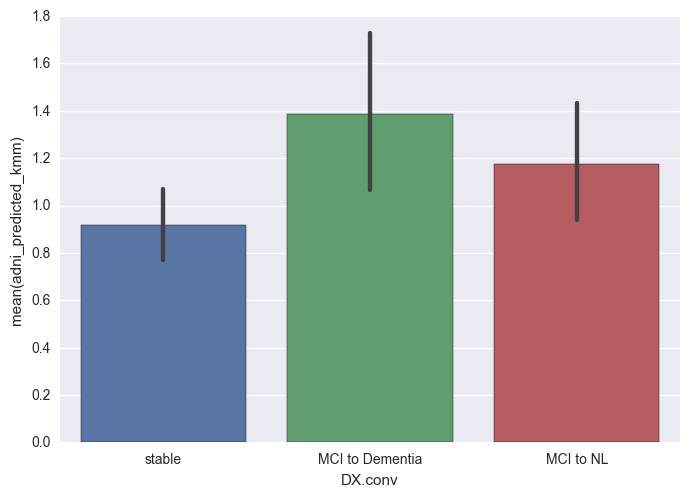

In [1298]:
plt.close()
sns.barplot(x='DX.conv',y='adni_predicted_kmm',data=adni_bl[adni_bl.DX=='MCI'])
plt.show()

In [76]:
cats = ['stable','NL to MCI','MCI to Dementia']
for sub in adni_bl.index:
    if adni_bl.ix[sub,'DX.conv'] in cats:
        adni_bl.ix[sub,'converter_anal'] = 1
        if adni_bl.ix[sub,'DX.conv'] in cats[1:]:
            adni_bl.ix[sub,'converter'] = 1
        else:
            adni_bl.ix[sub,'converter'] = 0
    else:
        adni_bl.ix[sub,'converter_anal'] = 0
        adni_bl.ix[sub,'converter'] = np.nan

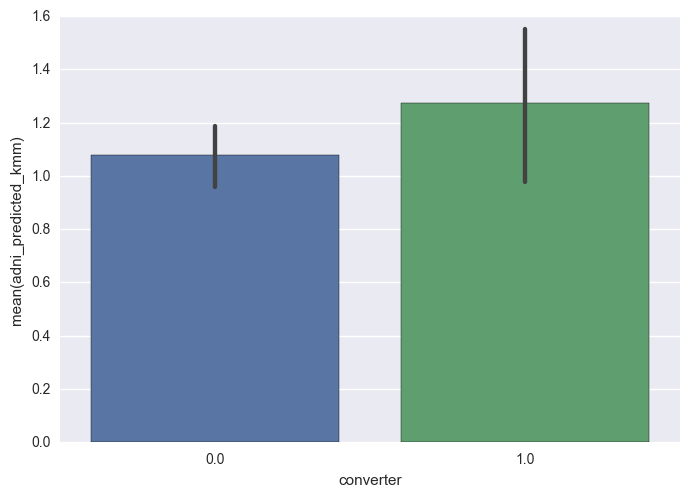

In [1297]:
plt.close()
sns.barplot(x='converter',y='adni_predicted_kmm',data=adni_bl[adni_bl.converter_anal==1])
plt.show()

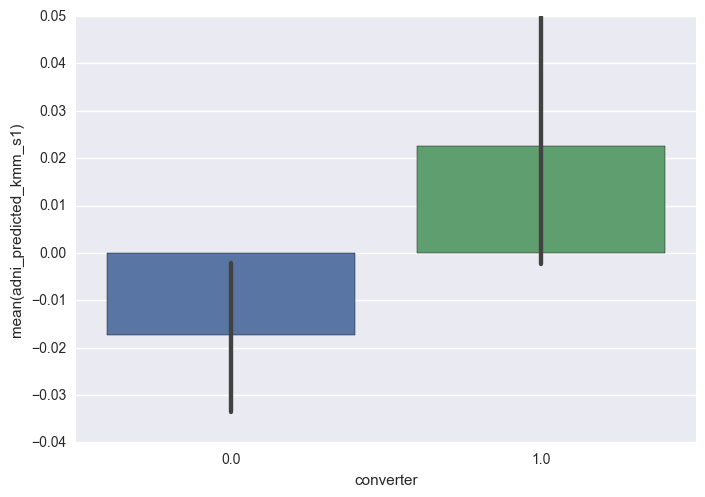

In [1308]:
plt.close()
sns.barplot(x='converter',y='adni_predicted_kmm_s1',data=adni_bl[(adni_bl.converter_anal==1) & (adni_bl.DX == 'MCI')])
plt.show()

In [1309]:
stats.ttest_ind(adni_bl[(adni_bl.converter_anal) == 1 & (adni_bl.converter == 0) & (adni_bl.DX == 'MCI')]['adni_predicted_kmm_s1'],
               adni_bl[(adni_bl.converter_anal) == 1 & (adni_bl.converter == 1) & (adni_bl.DX == 'MCI')]['adni_predicted_kmm_s1'],
                )

Ttest_indResult(statistic=-1.9537832437249241, pvalue=0.053438976428512946)

In [77]:
conv_df = adnidf.loc[adni_bl[adni_bl.converter == 1].index]

In [189]:
conv_df.head()

RID VISCODE  VISupdate COLPROT ORIGPROT   EXAMDATE DX.bl   AGE PTGENDER  \
0729  729      bl        0.0   ADNI1    ADNI1   8/2/2006  LMCI  65.1   Female   
0729  729     m06        6.0   ADNI1    ADNI1  2/22/2007  LMCI  65.1   Female   
0729  729     m12       12.0   ADNI1    ADNI1   9/5/2007  LMCI  65.1   Female   
0729  729     m18       18.0   ADNI1    ADNI1   3/5/2008  LMCI  65.1   Female   
0729  729     m24       24.0   ADNI1    ADNI1  8/28/2008  LMCI  65.1   Female   

      PTEDUCAT    ...     Years.bl   Month.bl Month     M  \
0729      16.0    ...     0.000000   0.000000   0.0   0.0   
0729      16.0    ...     0.558522   6.688525   6.0   6.0   
0729      16.0    ...     1.092402  13.081967  12.0  12.0   
0729      16.0    ...     1.590691  19.049180  18.0  18.0   
0729      16.0    ...     2.072553  24.819672  24.0  24.0   

      SUMMARYSUVR_WHOLECEREBNORM  SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF  \
0729                         NaN                                    NaN   
0729                         NaN                                    NaN   
0729                         NaN                                    NaN   
0729                         NaN                                    NaN   
0729                         NaN                                    NaN   

      ADNI_MEM  ADNI_EF          DX.conv  DX.final  
0729     0.074    0.534  MCI to Dementia  Dementia  
0729     0.404    0.492  MCI to Dementia  Dementia  
0729     0.201    0.884  MCI to Dementia  Dementia  
0729     0.201    0.911  MCI to Dementia  Dementia  
0729    -0.053    0.836  MCI to Dementia  Dementia  

[5 rows x 208 columns]

In [78]:
for i,row in conv_df.iterrows():
    if pandas.notnull(row['DX']):
        if 'to' in row['DX']:
            print(i,row['DX'],row['Years.bl'])
            adni_bl.ix[i,'conv_time'] = row['Years.bl']

0729 MCI to Dementia 1.092402464
0778 NL to MCI 4.010951403
0778 MCI to Dementia 6.006844627
2403 MCI to Dementia 3.014373717
4042 MCI to Dementia 1.741273101
4094 MCI to Dementia 0.503764545
4188 MCI to Dementia 2.973305955
4189 MCI to Dementia 0.714579055
4203 MCI to Dementia 1.032169747
4203 MCI to Dementia 2.023271732
4218 NL to MCI 1.018480493
4250 MCI to Dementia 2.034223135
4262 NL to MCI 2.036960986
4270 NL to MCI 4.082135524
4293 MCI to Dementia 2.015058179
4293 MCI to Dementia 3.96440794
4346 MCI to Dementia 3.055441478
4363 MCI to Dementia 3.0171115669999997
4415 MCI to Dementia 2.009582478
4415 MCI to Dementia 3.0335386719999997
4474 NL to MCI 0.45995893200000004
4512 MCI to NL 0.0
4512 NL to MCI 0.5119780970000001
4515 MCI to Dementia 0.566735113
4521 MCI to Dementia 2.965092402
4542 MCI to Dementia 0.454483231
4542 MCI to Dementia 2.001368925
4595 MCI to Dementia 0.9691991790000001
4597 MCI to Dementia 3.972621492
4680 MCI to Dementia 0.9774127309999999
4746 MCI to Dement

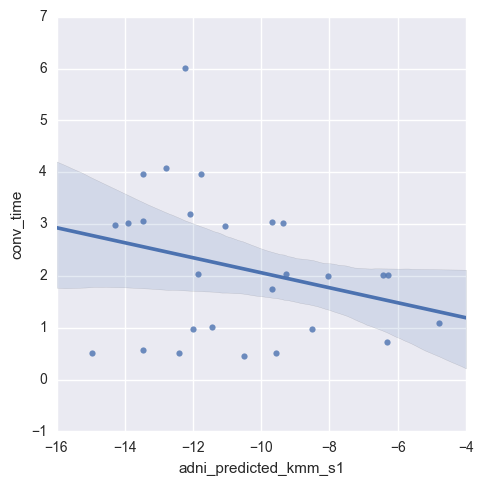

In [79]:
plt.close()
sns.lmplot('adni_predicted_kmm_s1','conv_time',data=adni_bl[adni_bl.converter==1])
plt.show()

In [80]:
stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time'])

(-0.27835807882988339, 0.15974906641179912)

In [81]:
stop = []
for i,row in conv_df.iterrows():
    if i not in stop:
        if pandas.notnull(row['DX']):
            if 'to' in row['DX']:
                print(i,row['DX'],row['Years.bl'])
                adni_bl.ix[i,'conv_time2'] = row['Years.bl']
                stop.append(i)

0729 MCI to Dementia 1.092402464
0778 NL to MCI 4.010951403
2403 MCI to Dementia 3.014373717
4042 MCI to Dementia 1.741273101
4094 MCI to Dementia 0.503764545
4188 MCI to Dementia 2.973305955
4189 MCI to Dementia 0.714579055
4203 MCI to Dementia 1.032169747
4218 NL to MCI 1.018480493
4250 MCI to Dementia 2.034223135
4262 NL to MCI 2.036960986
4270 NL to MCI 4.082135524
4293 MCI to Dementia 2.015058179
4346 MCI to Dementia 3.055441478
4363 MCI to Dementia 3.0171115669999997
4415 MCI to Dementia 2.009582478
4474 NL to MCI 0.45995893200000004
4512 MCI to NL 0.0
4515 MCI to Dementia 0.566735113
4521 MCI to Dementia 2.965092402
4542 MCI to Dementia 0.454483231
4595 MCI to Dementia 0.9691991790000001
4597 MCI to Dementia 3.972621492
4680 MCI to Dementia 0.9774127309999999
4746 MCI to Dementia 3.20054757
4947 MCI to Dementia 0.5092402460000001
5096 NL to MCI 0.517453799


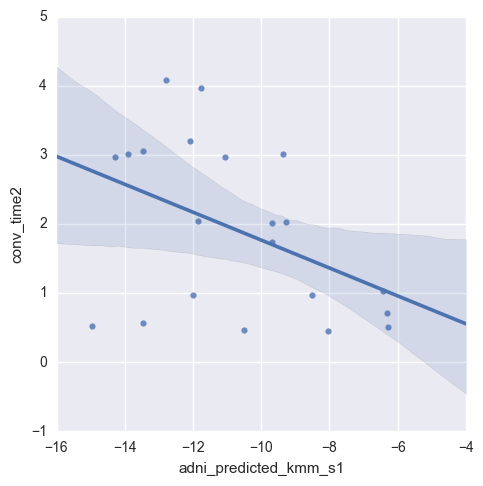

In [82]:
plt.close()
sns.lmplot('adni_predicted_kmm_s1','conv_time2',data=adni_bl[(adni_bl.converter==1) & (
                                    adni_bl['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'] == 1)])
plt.show()

In [1576]:
sns.set_context('notebook')
sns.set_style('white')
sns.set(font_scale=1.5)

In [1557]:
sns.lmplot?

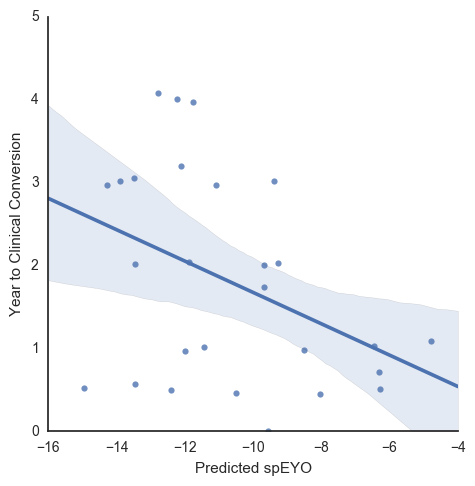

In [464]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_kmm_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [504]:
jnk = adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1']
zs = (jnk - jnk.mean()) / jnk.std()
adni_bl = adni_bl.reindex_axis(adni_bl.columns.tolist()+['z_pred'],axis=1)

0729   NaN
0778   NaN
2403   NaN
4042   NaN
4094   NaN
4188   NaN
4189   NaN
4203   NaN
4218   NaN
4250   NaN
4262   NaN
4270   NaN
4293   NaN
4346   NaN
4363   NaN
4415   NaN
4474   NaN
4512   NaN
4515   NaN
4521   NaN
4542   NaN
4595   NaN
4597   NaN
4680   NaN
4746   NaN
4947   NaN
5096   NaN
Name: z_pred, dtype: float64

In [506]:
adni_bl.ix[adni_bl[adni_bl.converter==1].index,'z_pred'] = zs
#adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred'] = zs
adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred']

0729    2.189447
0778   -0.555693
2403   -1.166687
4042    0.386249
4094   -0.616156
4188   -1.307712
4189    1.626191
4203    1.581624
4218   -0.261881
4250    0.533434
4262   -0.420038
4270   -0.760941
4293   -1.008243
4346   -1.014472
4363    0.499736
4415    0.386642
4474    0.087668
4512    0.429357
4515   -1.006068
4521   -0.127204
4542    0.990546
4595   -0.470499
4597   -0.386209
4680    0.816291
4746   -0.506397
4947    1.637334
5096   -1.556319
Name: z_pred, dtype: float64

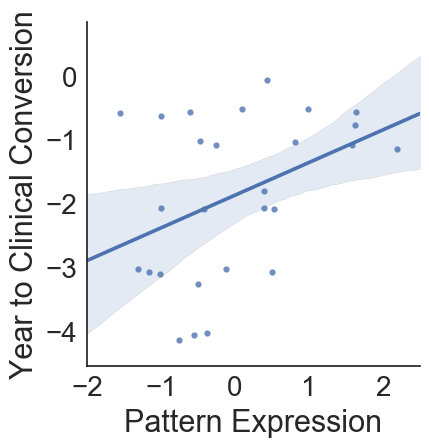

In [511]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('z_pred','inverted_conv2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(-4.5,0.9)
sns.plt.xlabel('Pattern Expression')
sns.plt.ylabel('Year to Clinical Conversion')
sns.plt.xticks([-2.0, -1.0, 0.0, 1.0,2.0])
fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_pattern_expression.pdf')
plt.show()

In [496]:
adni_bl['inverted_conv2'] = adni_bl.conv_time2 * -1

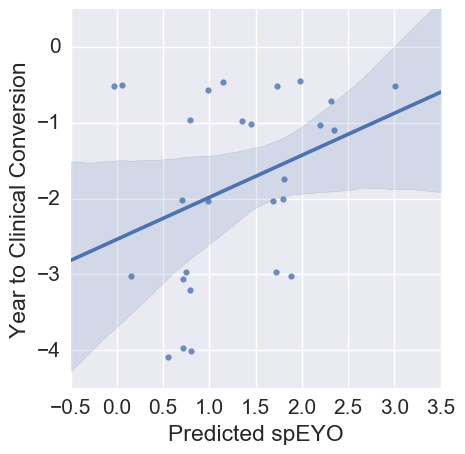

In [1592]:
plt.close()
fig = sns.lmplot('adni_predicted_kmm','inverted_conv2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(-4.5,.5)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion_uncsl.pdf')
plt.show()

In [1580]:
unscl_adni_kmms1 = adni_scl.inverse_transform(adni_bl['adni_predicted_kmm_s1'])

ValueError: operands could not be broadcast together with shapes (148,) (888,) (148,) 

In [252]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)


-0.404886838089 0.0361737149286
r square is 0.163933351658


In [1393]:
r,p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['AGE'])
print(r,p)
print('r square is',r**2)

-0.188135894256 0.347343898258
r square is 0.0353951147074


In [197]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)



-0.404886838089 0.0361737149286
r square is 0.163933351658


In [1377]:
stats.pearsonr(adni_bl[adni_bl.converter==1]['conv_time2'],
              adni_bl[adni_bl.converter==1]['AGE'])

(-0.048802634076182065, 0.80898910056867634)

In [1550]:
jnk = [adni_bl[adni_bl.converter==1]['conv_time2'],
      adni_bl[adni_bl.converter==1]['AGE'],
      adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1']]
agecon = pandas.concat(jnk,axis=1)
smf.ols('conv_time2 ~ AGE + adni_predicted_kmm_s1',data=agecon).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conv_time2   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.700
Date:                Tue, 29 Aug 2017   Prob (F-statistic):             0.0876
Time:                        17:19:26   Log-Likelihood:                -40.961
No. Observations:                  27   AIC:                             87.92
Df Residuals:                      24   BIC:                             91.81
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.9774      2.675      1.487      0.150      -1.543       9.498
AGE                      -0.0277      0.036     -0.761      0.454      -0.103       0.047
adni_predicted_kmm_s1    -9.1181      3.965     -2.299      0.030     -17.302      -0.934
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.694
Skew:                          -0.004   Prob(JB):                        0.707
Kurtosis:                       2.215   Cond. No.                     1.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1375]:
adni_bl.columns[:20]

Index(['RID', 'VISCODE', 'VISupdate', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX.bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'PTID', 'SITE', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA.1'],
      dtype='object')

In [262]:
pad_mm_full = pandas.concat([mm_train,mm_test])
pad_mm_full = pad_mm_full[pad_mm_full.columns[:888]]

In [266]:
# REVERSE MODEL
ldy = adni_bl[adni_bl.converter==1]['conv_time']
y_pad_mm_full = ld_05.loc[pad_mm_full.index].tPSO
p_cutoff = None
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
revoutput = kfold_feature_learning(
                                                    adni_mm[adni_bl.converter == 1],
                                                    pad_mm_full,ldy,y_pad_mm_full, folds,
                                                    p_cutoff,output='light',scale=True)






running correlation for fold 1 of 3
running lasso for fold 1 of 3
intercept: 2.22391761143
running correlation for fold 2 of 3
running lasso for fold 2 of 3
intercept: 2.07233313293
running correlation for fold 3 of 3
running lasso for fold 3 of 3
intercept: 2.29355844556
4 features selected
validation prediction accuracy is 10.0415524643 percent 
 p = 0.107292673111 
 r = -0.316884087078
testing prediction accuracy is 2.89530668912 percent 
 p = 0.0144773636917 
 r = -0.170156007509


In [1351]:
hits = [i for i in revmod_weights.index if abs(revmod_weights[i]) > 0 ]
hits

[2, 13, 41, 198, 269, 277, 321, 347, 374]

In [ ]:
# THE REGIONS ARE ALMOST TOTALLY NON OVERLAPPING. DO THIS AGAIN BUT ON THE TRAINING SET ONLY.
# THEN, COMBINE FEATURES TO PREDICT TESTING SET?

In [1364]:
super_weights = (revmod_weights + kmm_weights[:888]) / 2
super_weights2 = (revmod_weights * 0.047) + (kmm_weights[:888] * 0.20)

In [1365]:
super_predicted = (mm_test[mm_test.columns[:888]] * super_weights).sum(axis=1)
super_predicted2 = (mm_test[mm_test.columns[:888]] * super_weights2).sum(axis=1)

In [1368]:
stats.pearsonr(super_predicted2,ld_05.loc[mm_test.index].tPSO)

(0.40010328066768686, 0.00072338079712949536)

In [ ]:
# maybe try again after scaling?
# if super bored, run model again but without subjects past 0 on tPSO


In [1398]:
ld_05.columns[:15]

Index(['Column 1', 'Unnamed: 0', 'Unnamed: 0.1', 'Gender', 'Age', 'FD',
       'ApoE4_status', 'tPSO', 'p0_dens', 'p1_dens', 'p2_dens', 'p3_dens',
       'p4_dens', 'p5_dens', 'p6_dens'],
      dtype='object')

In [1401]:
jnk = pandas.concat([mm_train,mm_test])

In [1406]:
ld_05['PSO'] = ld_05['Age'] - ld_05['tPSO']

In [1414]:
stats.chisqprob?

In [1415]:
# DEMOGRAPHICS
cols = ['Age','Gender','FD','tPSO','PSO']
for col in cols:
    mn = ld_05.loc[mm_train.index][col].mean()
    sd = ld_05.loc[mm_train.index][col].std()
    print('training -- %s mean:'%col,mn)
    print('training -- %s sd:'%col,sd)
    mn = ld_05.loc[mm_test.index][col].mean()
    sd = ld_05.loc[mm_test.index][col].std()
    print('test -- %s mean:'%col,mn)
    print('test -- %s sd:'%col,sd)
    mn = ld_05.loc[jnk.index][col].mean()
    sd = ld_05.loc[jnk.index][col].std()
    print('total -- %s mean:'%col,mn)
    print('total -- %s sd:'%col,sd)
    if col != 'Gender':
        t,p = stats.ttest_ind(ld_05.loc[mm_test.index][col], ld_05.loc[mm_train.index][col])
    print(col,'test value = %s, p = %s'%(t,p))

training -- Age mean: 62.89855072463768
training -- Age sd: 4.758840954196224
test -- Age mean: 62.220588235294116
test -- Age sd: 5.296705786253205
total -- Age mean: 62.6747572815534
total -- Age sd: 4.94023241176605
Age test value = -0.925907219727, p = 0.355588243192
training -- Gender mean: 0.2753623188405797
training -- Gender sd: 0.4483239825330468
test -- Gender mean: 0.20588235294117646
test -- Gender sd: 0.4073512375440995
total -- Gender mean: 0.2524271844660194
total -- Gender sd: 0.4354632319488645
Gender test value = -0.925907219727, p = 0.355588243192
training -- FD mean: 0.21698550724637686
training -- FD sd: 0.052498451212086544
test -- FD mean: 0.20980882352941185
test -- FD sd: 0.049281481294653255
total -- FD mean: 0.21461650485436878
total -- FD sd: 0.05144974834058697
FD test value = -0.94119582794, p = 0.3477176974
training -- tPSO mean: -11.173913043478262
training -- tPSO sd: 8.11047177786451
test -- tPSO mean: -11.264705882352942
test -- tPSO sd: 7.77408178972

In [1417]:
# DEMOGRAPHICS
cols = ['tiv']
for col in cols:
    mn = pad.loc[mm_train.index][col].mean()
    sd = pad.loc[mm_train.index][col].std()
    print('training -- %s mean:'%col,mn)
    print('training -- %s sd:'%col,sd)
    mn = pad.loc[mm_test.index][col].mean()
    sd = pad.loc[mm_test.index][col].std()
    print('test -- %s mean:'%col,mn)
    print('test -- %s sd:'%col,sd)
    mn = pad.loc[jnk.index][col].mean()
    sd = pad.loc[jnk.index][col].std()
    print('total -- %s mean:'%col,mn)
    print('total -- %s sd:'%col,sd)
    if col != 'Gender':
        t,p = stats.ttest_ind(pad.loc[mm_test.index][col], pad.loc[mm_train.index][col])
    print(col,'test value = %s, p = %s'%(t,p))

training -- tiv mean: 1.397611673913041
training -- tiv sd: 0.18417481231180843
test -- tiv mean: 1.373633794117644
test -- tiv sd: 0.1166424373837528
total -- tiv mean: 1.3896966456310658
total -- tiv sd: 0.1650549891490138
tiv test value = -0.980395666475, p = 0.328052096841


In [1432]:
print(pad.loc[mm_train.index]['Gender'].sum())
print(len(pad.loc[mm_train.index]['Gender']) - pad.loc[mm_train.index]['Gender'].sum())
print(pad.loc[mm_test.index]['Gender'].sum())
print(len(pad.loc[mm_test.index]['Gender']) - pad.loc[mm_test.index]['Gender'].sum())

37.0
101.0
14.0
54.0


In [192]:
adnidf.ix['4512',['DX','Years.bl']]

DX  Years.bl
4512  MCI to NL  0.000000
4512        NaN  0.213552
4512  NL to MCI  0.511978
4512        MCI  1.122519
4512        NaN  1.535934
4512        MCI  1.984942
4512        NaN  3.003422

In [497]:
adni_bl.ix['4512','DX'] = 'MCI'
adni_bl.ix['4512','conv_time2'] = 0.511978

In [1538]:
converters = adni_bl[adni_bl.converter==1]
code = {'NL': 0, 'MCI': 1}
converters['DX_code'] = [code[x] for x in converters['DX']]
code = {'Male': 1, 'Female': 0}
converters['Sex_code'] = [code[x] for x in converters['PTGENDER']]

cols = ['AGE','DX_code','Sex_code','conv_time2']
for col in cols:
    print(col,'mean = ',converters[col].mean())
    print(col,'std = ',converters[col].std())

AGE mean =  72.84444444444443
AGE std =  6.411488086800088
DX_code mean =  0.7777777777777778
DX_code std =  0.42365927286816185
Sex_code mean =  0.48148148148148145
Sex_code std =  0.5091750772173157
conv_time2 mean =  1.8317235748888887
conv_time2 std =  1.2441453993074942


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1457]:
converters.columns

Index(['RID', 'VISCODE', 'VISupdate', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX.bl', 'AGE', 'PTGENDER', 'PTEDUCAT',
       ...
       'adni_predicted_kmm', 'converter', 'converter_anal', 'conv_time',
       'conv_time2', 'adni_predicted_kmm_s1', 'adni_predicted_kmm_s2',
       'adni_predicted_kamm', 'adni_predicted_kamm_s1',
       'adni_predicted_kamm_s2'],
      dtype='object', length=218)

In [1547]:
has_gend = adni_bl[pandas.notnull(adni_bl.PTGENDER)]

In [1492]:
code = {'Male': 1, 'Female': 0}
has_gend['Sex_code'] = [code[x] for x in has_gend['PTGENDER']]

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [1495]:
#adni_mm_cov

In [1500]:
adni_mm_cov = deepcopy(adni_mm)
adni_mm_cov['Age'] = has_gend.loc[adni_mm.index]['AGE']
adni_mm_cov['Gender'] = has_gend.loc[adni_mm.index]['Sex_code']
adni_mm_cov_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(
                              adni_mm_cov.loc[has_gend.index]),
                              index=has_gend.index,columns = adni_mm_cov.columns)
jnk = preprocessing.StandardScaler().fit(mm_cov_train[mm_cov_train.columns[:890]])
adni_mm_cov_s2 = pandas.DataFrame(jnk.transform(adni_mm_cov.loc[has_gend.index]), 
                                                      index=has_gend.index, 
                                                      columns=adni_mm_cov.columns)


In [1532]:
#len(kcmm_weights[:890]) == 
adni_mm_cov.loc[has_gend.index].shape

(137, 890)

In [1524]:
adni_predicted_kcmm = (kcmm_weights[:890] * adni_mm_cov.loc[has_gend.index]).sum(axis=1)
adni_predicted_kcmm_s1 = (kcmm_weights[:890] * adni_mm_cov_s1).sum(axis=1)
adni_predicted_kcmm_s2 = (kcmm_weights[:890] * adni_mm_cov_s2).sum(axis=1)

In [1525]:
adni_bl.loc[has_gend.index]['adni_predicted_kcmm'] = adni_predicted_kcmm
adni_bl.loc[has_gend.index]['adni_predicted_kcmm_s1'] = adni_predicted_kcmm_s1
adni_bl.loc[has_gend.index]['adni_predicted_kcmm_s2'] = adni_predicted_kcmm_s2

In [1548]:
has_gend['adni_predicted_kcmm'] = adni_predicted_kcmm
has_gend['adni_predicted_kcmm_s1'] = adni_predicted_kcmm_s1
has_gend['adni_predicted_kcmm_s2'] = adni_predicted_kcmm_s2
has_gend.head()

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

RID VISCODE  VISupdate COLPROT ORIGPROT   EXAMDATE DX.bl   AGE  \
0107  107.0      bl        0.0   ADNI1    ADNI1  2/27/2006  LMCI  60.7   
0186  186.0      bl        0.0   ADNI1    ADNI1   3/6/2006    CN  80.4   
0295  295.0      bl        0.0   ADNI1    ADNI1   5/9/2006    CN  84.8   
0685  685.0      bl        0.0   ADNI1    ADNI1  7/20/2006    CN  89.6   
0729  729.0      bl        0.0   ADNI1    ADNI1   8/2/2006  LMCI  65.1   

     PTGENDER  PTEDUCAT           ...           conv_time conv_time2  \
0107   Female      19.0           ...                 NaN        NaN   
0186   Female      16.0           ...                 NaN        NaN   
0295     Male      18.0           ...                 NaN        NaN   
0685   Female      16.0           ...                 NaN        NaN   
0729   Female      16.0           ...            1.092402   1.092402   

     adni_predicted_kmm_s1 adni_predicted_kmm_s2  adni_predicted_kamm  \
0107              0.012970             -0.163206            -0.332400   
0186              0.072060             -0.166932             0.041797   
0295              0.018157             -0.180702            -0.167203   
0685             -0.004811             -0.245009             0.302690   
0729              0.142693              0.049505             1.630116   

      adni_predicted_kamm_s1  adni_predicted_kamm_s2  adni_predicted_kcmm  \
0107               -0.031570               -0.017699             1.410477   
0186                0.003740                0.024652             1.889875   
0295               -0.008073               -0.038259             1.580766   
0685                0.044455                0.063747             0.683023   
0729                0.138682                0.217991             2.313000   

      adni_predicted_kcmm_s1  adni_predicted_kcmm_s2  
0107                0.015767               -0.143592  
0186                0.074177               -0.148152  
0295                0.019668               -0.156107  
0685               -0.002654               -0.220201  
0729                0.149676                0.063568  

[5 rows x 221 columns]

In [1549]:
r,p = stats.pearsonr(has_gend[has_gend.converter==1]['adni_predicted_kcmm_s1'],
              has_gend[has_gend.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)

-0.405239507553 0.0359963558502
r square is 0.164219058482


In [1518]:
len(has_gend[has_gend.converter==1]['adni_predicted_kcmm_s1'])

27

In [421]:
jnk1 = adni_mm[adni_bl.converter==1]
sig_feats_test = jnk1[kmm_weights[abs(kmm_weights)>0].index]
sig_feats_test.ix[:,'Age'] = adni_bl.loc[jnk1.index]['AGE']
sig_feats_test.ix[:,'Gender'] = adni_bl.loc[jnk1.index]['PTGENDER']
sig_feats_test.ix[:,'conv'] = adni_bl.loc[jnk1.index]['conv_time2']
sig_feats_test.columns = ['roi_%s'%x for x in sig_feats_test.columns[:-3]] + [
                                                        'Age', 'Gender','conv']
sf_df_test = pandas.DataFrame(index = sig_feats_test.columns[:-3],
                              columns=['r','p','reg_t','reg_p'])

for i in sig_feats_test.columns[:-3]:
    r,p = stats.pearsonr(sig_feats_test[i],adni_bl.loc[jnk1.index].conv_time2)
    sf_df_test.ix[i,'r'] = r
    sf_df_test.ix[i,'p'] = p
    stmt = 'conv ~ Age + Gender + %s'%(i)
    mod = smf.ols(stmt,data=sig_feats_test).fit()
    t = mod.tvalues[-1]
    p = mod.pvalues[-1]
    sf_df_test.ix[i,'reg_t'] = t
    sf_df_test.ix[i,'reg_p'] = p
    print(i,p)

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


roi_18 0.0764509469016
roi_31 0.544516626256
roi_45 0.142864439571
roi_52 0.724362287449
roi_75 0.880682347728
roi_96 0.223539259661
roi_131 0.0507069820231
roi_137 0.112742338591
roi_142 0.504200906981
roi_226 0.250882573066
roi_239 0.303742761613
roi_242 0.269831642181
roi_292 0.25296405621
roi_294 0.301161847518
roi_321 0.0257748536076
roi_330 0.119174008578
roi_351 0.0963207557827
roi_390 0.0861532916752
roi_444 0.265843037594
roi_471 0.362603289393
roi_479 0.350830415539
roi_481 0.994747036759
roi_511 0.083262426554
roi_531 0.206183649118
roi_551 0.413276943294
roi_576 0.646485738012
roi_584 0.897754139738
roi_586 0.17506161093
roi_597 0.595607053282
roi_602 0.822062053711
roi_611 0.244950281998
roi_628 0.963859729155
roi_632 0.503407080707
roi_647 0.77587574627
roi_654 0.924530681577
roi_656 0.528447837646
roi_670 0.817689690011
roi_673 0.470097081267
roi_693 0.823088420774
roi_695 0.625097365931
roi_703 0.874019645163
roi_721 0.2601611339
roi_728 0.39886859487
roi_747 0.46789002

In [422]:
sf_df_test

r          p       reg_t      reg_p
roi_18    0.299033   0.129718     1.85506  0.0764509
roi_31   -0.132082   0.511356   -0.615116   0.544517
roi_45    0.226175   0.256625     1.51711   0.142864
roi_52   0.0587166   0.771117    0.356979   0.724362
roi_75   0.0128926    0.94911    0.151782   0.880682
roi_96    0.221694    0.26642     1.25092   0.223539
roi_131   0.273297   0.167795     2.06176   0.050707
roi_137   0.260526    0.18936     1.64899   0.112742
roi_142   0.103091   0.608863    0.678539   0.504201
roi_226   0.199098   0.319444      1.1779   0.250883
roi_239   0.185132   0.355236     1.05197   0.303743
roi_242   0.144296    0.47271     1.13071   0.269832
roi_292    0.12674   0.528728     1.17259   0.252964
roi_294    0.17582   0.380366     1.05773   0.301162
roi_321   0.376476  0.0529225     2.38379  0.0257749
roi_330   0.247597   0.213068     1.61856   0.119174
roi_351   0.295244   0.134888     1.73391  0.0963208
roi_390    0.31482   0.109727     1.79289  0.0861533
roi_444  -0.219394   0.271539    -1.14043   0.265843
roi_471  -0.190901   0.340172    -0.92887   0.362603
roi_479   0.184788   0.356148    0.952332    0.35083
roi_481  0.0144562   0.942947 -0.00665559   0.994747
roi_511   0.352336  0.0714723     1.81075  0.0832624
roi_531     0.2629   0.185213     1.30088   0.206184
roi_551   0.176922   0.377341    0.833244   0.413277
roi_576  0.0965879   0.631754    0.464742   0.646486
roi_584  0.0391012   0.846461    0.129927   0.897754
roi_586  -0.279055   0.158663    -1.39931   0.175062
roi_597 -0.0952729   0.636424   -0.538204   0.595607
roi_602 -0.0635464   0.752845   -0.227478   0.822062
roi_611   -0.23124    0.24584    -1.19321    0.24495
roi_628 -0.0143513   0.943361  -0.0458067    0.96386
roi_632   0.141513   0.481382    0.679815   0.503407
roi_647 -0.0379672   0.850864   -0.288067   0.775876
roi_654 -0.0313336   0.876705  -0.0957727   0.924531
roi_656   0.136589   0.496916    0.640077   0.528448
roi_670 -0.0235142   0.907322   -0.233173    0.81769
roi_673   0.161209   0.421799    0.734449   0.470097
roi_693 -0.0365352   0.856431   -0.226142   0.823088
roi_695  0.0987313   0.624171    0.495286   0.625097
roi_703 -0.0223827   0.911764   -0.160332    0.87402
roi_721   0.235314   0.237384     1.15447   0.260161
roi_728   0.179308   0.370837    0.859623   0.398869
roi_747  -0.155374   0.439013   -0.738148    0.46789
roi_773   -0.24432   0.219383    -1.23829     0.2281
roi_779   0.275982   0.163493      1.3578     0.1877
roi_781 -0.0488921   0.808645   -0.208162   0.836935
roi_797  -0.298511   0.130423    -1.49633   0.148165
roi_819 -0.0040431   0.984032  -0.0151668    0.98803
roi_822 -0.0851866   0.672684   -0.558376   0.581983
roi_838   0.111577    0.57953    0.477806   0.637298
roi_850  -0.115073   0.567629   -0.537396   0.596156
roi_857   0.380963  0.0499347      2.0521   0.051712

In [525]:
adni_bl.columns.tolist()

['RID',
 'VISCODE',
 'VISupdate',
 'COLPROT',
 'ORIGPROT',
 'EXAMDATE',
 'DX.bl',
 'AGE',
 'PTGENDER',
 'PTEDUCAT',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'PTID',
 'SITE',
 'APOE4',
 'FDG',
 'PIB',
 'AV45',
 'ABETA.1',
 'ABETA.2',
 'ABETA.3',
 'ABETA.4',
 'ABETA.5',
 'ABETA.6',
 'ABETA.7',
 'ABETA.8',
 'ABETA.MEDIAN',
 'ABETA.RAW.1',
 'ABETA.RAW.2',
 'ABETA.RAW.3',
 'ABETA.RAW.4',
 'ABETA.RAW.5',
 'ABETA.RAW.6',
 'ABETA.RAW.7',
 'ABETA.RAW.8',
 'ABETA.RAW.MEDIAN',
 'PTAU.1',
 'PTAU.2',
 'PTAU.3',
 'PTAU.4',
 'PTAU.5',
 'PTAU.6',
 'PTAU.7',
 'PTAU.8',
 'PTAU.MEDIAN',
 'PTAU.RAW.1',
 'PTAU.RAW.2',
 'PTAU.RAW.3',
 'PTAU.RAW.4',
 'PTAU.RAW.5',
 'PTAU.RAW.6',
 'PTAU.RAW.7',
 'PTAU.RAW.8',
 'PTAU.RAW.MEDIAN',
 'TAU.1',
 'TAU.2',
 'TAU.3',
 'TAU.4',
 'TAU.5',
 'TAU.6',
 'TAU.7',
 'TAU.8',
 'TAU.MEDIAN',
 'TAU.RAW.1',
 'TAU.RAW.2',
 'TAU.RAW.3',
 'TAU.RAW.4',
 'TAU.RAW.5',
 'TAU.RAW.6',
 'TAU.RAW.7',
 'TAU.RAW.8',
 'TAU.RAW.MEDIAN',
 'CDRSB',
 'ADAS11',
 'ADAS13',
 'MMSE',
 'RAVLT.immediate',


In [533]:
adz = adni_bl[
        (adni_bl.DX=='Dementia') & (adni_bl['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'] == 1)
        ].index
adz_mm = adni_mm.loc[adz]

In [604]:
#nlz = adni_bl[
#        (adni_bl.DX=='NL') & (adni_bl['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'] == 0)
#        ].index
nlz = adni_bl[adni_bl.DX=='NL'].index
nlz_mm = adni_mm.loc[nlz]

In [605]:
ts,ps = stats.ttest_ind(adz_mm,nlz_mm)

In [606]:
ad_v_ctl = FDR(ps)

In [549]:
pad_ts = gm_tvals+ld_tvals[:444]

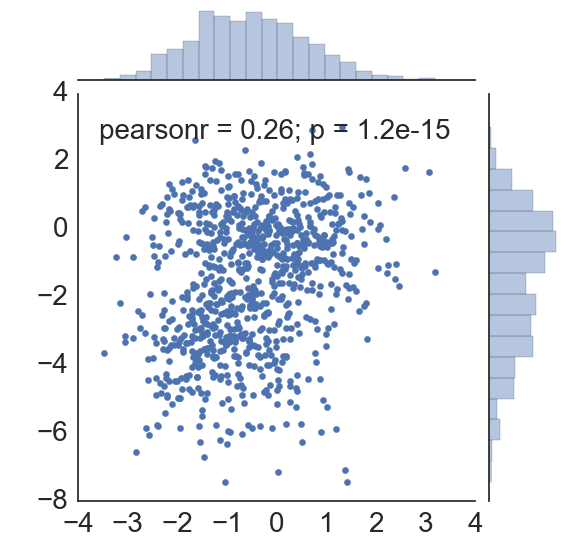

In [607]:
plt.close
sns.jointplot(np.array(pad_ts),np.array(ts[:888]))
plt.show()

In [626]:
stats.spearmanr(pad_ts[:444],ts[:444])

SpearmanrResult(correlation=0.057068999910200098, pvalue=0.23009784723700138)

In [601]:
['structural']*3

['structural', 'structural', 'structural']

In [608]:
forplot = pandas.concat([pandas.Series(pad_ts),pandas.Series(ts[:888])],axis=1)
forplot.columns = ['Prevent-AD T-Values','ADNI T-Values']
forplot['Modality'] = (['structural']*444) + (['functional']*444)

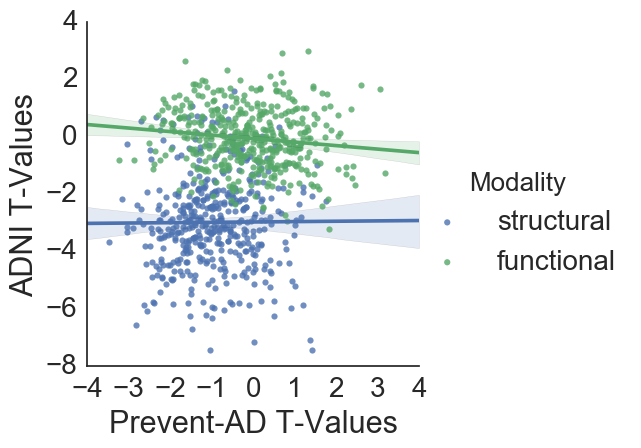

In [609]:
plt.close()
sns.lmplot('Prevent-AD T-Values','ADNI T-Values',data=forplot,hue='Modality')
plt.show()

In [572]:
for sub in adni_bl.index:
    if pandas.notnull(adni_bl.ix[sub,'PTGENDER']):
        if adni_bl.ix[sub,'PTGENDER'] == 'Male':
            adni_bl.ix[sub,'Gender'] = 1
        else:
            adni_bl.ix[sub,'Gender'] = 0

In [574]:
all_mm = adni_mm.loc[nlz.tolist() + adz.tolist()]
all_mm['age'] = adni_bl.loc[nlz.tolist() + adz.tolist()]['AGE']
all_mm['gend'] = adni_bl.loc[nlz.tolist() + adz.tolist()]['Gender']
all_mm['edu'] = adni_bl.loc[nlz.tolist() + adz.tolist()]['PTEDUCAT']
all_mm['dx'] = adni_bl.loc[nlz.tolist() + adz.tolist()]['DX']

In [576]:
all_mm.columns = ['feat_%s'%x for x in range(888)] + ['age','gend','edu','dx']

In [590]:
code = dict(zip(all_mm.dx.unique(),range(2)))
for sub in all_mm.index:
    all_mm.ix[sub,'dx'] = code[all_mm.ix[sub,'dx']]

In [592]:
for col in all_mm.columns:
    all_mm[col] = all_mm[col].astype(float)

In [593]:
adni_tvals = []
adni_pvals = []
for i in range(all_mm.shape[1] - 4):
    mod = smf.ols('dx ~ age + gend + edu + feat_%s'%i,data=all_mm).fit()
    adni_tvals.append(mod.tvalues[-1])
    adni_pvals.append(mod.pvalues[-1])

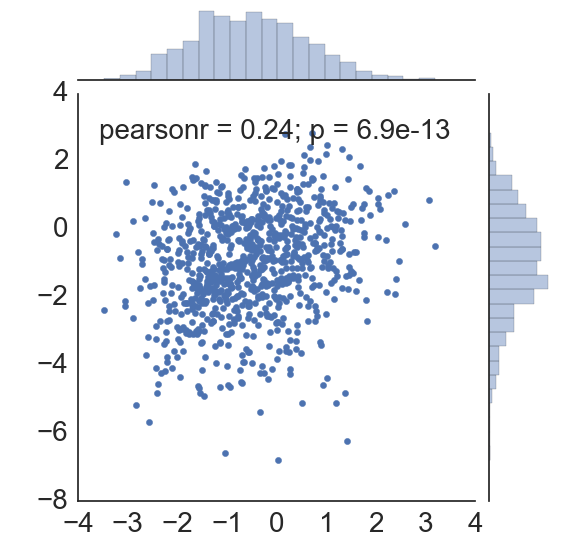

In [594]:
plt.close
sns.jointplot(np.array(pad_ts),np.array(adni_tvals[:888]))
plt.show()

In [610]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ts[:444])):
    sc444[sc444==(i+1)] = ts[i]
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl')

In [612]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ts[:444])):
    if ad_v_ctl[0][i]:
        sc444[sc444==(i+1)] = ts[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_thr')

In [616]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ts[:444])):
    if ad_v_ctl[1][i] < 0.01:
        sc444[sc444==(i+1)] = ts[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_thr01')

In [614]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ts[444:])):
    sc444[sc444==(i+1)] = ts[i+444]
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_LD')

In [615]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ts[444:])):
    if ad_v_ctl[0][i+444]:
        sc444[sc444==(i+1)] = ts[i+444]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_FD_thr')

In [627]:
sorted(ts[:444][ps[:444]<(0.05 / 444)])[-1]

-4.1872459917210287

In [621]:
jnk = ni.load(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_thr01.nii')
aff = jnk.affine
dat = jnk.get_data()
dat[dat<-4.187] = 1
dat[dat!=1] = 0
nimg = ni.Nifti1Image(dat,aff)
nimg.to_filename('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ADNI_ad_v_ctl_GM_bin')

In [622]:
jnk = ni.load(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_tvals_tiv.nii')
aff = jnk.affine
dat = jnk.get_data()
dat[dat<-0.1] = 1
dat[dat!=1] = 0
nimg = ni.Nifti1Image(dat,aff)
nimg.to_filename('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_tiv_bin')

In [623]:
jnk = ni.load(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_glm_tvals.nii')
aff = jnk.affine
dat = jnk.get_data()
dat[dat!=0] = 1
nimg = ni.Nifti1Image(dat,aff)
nimg.to_filename('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_glm_bin')

In [638]:
jnk = ni.load(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/AD_fmri_FDR_0p01_bin_3mm.nii.gz')
aff = jnk.affine
dat = jnk.get_data()
sc444 = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz'
               ).get_data()
tot = np.bincount(sc444.astype(int).flat)
sumz = np.bincount(sc444.astype(int).flat,weights=dat.flat)
means = sumz/tot

for i,m in enumerate(means):
    if i != 0:
        sc444[sc444==i] = means[i]
sc444[sc444>0.1] = 1
sc444[sc444!=1] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/AD_fmri_FDR_0p01_bin_3mm_lores')

In [639]:
means[means>0.1]

array([ 0.16666667,  0.125     ,  0.41975309,  0.26966292,  0.1372549 ,
        0.1375    ,  0.25      ,  0.11214953,  0.17948718,  0.15116279,
        0.12121212,  0.17857143,  0.12941176,  0.15286624,  0.54166667,
        0.37569061,  0.17647059,  0.54285714,  0.2195122 ,  0.51094891,
        0.18079096,  0.24347826,  0.27906977,  0.74257426,  0.20183486,
        0.30769231,  0.12745098,  0.10784314,  0.58479532,  0.63366337,
        0.16161616,  0.25301205,  0.14457831,  0.25263158,  0.29032258,
        0.81818182,  0.18340611,  0.16504854,  0.22368421,  0.30833333,
        0.30434783,  0.11764706,  0.14492754])

In [640]:
121 * 145 * 121

2122945

In [642]:
53*64*52

176384

In [3]:
sys.path.insert(0,'/Users/jakevogel/git/hack_projects/')
import kfold_learning as kfl

In [54]:
kfl.feature_learning_optimizer?

In [185]:
from importlib import reload

In [172]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [61]:
outdir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_tst1/'
model_out = kfl.feature_learning_optimizer(mm_train, mm_test, ldy, ldt_y, 
                                           clfs = {'lasso': linear_model.LassoCV(cv=10)}, outdir = outdir)

running 35 different tests
********** working on model lasso **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 5 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 5 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 5 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 5 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 5 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 5 fold cross-validation **
** using 10 fold cross-validation **
** using 20 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 5 fold cross-validation **
** using 10 fold cross-validation **
** using 20 fold cross-validation **
optimal model is as follows 
 model: lasso 
 p: None 
 fold 2 
maximum validation accuracy: 60.1423465949
('**********', 'RUNNING OPTIMAL MODEL', '**********')


NameError: name 'models' is not defined

In [66]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = None
folds = 5
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmm_weights, kmm_predicted, kmmtest_predicted, allint = kfold_feature_learning(
                                                    mm_train,mm_test,ldy,ldt_y, folds,
                                                    p_cutoff,output='light',scale=True)



running correlation for fold 1 of 5
running lasso for fold 1 of 5
intercept: -8.67418201616
running correlation for fold 2 of 5
running lasso for fold 2 of 5
intercept: -10.1285134939
running correlation for fold 3 of 5
running lasso for fold 3 of 5
intercept: -11.0010609664
running correlation for fold 4 of 5
running lasso for fold 4 of 5
intercept: -12.0033234492
running correlation for fold 5 of 5
running lasso for fold 5 of 5
intercept: -14.2117265758
39 features selected
validation prediction accuracy is 32.8908511797 percent 
 p = 1.95339255955e-13 
 r = -0.573505459257
testing prediction accuracy is 15.7853478514 percent 
 p = 0.000794285118387 
 r = 0.397307788137


In [63]:
odf = pandas.read_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_tst1/optimizer_results')

In [64]:
odf

Unnamed: 0    clf      p  fold        acc
0            0  lasso    NaN     2  60.142347
1            1  lasso    NaN     3  52.743206
2           30  lasso  0.001     2  51.263788
3            5  lasso  0.200     2  50.029952
4           25  lasso  0.005     2  49.606203
5           20  lasso  0.010     2  45.184183
6           15  lasso  0.050     2  41.600222
7           10  lasso  0.100     2  41.566762
8            2  lasso    NaN     5  32.890851
9           21  lasso  0.010     3  32.005559
10          31  lasso  0.001     3  31.655035
11          11  lasso  0.100     3  31.356748
12          16  lasso  0.050     3  30.795158
13           6  lasso  0.200     3  28.660230
14          26  lasso  0.005     3  25.763069
15           3  lasso    NaN    10  15.608783
16          32  lasso  0.001     5  13.981956
17           7  lasso  0.200     5  11.464296
18          17  lasso  0.050     5  10.930892
19          12  lasso  0.100     5   9.942189
20          27  lasso  0.005     5   7.488091
21          22  lasso  0.010     5   6.355650
22           8  lasso  0.200    10   4.084665
23           4  lasso    NaN    20   3.437273
24          13  lasso  0.100    10   3.118773
25          24  lasso  0.010    20   2.811019
26          29  lasso  0.005    20   1.516745
27          19  lasso  0.050    20   1.285215
28          14  lasso  0.100    20   1.266824
29          18  lasso  0.050    10   0.594382
30          33  lasso  0.001    10   0.564660
31          34  lasso  0.001    20   0.449186
32          23  lasso  0.010    10   0.073158
33           9  lasso  0.200    20   0.031400
34          28  lasso  0.005    10   0.004655

In [67]:
from sklearn import model_selection

In [104]:
params1 = {'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty': ['none', 'l2', 'l1'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
          'epsilon': [0.001, 0.01, 0.05, 0.1, 0.2]} 
params2 = {'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty': ['elasticnet'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
          'l1_ratio': [0.05,0.1,0.15,0.2,0.3,0.5],
          'epsilon': [0.001, 0.01, 0.05, 0.1, 0.2]} 
params3 = {'loss': ['squared_loss'],
          'penalty': ['none', 'l2', 'l1'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}
params4 = {'loss': ['squared_loss'],
          'penalty': ['elasticnet'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
          'l1_ratio': [0.05,0.1,0.15,0.2,0.3,0.5]}
 

In [125]:
selector = model_selection.GridSearchCV(linear_model.SGDRegressor(random_state=123),
                                        [params1, params2, params3, params4],cv=3,
                                       scoring = 'neg_mean_squared_error')

In [124]:
model_selection.GridSearchCV?

In [91]:
selected = selector.fit(mm_train,ldy)

In [95]:
selected.

-1.8655013205011803

In [97]:
jnk = selected.best_estimator_.fit(mm_train,ldy)

In [96]:
selected.score(mm_test,ldt_y)

0.015603469669281944

In [88]:
selected.

0.065217391304347824

In [86]:
mm_test.shape

(68, 891)

In [94]:
linear_model.SGDRegressor?

In [99]:
sys.path.insert(0,'/Users/jakevogel/git/hack_projects/')
import kfold_learning as kfl

In [101]:
from importlib import reload

In [147]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [156]:
shuffler1 = np.random.permutation(mm_train.index)
shuffler2 = np.random.permutation(mm_test.index)

In [126]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
output = kfl.kfold_feature_learning(mm_train.loc[shuffler1],mm_test,ldy,ldt_y, clf = selector, folds = 10, 
                                    p_cutoff = 0.01,search = True, output='light',scale=True)




running correlation for fold 1 of 10
running model for fold 1 of 10
running correlation for fold 2 of 10
running model for fold 2 of 10
running correlation for fold 3 of 10
running model for fold 3 of 10
running correlation for fold 4 of 10
running model for fold 4 of 10
running correlation for fold 5 of 10
running model for fold 5 of 10
running correlation for fold 6 of 10
running model for fold 6 of 10
running correlation for fold 7 of 10
running model for fold 7 of 10
running correlation for fold 8 of 10
running model for fold 8 of 10
running correlation for fold 9 of 10
running model for fold 9 of 10
running correlation for fold 10 of 10
running model for fold 10 of 10
119 features selected
validation prediction accuracy is 1.69917373488 percent 
 p = 0.127540053896 
 r = 0.130352358432
testing prediction accuracy is 15.0549671237 percent 
 p = 0.00107787223459 
 r = 0.388007308227


## Build some models

In [142]:
lmodels = {'elasticnet': linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10),
 'Lars': linear_model.LarsCV(normalize=False,cv=10),
 'Lasso': linear_model.LassoCV(cv=10),
 'LassoLars': linear_model.LassoLarsCV(normalize=False,cv=10),
 'LassoLarsIC': linear_model.LassoLarsIC(normalize=False)}
 
 

In [148]:
outdir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_tst_all_lin/'
model_out = kfl.feature_learning_optimizer(mm_train, mm_test, ldy, ldt_y, clfs = lmodels, 
                                           folds = [2,3,10], outdir = outdir, search = False)

running 105 different tests
********** working on model LassoLarsIC **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 168 iterations, alpha=2.525e-02, previous alpha=3.791e-03, with an active set of 89 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 73 iterations, alpha=1.988e-01, previous alpha=4.524e-02, with an active set of 48 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 253 iterations, alpha=5.461e-02, previous alpha=2.753e-03, with an active set of 122 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 204 iterations, alpha=7.358e-03, previous alpha=5.598e-04, with an active set of 123 regressors.
  ConvergenceWarning)


***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=4.745e-02, previous alpha=3.954e-02, with an active set of 30 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 182 iterations, alpha=3.954e-02, previous alpha=8.845e-03, with an active set of 89 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 173 iterations, alpha=3.934e-02, previous alpha=1.536e-02, with an active set of 108 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 177 iterations, alpha=1.910e-02, previous alpha=1.910e-02, with an active set of 112 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 210 iterations, alpha=2.558e-02, previous alpha=1.568e-02, with an active set of 119

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 75 iterations, alpha=2.263e-01, previous alpha=5.714e-03, with an active set of 52 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 77 iterations, alpha=6.627e-02, previous alpha=3.429e-02, with an active set of 62 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 100 iterations, alpha=3.181e-02, previous alpha=3.165e-02, with an active set of 71 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 69 iterations, alpha=1.680e-01, previous alpha=2.031e-02, with an active set of 54 regressors.
  ConvergenceWarning)


***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=4.757e-02, previous alpha=4.896e-03, with an active set of 32 regressors.
  ConvergenceWarning)


***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model Lars **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=6.118e-01, with an active set of 85 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=1.517e+00, with an active set of 62 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=3.647e+00, with an active set of 64 regressors, and the smallest cholesky pivot element being 8.429e-08
  ConvergenceWarning)


** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=6.220e-01, with an active set of 113 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


***** p =  0.05 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 165 iterations, i.e. alpha=6.573e+07, with an active set of 112 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


***** p =  0.01 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model elasticnet **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model Lasso **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model LassoLars **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 166 iterations, alpha=5.805e-02, previous alpha=9.264e-04, with an active set of 61 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 151 iterations, alpha=1.147e-02, previous alpha=1.095e-02, with an active set of 76 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 163 iterations, alpha=3.252e-03, previous alpha=1.234e-03, with an active set of 80 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 165 iterations, alpha=1.229e-01, previous alpha=1.078e-02, with an active set of 80 re

** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=5.938e-02, previous alpha=8.300e-03, with an active set of 52 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 78 iterations, alpha=1.825e-01, previous alpha=2.047e-02, with an active set of 49 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 72 iterations, alpha=6.175e-02, previous alpha=3.631e-02, with an active set of 45 regre

** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=7.356e-02, previous alpha=4.481e-02, with an active set of 43 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=7.380e-02, previous alpha=2.617e-02, with an active set of 42 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 61 iterations, alpha=1.097e-02, previous alpha=7.718e-03, with an active set of 48 regre

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 289 iterations, alpha=2.061e-01, previous alpha=4.988e-04, with an active set of 110 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 245 iterations, alpha=6.872e-02, previous alpha=2.104e-03, with an active set of 108 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 204 iterations, alpha=2.164e-02, previous alpha=2.485e-03, with an active set of 109

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.816e-01, previous alpha=2.294e-02, with an active set of 35 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.157e-01, previous alpha=5.219e-02, with an active set of 31 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=9.532e-02, previous alpha=9.254e-02, with an active set of 24 regre

** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 158 iterations, alpha=2.147e-01, previous alpha=8.331e-03, with an active set of 79 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 150 iterations, alpha=1.819e-02, previous alpha=1.048e-02, with an active set of 79 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 161 iterations, alpha=4.632e-02, previous alpha=6.222e-03, with an active set of 80 re

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 185 iterations, alpha=1.313e-01, previous alpha=1.108e-02, with an active set of 100 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 156 iterations, alpha=6.742e-02, previous alpha=1.706e-02, with an active set of 99 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 181 iterations, alpha=1.254e-01, previous alpha=9.876e-03, with an active set of 104 

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 iterations, alpha=8.528e-02, previous alpha=2.049e-02, with an active set of 43 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 79 iterations, alpha=7.581e-03, previous alpha=7.011e-03, with an active set of 46 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=2.722e-02, previous alpha=1.465e-02, with an active set of 46 regre

** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=8.343e-02, previous alpha=1.981e-02, with an active set of 40 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=6.447e-02, previous alpha=1.137e-02, with an active set of 41 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 57 iterations, alpha=1.328e-02, previous alpha=8.213e-03, with an active set of 40 regre

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.768e-01, previous alpha=1.364e-02, with an active set of 30 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=3.180e-02, previous alpha=9.106e-03, with an active set of 29 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 98 iterations, alpha=4.502e-02, previous alpha=2.930e-02, with an active set of 75 regre

***** p =  0.005 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=3.604e-02, previous alpha=1.446e-02, with an active set of 26 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=3.960e-01, previous alpha=1.065e-02, with an active set of 28 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=2.866e-01, previous alpha=3.954e-02, with an active set of 25 regre

** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=4.248e-01, previous alpha=5.177e-02, with an active set of 14 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=1.151e-01, previous alpha=6.827e-03, with an active set of 52 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 65 iterations, alpha=2.393e-01, previous alpha=1.862e-02, with an active set of 50 regre

***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
optimal model is as follows 
 model: LassoLarsIC 
 p: None 
 fold 10 
maximum validation accuracy: 80.1091163861
('**********', 'RUNNING OPTIMAL MODEL', '**********')


NameError: name 'models' is not defined

In [149]:
odf = pandas.read_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_tst_all_lin/optimizer_results')

In [160]:
odf

Unnamed: 0          clf      p  fold        acc
0             2  LassoLarsIC    NaN    10  80.109116
1             5  LassoLarsIC  0.200    10  80.109116
2             8  LassoLarsIC  0.100    10  73.355170
3            25         Lars  0.200     3  69.261299
4            10  LassoLarsIC  0.050     3  65.697311
5            31         Lars  0.050     3  63.458295
6            63        Lasso    NaN     2  60.142347
7            84    LassoLars    NaN     2  60.142258
8            21         Lars    NaN     2  60.140209
9            30         Lars  0.050     2  60.043914
10           34         Lars  0.010     3  59.297046
11           33         Lars  0.010     2  59.283783
12           42   elasticnet    NaN     2  59.180217
13           27         Lars  0.100     2  58.398543
14           24         Lars  0.200     2  58.041454
15           28         Lars  0.100     3  57.074089
16           36         Lars  0.005     2  56.331487
17           22         Lars    NaN     3  55.171141
18           60   elasticnet  0.001     2  54.059272
19           43   elasticnet    NaN     3  53.564001
20           85    LassoLars    NaN     3  52.988766
21           57   elasticnet  0.005     2  52.931353
22           64        Lasso    NaN     3  52.743206
23           18  LassoLarsIC  0.001     2  52.208555
24           81        Lasso  0.001     2  51.263788
25          102    LassoLars  0.001     2  51.236903
26           39         Lars  0.001     2  50.129300
27           66        Lasso  0.200     2  50.029952
28           99    LassoLars  0.005     2  49.929342
29           78        Lasso  0.005     2  49.606203
..          ...          ...    ...   ...        ...
75           29         Lars  0.100    10   6.326318
76           32         Lars  0.050    10   5.230473
77           68        Lasso  0.200    10   4.084665
78           89    LassoLars  0.200    10   4.043250
79           35         Lars  0.010    10   3.735710
80           71        Lasso  0.100    10   3.118773
81           92    LassoLars  0.100    10   3.060901
82           47   elasticnet  0.200    10   2.760966
83           50   elasticnet  0.100    10   1.756921
84           62   elasticnet  0.001    10   1.583041
85           53   elasticnet  0.050    10   1.485321
86           38         Lars  0.005    10   0.745064
87           95    LassoLars  0.050    10   0.636515
88           74        Lasso  0.050    10   0.594382
89           83        Lasso  0.001    10   0.564660
90           41         Lars  0.001    10   0.560306
91          104    LassoLars  0.001    10   0.560306
92           20  LassoLarsIC  0.001    10   0.531526
93           56   elasticnet  0.010    10   0.398356
94           59   elasticnet  0.005    10   0.234777
95           14  LassoLarsIC  0.010    10   0.112424
96           77        Lasso  0.010    10   0.073158
97           98    LassoLars  0.010    10   0.072960
98           17  LassoLarsIC  0.005    10   0.019699
99           80        Lasso  0.005    10   0.004655
100         101    LassoLars  0.005    10   0.004275
101           0  LassoLarsIC    NaN     2        NaN
102           1  LassoLarsIC    NaN     3        NaN
103           3  LassoLarsIC  0.200     2        NaN
104           4  LassoLarsIC  0.200     3        NaN

[105 rows x 5 columns]

In [161]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
output = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, lmodels['LassoLarsIC'],
                                    folds = 10, p_cutoff = 0.05,search = False, output='light',scale=True)





running correlation for fold 1 of 10
running model for fold 1 of 10
running correlation for fold 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 218 iterations, alpha=6.787e-02, previous alpha=1.351e-02, with an active set of 113 regressors.
  ConvergenceWarning)


running model for fold 2 of 10
running correlation for fold 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 154 iterations, alpha=4.385e-01, previous alpha=2.655e-02, with an active set of 103 regressors.
  ConvergenceWarning)


running model for fold 3 of 10
running correlation for fold 4 of 10
running model for fold 4 of 10
running correlation for fold 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 207 iterations, alpha=1.001e-02, previous alpha=9.036e-03, with an active set of 120 regressors.
  ConvergenceWarning)


running model for fold 5 of 10
running correlation for fold 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 186 iterations, alpha=3.314e-01, previous alpha=1.567e-02, with an active set of 113 regressors.
  ConvergenceWarning)


running model for fold 6 of 10
running correlation for fold 7 of 10
running model for fold 7 of 10
running correlation for fold 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 142 iterations, alpha=1.091e-01, previous alpha=1.928e-02, with an active set of 105 regressors.
  ConvergenceWarning)


running model for fold 8 of 10
running correlation for fold 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 235 iterations, alpha=5.262e-02, previous alpha=5.465e-03, with an active set of 122 regressors.
  ConvergenceWarning)


running model for fold 9 of 10
running correlation for fold 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 133 iterations, alpha=5.213e-02, previous alpha=1.599e-02, with an active set of 98 regressors.
  ConvergenceWarning)


running model for fold 10 of 10
94 features selected
validation prediction accuracy is 0.0585832540192 percent 
 p = 0.778106551783 
 r = -0.0242039777762
testing prediction accuracy is 0.790539172293 percent 
 p = 0.470893516583 
 r = -0.0889122698109


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 160 iterations, alpha=1.671e-01, previous alpha=1.689e-02, with an active set of 111 regressors.
  ConvergenceWarning)


In [158]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
output = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, lmodels['Lars'], 
                                    folds = 3, p_cutoff = 0.2,search = False, output='light',scale=True)






running correlation for fold 1 of 3
running model for fold 1 of 3
running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
35 features selected
validation prediction accuracy is 0.758476439373 percent 
 p = 0.309768537069 
 r = 0.0870905528386
testing prediction accuracy is 16.4825607381 percent 
 p = 0.000592558917674 
 r = 0.405987201006


In [162]:
from sklearn import metrics

In [184]:
output[1]

[-11.008491204678108,
 -11.350370742532386,
 -11.068757546206216,
 -10.895155793487227,
 -11.393063120151208,
 -11.563096273286146,
 -11.042066424239353,
 -10.898920289237678,
 -10.811955843089008,
 -11.770689147970776,
 -11.837297398857661,
 -10.868298853947435,
 -10.905366025351439,
 -10.874785083734908,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.959677419354838,
 -10.887096774193548,
 -10.887096774193548,
 -10.887096774193548,
 -10.88709

In [167]:
j = metrics.mean_absolute_error

In [176]:
mets = {'explained_variance': metrics.explained_variance_score,
       'neg_mean_abs_error': metrics.mean_absolute_error,
       'neg_mean_squared_error': metrics.mean_squared_error,
       'neg_median_abs_error': metrics.median_absolute_error,
       'r2': metrics.r2_score}

In [228]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [229]:
outdir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_all_lin_shuff_metrics/'
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
model_out = kfl.feature_learning_optimizer(mm_train.loc[shuffler1], mm_test.loc[shuffler2], ldy, ldt_y, 
                                           clfs = lmodels, folds = [2,3,10], outdir = outdir, search = False,
                                          optimize_on = mets, opt_key = 'neg_median_abs_error', cheat = True)


running 105 different tests
********** working on model LassoLarsIC **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 174 iterations, alpha=1.342e-01, previous alpha=7.784e-03, with an active set of 87 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 243 iterations, alpha=2.910e-02, previous alpha=6.037e-03, with an active set of 120 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 263 iterations, alpha=8.094e-02, previous alpha=8.404e-03, with an active set of 122 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 245 iterations, alpha=9.868e-03, previous alpha=5.737e-03, with an active set of 120

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 105 iterations, alpha=1.489e-01, previous alpha=1.572e-02, with an active set of 66 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 140 iterations, alpha=7.651e-02, previous alpha=1.303e-02, with an active set of 85 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 99 iterations, alpha=3.066e-01, previous alpha=1.949e-02, with an active set of 76 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 218 iterations, alpha=6.787e-02, previous alpha=1.351e-02, with an active set of 113 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 154 iterations, alpha=4.385e-01, previous alpha=2.655e-02, with an active set of 103 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 207 iterations, alpha=1.001e-02, previous alpha=9.036e-03, with an active set of 120

***** p =  0.01 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 114 iterations, alpha=1.507e-01, previous alpha=1.040e-02, with an active set of 79 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 109 iterations, alpha=3.411e-02, previous alpha=2.691e-02, with an active set of 82 regressors.
  ConvergenceWarning)


***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 61 iterations, alpha=6.013e-02, previous alpha=9.371e-03, with an active set of 46 regressors.
  ConvergenceWarning)


***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model Lars **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.05 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=1.774e+03, with an active set of 83 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


** using 10 fold cross-validation **
***** p =  0.01 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model elasticnet **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.2 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.01 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model Lasso **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


***** p =  0.2 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.1 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.01 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
********** working on model LassoLars **********
***** p =  None *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.2 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
***** p =  0.1 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 173 iterations, alpha=3.183e-01, previous alpha=9.789e-03, with an active set of 80 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 226 iterations, alpha=2.011e-02, previous alpha=7.055e-03, with an active set of 109 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 234 iterations, alpha=1.442e-02, previous alpha=5.228e-03, with an active set of 109 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 239 iterations, alpha=1.024e-02, previous alpha=5.885e-03, with an active set of 110

***** p =  0.05 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 111 iterations, alpha=1.211e-01, previous alpha=1.790e-02, with an active set of 60 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 103 iterations, alpha=4.887e-02, previous alpha=1.563e-03, with an active set of 60 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 116 iterations, alpha=1.588e-01, previous alpha=2.388e-02, with an active set of 57 re

** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 151 iterations, alpha=3.577e-02, previous alpha=1.049e-02, with an active set of 80 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 121 iterations, alpha=5.139e-02, previous alpha=3.160e-02, with an active set of 72 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 152 iterations, alpha=1.561e-02, previous alpha=7.011e-03, with an active set of 81 re

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 237 iterations, alpha=4.558e-02, previous alpha=4.648e-03, with an active set of 108 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 252 iterations, alpha=1.373e-01, previous alpha=1.902e-03, with an active set of 109 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 200 iterations, alpha=7.991e-02, previous alpha=8.469e-03, with an active set of 105

***** p =  0.01 *****
** using 2 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.886e-01, previous alpha=2.013e-02, with an active set of 29 regressors.
  ConvergenceWarning)


** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 58 iterations, alpha=5.927e-01, previous alpha=3.645e-02, with an active set of 41 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=1.964e-01, previous alpha=2.314e-02, with an active set of 41 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 55 iterations, alpha=6.481e-02, previous alpha=5.557e-02, with an active set of 42 regre

** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 86 iterations, alpha=1.823e-01, previous alpha=9.101e-03, with an active set of 69 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 88 iterations, alpha=2.863e-02, previous alpha=1.510e-03, with an active set of 71 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=3.827e-02, previous alpha=2.621e-02, with an active set of 30 regre

***** p =  0.005 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=8.304e-03, previous alpha=7.492e-03, with an active set of 31 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=3.085e-01, previous alpha=3.225e-02, with an active set of 30 regressors.
  ConvergenceWarning)


** using 10 fold cross-validation **


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=3.885e-01, previous alpha=2.575e-02, with an active set of 45 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=4.116e-02, previous alpha=6.713e-03, with an active set of 31 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=5.558e-02, previous alpha=3.051e-02, with an active set of 42 regre

***** p =  0.001 *****
** using 2 fold cross-validation **
** using 3 fold cross-validation **
** using 10 fold cross-validation **
optimal model is as follows 
 model: LassoLarsIC 
 p: 0.05 
 fold 3 
maximum validation accuracy: neg_mean_abs_error         8.19109
neg_median_abs_error       6.82339
explained_variance       -0.790077
neg_mean_squared_error     117.139
r2                       -0.793767
Name: 0, dtype: object
('**********', 'RUNNING OPTIMAL MODEL', '**********')
running correlation for fold 1 of 3
running model for fold 1 of 3
running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 140 iterations, alpha=7.651e-02, previous alpha=1.303e-02, with an active set of 85 regressors.
  ConvergenceWarning)


running model for fold 3 of 3
74 features selected
validation prediction accuracy is 0.0474416769651 percent 
 p = 0.799825600328 
 r = 0.0217811103861
testing prediction accuracy is 3.76273796615 percent 
 p = 0.112961466747 
 r = 0.19397778136


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 99 iterations, alpha=3.066e-01, previous alpha=1.949e-02, with an active set of 76 regressors.
  ConvergenceWarning)


In [206]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
jnk = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, lmodels['Lars'], 
                                    folds = 10, p_cutoff = 0.001,search = False, output='light',scale=True)

running correlation for fold 1 of 10
running model for fold 1 of 10
running correlation for fold 2 of 10
running model for fold 2 of 10
running correlation for fold 3 of 10
running model for fold 3 of 10
running correlation for fold 4 of 10
running model for fold 4 of 10
running correlation for fold 5 of 10
running model for fold 5 of 10
running correlation for fold 6 of 10
running model for fold 6 of 10
running correlation for fold 7 of 10
running model for fold 7 of 10
running correlation for fold 8 of 10
running model for fold 8 of 10
running correlation for fold 9 of 10
running model for fold 9 of 10
running correlation for fold 10 of 10
running model for fold 10 of 10
17 features selected
validation prediction accuracy is 1.74408972635 percent 
 p = 0.12257373898 
 r = 0.132063989276
testing prediction accuracy is 14.1591097709 percent 
 p = 0.00156416501769 
 r = 0.376285925473


In [231]:
odf = pandas.read_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/optimization_all_lin_shuff_metrics/optimizer_results')
odf.columns

Index(['Unnamed: 0', 'clf', 'p', 'fold', 'neg_mean_abs_error',
       'neg_median_abs_error', 'explained_variance', 'neg_mean_squared_error',
       'r2', 'test_acc'],
      dtype='object')

In [232]:
mods = {}
for col in odf.columns[4:-1]:
    r,p = stats.pearsonr(odf['test_acc'].dropna(), odf[col].dropna())
    print(col,r)

neg_mean_abs_error -0.516775628964
neg_median_abs_error -0.404401817365
explained_variance 0.489349911092
neg_mean_squared_error -0.488958318445
r2 0.488958318446


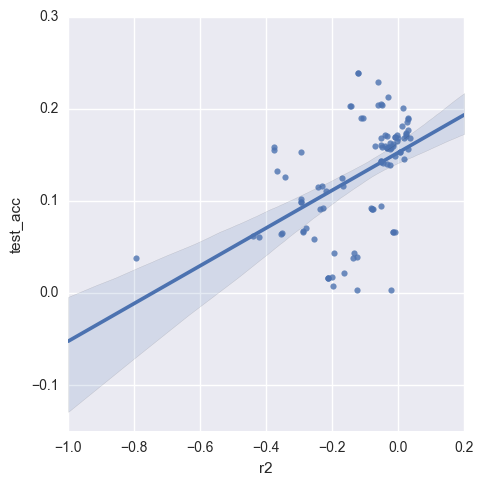

In [239]:
plt.close()
sns.lmplot('r2','test_acc',data=odf)
plt.show()


In [236]:
odf[odf.columns[:-1]].sort_values('neg_mean_abs_error',ascending=False)

Unnamed: 0          clf      p  fold  neg_mean_abs_error  \
0             3  LassoLarsIC  0.050   3.0            8.191091   
33           62        Lasso  0.100   2.0            7.649961   
36           83    LassoLars  0.100   2.0            7.601742   
22           41   elasticnet  0.100   2.0            7.551437   
8            80    LassoLars  0.200   2.0            7.513025   
10           59        Lasso  0.200   2.0            7.504352   
7            15         Lars    NaN   3.0            7.497376   
27           38   elasticnet  0.200   2.0            7.472212   
18            8  LassoLarsIC  0.005   2.0            7.471967   
9            26         Lars  0.010   2.0            7.443543   
21            5  LassoLarsIC  0.010   2.0            7.425126   
16           68        Lasso  0.010   2.0            7.378274   
17           89    LassoLars  0.010   2.0            7.350222   
11           92    LassoLars  0.005   2.0            7.321262   
14           71        Lasso  0.005   2.0            7.300322   
59           86    LassoLars  0.050   2.0            7.282642   
52           65        Lasso  0.050   2.0            7.280757   
50           44   elasticnet  0.050   2.0            7.276463   
60            7  LassoLarsIC  0.010  10.0            7.249380   
31           77    LassoLars    NaN   2.0            7.227184   
34           56        Lasso    NaN   2.0            7.226431   
3            47   elasticnet  0.010   2.0            7.218952   
15           35   elasticnet    NaN   2.0            7.192472   
6            32         Lars  0.001   2.0            7.148716   
5            95    LassoLars  0.001   2.0            7.148716   
4            11  LassoLarsIC  0.001   2.0            7.148716   
26           50   elasticnet  0.005   2.0            7.137647   
29           29         Lars  0.005   2.0            7.135895   
2            74        Lasso  0.001   2.0            7.114117   
1            53   elasticnet  0.001   2.0            7.023616   
..          ...          ...    ...   ...                 ...   
84           28         Lars  0.010  10.0            6.435231   
85           21         Lars  0.100   3.0            6.412032   
92            0  LassoLarsIC    NaN  10.0            6.409591   
93            1  LassoLarsIC  0.200  10.0            6.409591   
86           43   elasticnet  0.100  10.0            6.408895   
66           16         Lars    NaN  10.0            6.407862   
96           30         Lars  0.005   3.0            6.403255   
94            2  LassoLarsIC  0.100  10.0            6.396035   
95           51   elasticnet  0.005   3.0            6.394827   
76           25         Lars  0.050  10.0            6.389308   
35           39   elasticnet  0.200   3.0            6.382899   
39           40   elasticnet  0.200  10.0            6.377368   
65           37   elasticnet    NaN  10.0            6.377143   
72           48   elasticnet  0.010   3.0            6.375609   
64           27         Lars  0.010   3.0            6.366818   
89           82    LassoLars  0.200  10.0            6.364092   
77           19         Lars  0.200  10.0            6.352383   
91           61        Lasso  0.200  10.0            6.339325   
70           58        Lasso    NaN  10.0            6.331185   
69           79    LassoLars    NaN  10.0            6.330028   
63           18         Lars  0.200   3.0            6.323117   
73           22         Lars  0.100  10.0            6.282961   
88           24         Lars  0.050   3.0            6.274471   
98           98          NaN    NaN   NaN                 NaN   
99           99          NaN    NaN   NaN                 NaN   
100         100          NaN    NaN   NaN                 NaN   
101         101          NaN    NaN   NaN                 NaN   
102         102          NaN    NaN   NaN                 NaN   
103         103          NaN    NaN   NaN                 NaN   
104         104          NaN    NaN   Na

In [269]:
sht = '/Users/jakevogel/Downloads/RBANS_3.0.xlsx'
cog = pandas.ExcelFile(sht)
cog = pandas.ExcelFile(sht).parse(cog.sheet_names[0])
cog.head()

PSCID  CandID  Date_taken  Candidate_Age test_version test_language  \
0  MTL0001  672207  2012-10-09          857.2            A        French   
1  MTL0002  999145  2012-11-06          875.8            A        French   
2  MTL0003  746832  2012-09-27          842.8            A        French   
3  MTL0004  530104  2012-11-15          762.1            A        French   
4  MTL0005  425566  2012-10-05          744.9            A        French   

   immediate_memory_index_score  visuospatial_constructional_index_score  \
0                           106                                      121   
1                            94                                       89   
2                            85                                      131   
3                            97                                       92   
4                           109                                      100   

   language_index_score  attention_index_score  delayed_memory_index_score  \
0                   101                    115                          91   
1                    96                    112                          86   
2                   101                    106                         110   
3                    90                     97                          95   
4                   104                     91                         102   

   total_scale_index_score  
0                      109  
1                       93  
2                      108  
3                       91  
4                      101

In [274]:
cog[cog.PSCID == 'MTL0002']['Date_taken']

1      2012-11-06
183    2013-05-10
341    2014-02-04
497    2014-12-01
608    2015-12-09
Name: Date_taken, dtype: object

In [298]:
blz = {}
for sub in cog.PSCID.unique():
    blz.update({sub: cog[cog.PSCID == sub]['Date_taken'].values[0]})

In [277]:
from dateutil.parser import parse

In [299]:
for i,row in cog.iterrows():
    sub = row['PSCID']
    diff = (parse(row['Date_taken']) - parse(blz[sub])).days
    cog.ix[i,'tsb'] = diff

In [283]:
ld_05.columns[:15]

Index(['Column 1', 'Unnamed: 0', 'Unnamed: 0.1', 'Gender', 'Age', 'FD',
       'ApoE4_status', 'tPSO', 'p0_dens', 'p1_dens', 'p2_dens', 'p3_dens',
       'p4_dens', 'p5_dens', 'p6_dens'],
      dtype='object')

In [300]:
cols = ['Gender', 'Age', 'FD', 'ApoE4_status', 'tPSO']
for i,row in cog.iterrows():
    sub = row['PSCID']
    if sub in ld_05.index:
        for col in cols:
            cog.ix[i,col] = ld_05.ix[sub,col]
        

In [438]:
len(cog.PSCID.unique())

342

In [441]:
cog.to_excel('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/Cognition/all_cog_PAD.xls')

In [303]:
cog_full = cog.dropna()

In [437]:
len(cog_full.PSCID.unique())

187

In [304]:
for i,row in cog_full.iterrows():
    sub = row['PSCID']
    if sub in mm_test.index:
        cog_full.ix[i,'test'] = 1
    else:
        cog_full.ix[i,'test'] = 0

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [307]:
cog_test = cog_full[cog_full.test == 1]

In [309]:
for i,row in cog_test.iterrows():
    sub = row['PSCID']
    if sub in kmmtest_predicted.index:
        cog_test.ix[i,'pred_tPSO'] = kmmtest_predicted[sub]

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [316]:
cog_test.to_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/test_cognitive.csv')

In [315]:
cog_test

PSCID  CandID  Date_taken  Candidate_Age test_version test_language  \
7     MTL0018  624956  2012-10-29          829.5            A        French   
8     MTL0023  605902  2012-09-28          921.8            A        French   
10    MTL0026  322960  2012-10-31          766.1            A        French   
12    MTL0032  839504  2012-10-18          733.0            A        French   
19    MTL0041  871075  2013-04-09          750.4            A        French   
23    MTL0064  263388  2012-10-02          731.8            A       English   
25    MTL0068  824609  2012-10-24          848.5            A        French   
27    MTL0079  621974  2012-10-29          743.7            A        French   
33    MTL0097  367687  2012-11-28          869.6            A        French   
35    MTL0102  259716  2012-11-30          793.7            A        French   
43    MTL0124  366250  2013-01-23          737.8            A        French   
45    MTL0135  749987  2013-02-06          730.6            A        French   
53    MTL0165  758921  2013-02-04          728.7            A        French   
55    MTL0168  519965  2013-02-27          738.7            A        French   
56    MTL0169  705569  2013-02-15          845.2            A        French   
67    MTL0199  295620  2013-04-24          718.0            A        French   
73    MTL0207  721347  2013-05-06          799.9            A       English   
74    MTL0212  518271  2013-04-22          694.1            A        French   
77    MTL0219  497645  2013-05-31          681.9            A        French   
83    MTL0234  337112  2013-06-05          860.5            A        French   
86    MTL0244  191856  2013-10-21          674.7            A        French   
87    MTL0248  625190  2013-06-21          733.8            A        French   
88    MTL0254  164071  2013-08-05          685.2            A       English   
90    MTL0263  165177  2013-09-24          696.0            A        French   
98    MTL0276  971552  2013-07-18          747.3            A       English   
99    MTL0278  705011  2013-09-26          695.3            A        French   
100   MTL0279  164879  2013-07-17          805.6            A       English   
102   MTL0282  350335  2013-10-17          727.5            A        French   
105   MTL0287  457174  2013-08-14          740.4            A       English   
112   MTL0300  329146  2013-10-04          812.1            A       English   
...       ...     ...         ...            ...          ...           ...   
842   MTL0094  267824  2014-06-19          794.1            B        French   
849   MTL0128  668381  2013-10-23          760.7            B        French   
857   MTL0178  832208  2014-03-14          869.7            B        French   
864   MTL0204  295195  2014-05-20          750.4            B        French   
876   MTL0250  397191  2014-08-27          750.1            B        French   
879   MTL0272  729557  2014-08-25          710.4            B        French   
886   MTL0328  797330  2015-01-15          862.2            B        French   
892   MTL0404  520065  2015-09-17          734.0            B        French   
899   MTL0436  449999  2016-06-30          726.5            B       English   
900   MTL0449  139940  2016-06-15          702.5            B        French   
917   MTL0010  743428  2014-12-04          876.5            C        French   
918   MTL0012  352959  2014-10-08          832.7            C        French   
925   MTL0062  600099  2014-09-26          852.9            C        French   
931   MTL0094  267824  2015-06-19          806.1            C        French   
938   MTL0128  668381  2014-09-24          771.8            C        French   
946   MTL0178  832208  2015-03-18          881.9            C        French   
953   MTL0204  295195  2015-04-09          761.0            C        French   
963   MTL0250  397191  2015-07-16          760.8            C        French   
966   MTL0272  729557  2015-09-03          722.6          

In [324]:
a4_train = mm_train.loc[ld_05[ld_05['ApoE4_status'] == 1].index].dropna()

In [325]:
a4_test = mm_test.loc[ld_05[ld_05['ApoE4_status'] == 1].index].dropna()

In [331]:
ldy = ld_05.loc[a4_train.index].tPSO
ldt_y = ld_05.loc[a4_test.index].tPSO
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
a4_output = kfl.kfold_feature_learning(a4_train,a4_test,ldy,ldt_y, folds = 10, 
                                    p_cutoff = None, output='light',scale=True)





running model for fold 1 of 10
running model for fold 2 of 10
running model for fold 3 of 10
running model for fold 4 of 10
running model for fold 5 of 10
running model for fold 6 of 10
running model for fold 7 of 10
running model for fold 8 of 10
running model for fold 9 of 10
running model for fold 10 of 10
84 features selected
validation prediction accuracy is 13.3043229441 percent 
 p = 0.0108050508785 
 r = 0.364750914243
testing prediction accuracy is 0.704590843221 percent 
 p = 0.677218428794 
 r = 0.083939909651


In [333]:
csf = pandas.read_csv('/Users/jakevogel/Downloads/preventad_model_20171010.csv')
csf.head()

Unnamed: 0  CandID Visit_label  mean_gmv  Candidate_Age  Gender  sex ApoE  \
0  s108583NAP  108583     NAPBL00  0.339889          813.1  Female  0.0  3/3   
1  s113451NAP  113451     NAPBL00  0.343742          765.3  Female  0.0  3/2   
2  s115095PRE  115095     PREBL00  0.304767          780.2    Male  1.0  4/4   
3  s117603PRE  117603     PREBL00  0.342508          723.8    Male  1.0  3-3   
4  s122650PRE  122650     PREBL00  0.298912          885.0  Female  0.0  3-3   

   apoE_allele_no  E4_allele_Bin    ...     language_index_score  \
0             0.0            0.0    ...                      104   
1             0.0            0.0    ...                       98   
2             2.0            1.0    ...                      108   
3             0.0            0.0    ...                      104   
4             0.0            0.0    ...                      112   

   attention_index_score  delayed_memory_index_score  rbans_total_index_score  \
0                    125                          88                      104   
1                     85                         106                       93   
2                    115                         102                      112   
3                     82                         112                      109   
4                     88                         103                      100   

   ELISA_b_amyloid  Abeta34  Abeta40  ELISA_tau  ELISA_ptau       TIV  
0           890.00      NaN      NaN     264.00       46.50  1.471101  
1          1227.45   315.52  10569.5     308.24       51.83  1.407138  
2              NaN      NaN      NaN        NaN         NaN  1.474878  
3              NaN      NaN      NaN        NaN         NaN  1.528923  
4              NaN      NaN      NaN        NaN         NaN  1.350850  

[5 rows x 22 columns]

In [427]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [382]:
from sklearn import ensemble

In [401]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
clf = ensemble.RandomForestRegressor(random_state=123)
jnk = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, clf, 
                                    folds = 10, p_cutoff = 0.05, search = False, output='light',scale=True,
                                vote = True)

random forest detected, setting vote to 'soft'
running correlation for fold 1 of 10
running model for fold 1 of 10
running correlation for fold 2 of 10
running model for fold 2 of 10
running correlation for fold 3 of 10
running model for fold 3 of 10
running correlation for fold 4 of 10
running model for fold 4 of 10
running correlation for fold 5 of 10
running model for fold 5 of 10
running correlation for fold 6 of 10
running model for fold 6 of 10
running correlation for fold 7 of 10
running model for fold 7 of 10
running correlation for fold 8 of 10
running model for fold 8 of 10
running correlation for fold 9 of 10
running model for fold 9 of 10
running correlation for fold 10 of 10
running model for fold 10 of 10
297 features selected
validation prediction accuracy is 2.58594556491 percent 
 p = 0.059541476917 
 r = 0.160808754889
testing prediction accuracy is 12.0698744092 percent 
 p = 0.00369883014965 
 r = 0.347417247833


In [409]:
(136 - 68) / 15

4.533333333333333

In [417]:
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
clf = ensemble.AdaBoostRegressor(random_state=123)
jnk = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, clf, 
                                    folds = 3, p_cutoff = 0.05, search = False, output='light',scale=True,
                                vote = True)

running correlation for fold 1 of 3
running model for fold 1 of 3
running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
213 features selected
validation prediction accuracy is 1.71164690943 percent 
 p = 0.12613907681 
 r = 0.130829924308
testing prediction accuracy is 15.1918069892 percent 
 p = 0.00101807258268 
 r = 0.389766686483


In [425]:
a = np.array([0, 1, 0, 1])
trans = (a-1) + a
print(trans * 1)
print(trans * 0.5)
print(trans * 0.1)

[-1  1 -1  1]
[-0.5  0.5 -0.5  0.5]
[-0.1  0.1 -0.1  0.1]


In [426]:
a = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
trans = (a-1) + a 
print(trans * 1)
print(trans * 0.5)
print(trans * 0.1)

[-1.  -0.6 -0.2  0.2  0.6  1. ]
[-0.5 -0.3 -0.1  0.1  0.3  0.5]
[-0.1  -0.06 -0.02  0.02  0.06  0.1 ]


In [428]:
# random forest weighted
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
clf = ensemble.RandomForestRegressor(random_state=123)
jnk = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, clf, 
                                    folds = 10, p_cutoff = 0.05, search = False, output='light',scale=True,
                                weighted = True)

random forest detected, setting vote to 'soft'
changing vote to None
running correlation for fold 1 of 10
running model for fold 1 of 10
running correlation for fold 2 of 10
running model for fold 2 of 10
running correlation for fold 3 of 10
running model for fold 3 of 10
running correlation for fold 4 of 10
running model for fold 4 of 10
running correlation for fold 5 of 10
running model for fold 5 of 10
running correlation for fold 6 of 10
running model for fold 6 of 10
running correlation for fold 7 of 10
running model for fold 7 of 10
running correlation for fold 8 of 10
running model for fold 8 of 10
running correlation for fold 9 of 10
running model for fold 9 of 10
running correlation for fold 10 of 10
running model for fold 10 of 10
297 features selected
validation prediction accuracy is 2.58594556491 percent 
 p = 0.059541476917 
 r = 0.160808754889
testing prediction accuracy is 12.333049826 percent 
 p = 0.00332049689204 
 r = 0.351184422006


In [431]:
# ADA boost weighted
ldy = ld_05.loc[shuffler1].tPSO
ldt_y = ld_05.loc[shuffler2].tPSO
clf = ensemble.AdaBoostRegressor(random_state=123)
jnk = kfl.kfold_feature_learning(mm_train.loc[shuffler1], mm_test.loc[shuffler2],ldy,ldt_y, clf, 
                                    folds = 3, p_cutoff = 0.05, search = False, output='light',scale=True,
                                vote = 'hard', weighted = True, save_int = False)

changing vote to None
running correlation for fold 1 of 3
running model for fold 1 of 3
running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
213 features selected
validation prediction accuracy is 1.71164690943 percent 
 p = 0.12613907681 
 r = 0.130829924308
testing prediction accuracy is 10.4756074774 percent 
 p = 0.00709448783326 
 r = 0.323660431276


In [434]:
# orig weighted
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
output = kfl.kfold_feature_learning(mm_train, mm_test, ldy, ldt_y, folds = folds, p_cutoff = p_cutoff, 
                                    output='light',scale=True, weighted = True)




running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
53 features selected
validation prediction accuracy is 30.7951582585 percent 
 p = 1.63155802435e-12 
 r = -0.554933854243
testing prediction accuracy is 20.8421503295 percent 
 p = 9.11459448182e-05 
 r = -0.456532039724


In [346]:
nind = []
for i,row in csf.iterrows():
    if row['Unnamed: 0'] in ld_05['Unnamed: 0'].values:
        nid = ld_05[ld_05['Unnamed: 0'] == row['Unnamed: 0']].index[0]
        nind.append(nid)
    else:
        nind.append(np.nan)
csf.index = nind

In [374]:
ld_05['abeta_ratio'] = ld_05['ELISA_b_amyloid'] / ld_05['Abeta40'] 
ld_05['ab_tau_ratio'] = ld_05['ELISA_b_amyloid'] / ld_05['ELISA_ptau'] 

In [360]:
cols = csf.columns[-12:]
for sub in ld_05.index:
    if sub in csf.index:
        for col in cols:
            ld_05.ix[sub,col] = csf.ix[sub,col]

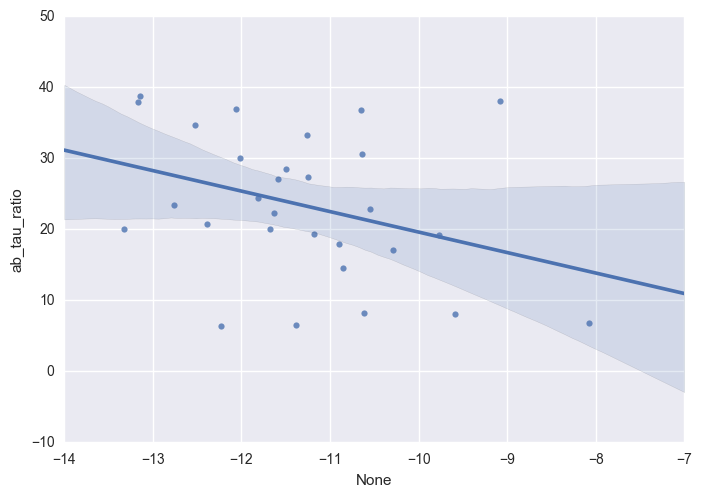

In [378]:
plt.close()
sns.regplot(kmmtest_predicted.loc[ld_05.loc[mm_test.index]['ab_tau_ratio'].dropna().index], 
         ld_05.loc[mm_test.index]['ab_tau_ratio'].dropna())
plt.show()

In [381]:

stats.pearsonr(kmmtest_predicted.loc[ld_05.loc[mm_test.index]['ELISA_tau'].dropna().index], 
         ld_05.loc[mm_test.index]['ELISA_tau'].dropna())


(0.16565704697638897, 0.3904475155938727)

In [364]:
sns.distplot?

In [348]:
ld_05.loc[csf.index].dropna()

Column 1  Unnamed: 0 Unnamed: 0.1  Gender   Age     FD  ApoE4_status  \
MTL0392       0.0  s108583NAP   s108583NAP     0.0  67.0  0.256           0.0   
MTL0415       1.0  s113451NAP   s113451NAP     0.0  63.0  0.240           0.0   
MTL0380       2.0  s115095PRE   s115095PRE     1.0  64.0  0.183           1.0   
MTL0008       3.0  s122650PRE   s122650PRE     0.0  72.0  0.289           0.0   
MTL0449       4.0  s139940PRE   s139940PRE     0.0  56.0  0.248           0.0   
MTL0140       6.0  s159332PRE   s159332PRE     0.0  60.0  0.222           1.0   
MTL0254       7.0  s164071NAP   s164071NAP     0.0  56.0  0.284           1.0   
MTL0279       8.0  s164879NAP   s164879NAP     0.0  67.0  0.221           1.0   
MTL0263       9.0  s165177NAP   s165177NAP     1.0  57.0  0.163           0.0   
MTL0013      10.0  s182051PRE   s182051PRE     1.0  62.0  0.272           0.0   
MTL0317      11.0  s182763PRE   s182763PRE     0.0  67.0  0.235           1.0   
MTL0244      12.0  s191856NAP   s191856NAP     0.0  55.0  0.259           1.0   
MTL0327      13.0  s196878NAP   s196878NAP     0.0  68.0  0.267           1.0   
MTL0385      14.0  s199569NAP   s199569NAP     1.0  60.0  0.240           1.0   
MTL0353      15.0  s202177NAP   s202177NAP     0.0  58.0  0.312           0.0   
MTL0333      17.0  s206939NAP   s206939NAP     0.0  59.0  0.274           0.0   
MTL0412      18.0  s210743NAP   s210743NAP     1.0  61.0  0.196           0.0   
MTL0150      19.0  s213764NAP   s213764NAP     1.0  62.0  0.283           1.0   
MTL0194      20.0  s219026PRE   s219026PRE     0.0  62.0  0.093           1.0   
MTL0092      21.0  s224125NAP   s224125NAP     0.0  63.0  0.219           1.0   
MTL0393      22.0  s224536NAP   s224536NAP     0.0  73.0  0.209           0.0   
MTL0104      23.0  s229327PRE   s229327PRE     0.0  64.0  0.207           1.0   
MTL0101      24.0  s242152NAP   s242152NAP     0.0  62.0  0.206           1.0   
MTL0249      25.0  s242477PRE   s242477PRE     0.0  65.0  0.178           0.0   
MTL0201      27.0  s250222NAP   s250222NAP     1.0  58.0  0.110           1.0   
MTL0069      28.0  s259072PRE   s259072PRE     0.0  63.0  0.200           1.0   
MTL0102      29.0  s259716NAP   s259716NAP     0.0  65.0  0.189           0.0   
MTL0064      30.0  s263388NAP   s263388NAP     0.0  60.0  0.200           0.0   
MTL0039      31.0  s266445NAP   s266445NAP     0.0  60.0  0.176           1.0   
MTL0094      32.0  s267824PRE   s267824PRE     0.0  63.0  0.202           0.0   
...           ...         ...          ...     ...   ...    ...           ...   
MTL0420     171.0  s833428NAP   s833428NAP     0.0  56.0  0.197           0.0   
MTL0270     172.0  s835918NAP   s835918NAP     0.0  55.0  0.223           0.0   
MTL0032     173.0  s839504NAP   s839504NAP     1.0  60.0  0.268           1.0   
MTL0252     174.0  s840755PRE   s840755PRE     0.0  72.0  0.306           0.0   
MTL0243     175.0  s845537PRE   s845537PRE     0.0  69.0  0.250           0.0   
MTL0198     176.0  s846751PRE   s846751PRE     0.0  61.0  0.134           0.0   
MTL0125     177.0  s848487NAP   s848487NAP     1.0  65.0  0.223           1.0   
MTL0223     178.0  s853177PRE   s853177PRE     0.0  64.0  0.191           0.0   
MTL0402     179.0  s854912NAP   s854912NAP     0.0  68.0  0.212           0.0   
MTL0177     180.0  s855307PRE   s855307PRE     0.0  65.0  0.183           1.0   
MTL0291     181.0  s860263NAP   s860263NAP     0.0  61.0  0.135           0.0   
MTL0093     182.0  s864416PRE   s864416PRE     0.0  62.0  0.251           0.0   
MTL0041     184.0  s871075NAP   s871075NAP     0.0  61.0  0.173           0.0   
MTL0242     185.0  s871851NAP   s871851NAP     0.0  60.0  0.245           0.0   
MTL0365     187.0  s890633NAP   s890633NAP     0.0  62.0  0.223           1.0   
MTL0230     188.0  s908576PRE   s908576PRE     0.0  58.0  0.317           0.0   
MTL0156     189.0  s910420PRE   s910420PRE     0.0  60.0  0.251           0.0   
MTL0273     190.0  s912944NAP   s912944N

In [341]:
row['Unnamed: 0']

's999919NAP'

In [343]:
ld_05['Unnamed: 0']

MTL0392    s108583NAP
MTL0415    s113451NAP
MTL0380    s115095PRE
MTL0008    s122650PRE
MTL0449    s139940PRE
MTL0074    s156450NAP
MTL0140    s159332PRE
MTL0254    s164071NAP
MTL0279    s164879NAP
MTL0263    s165177NAP
MTL0013    s182051PRE
MTL0317    s182763PRE
MTL0244    s191856NAP
MTL0327    s196878NAP
MTL0385    s199569NAP
MTL0353    s202177NAP
MTL0407    s203712PRE
MTL0333    s206939NAP
MTL0412    s210743NAP
MTL0150    s213764NAP
MTL0194    s219026PRE
MTL0092    s224125NAP
MTL0393    s224536NAP
MTL0104    s229327PRE
MTL0101    s242152NAP
MTL0249    s242477PRE
MTL0405    s245247NAP
MTL0201    s250222NAP
MTL0069    s259072PRE
MTL0102    s259716NAP
              ...    
MTL0198    s846751PRE
MTL0125    s848487NAP
MTL0223    s853177PRE
MTL0402    s854912NAP
MTL0177    s855307PRE
MTL0291    s860263NAP
MTL0093    s864416PRE
MTL0411    s865106PRE
MTL0041    s871075NAP
MTL0242    s871851NAP
MTL0320    s878709NAP
MTL0365    s890633NAP
MTL0230    s908576PRE
MTL0156    s910420PRE
MTL0273   

## Randomly doing some PGRS stuff here...

In [443]:
pgrs = pandas.read_table('/Users/jakevogel/Science/PRSice_v1.25/PRSice_SCORES_AT_BEST-FIT-PRS.txt', sep=' ')
pgrs.head()

IID  pT_0.00001
0  002_S_0413   -0.001663
1  002_S_0685    0.003405
2  002_S_0729    0.006908
3  002_S_1261   -0.002039
4  002_S_1268   -0.000775

In [444]:
pgrs.shape

(441, 2)

In [447]:
pgrs.index = [x[-4:] for x in pgrs.IID]

In [448]:
pgrs_mm = deepcopy(adni_mm)

In [449]:
for sub in pgrs.index:
    if sub in pgrs_mm.index:
        pgrs_mm.ix[sub,'pgrs_score'] = pgrs.ix[sub,'pT_0.00001']

In [451]:
pgrs_mm.dropna(inplace=True)

In [452]:
pgrs_mm.shape

(47, 889)

In [455]:
cx = pgrs_mm[pgrs_mm.columns[:-1]].values

In [460]:
cy = np.broadcast_to(pgrs_mm.pgrs_score.values.reshape(47,1),(47,888))

In [468]:
pg_ps = [stats.pearsonr(cx[:,x],cy[:,x])[-1] for x in range(cx.shape[-1])]

In [477]:
np.array(pg_ps)[np.array(pg_ps)<0.05]

array([ 0.04849567,  0.01880984,  0.03026591,  0.02317023,  0.04109037,
        0.04719073,  0.01010849,  0.02122071,  0.01751376,  0.03293212,
        0.01524852,  0.00070755,  0.04951677,  0.01831082,  0.01054202,
        0.04380454,  0.02190046,  0.03327182,  0.04731493,  0.03049842,
        0.02726241,  0.03147879,  0.03678612,  0.01705554,  0.01264005,
        0.02527922,  0.04479072,  0.0478191 ,  0.03204405,  0.03480407,
        0.04001027,  0.01587481,  0.03619338,  0.04300735,  0.00214844,
        0.00476678,  0.0160674 ])

In [485]:
tuple(zip(np.array(pg_ps)[np.array(pg_ps)<0.05],[pg_ps.index(x)-443 for x in pg_ps if x < 0.05]))

((0.048495674955368023, -372),
 (0.018809843415507628, -357),
 (0.030265911212755185, -221),
 (0.023170232208893731, -64),
 (0.041090368792369721, -39),
 (0.047190734724261843, -10),
 (0.010108485365717209, 5),
 (0.021220709679803818, 77),
 (0.017513763543304445, 108),
 (0.032932119078662322, 111),
 (0.015248518979572117, 117),
 (0.00070755228580460391, 125),
 (0.04951676670187815, 140),
 (0.018310823752468341, 142),
 (0.010542019981585573, 189),
 (0.043804542096621095, 200),
 (0.021900457492643865, 211),
 (0.033271822684543401, 222),
 (0.047314934019910368, 268),
 (0.030498419861470866, 276),
 (0.027262413605969905, 279),
 (0.031478792643246302, 287),
 (0.036786123861816331, 295),
 (0.017055541041876929, 310),
 (0.012640051789618776, 338),
 (0.025279220270105766, 343),
 (0.044790717445079703, 344),
 (0.047819103860731689, 346),
 (0.032044047002534964, 348),
 (0.034804067624428073, 367),
 (0.040010274234903706, 394),
 (0.015874808425627929, 397),
 (0.036193377772428537, 401),
 (0.04300